____

# <font color=#FFAA11> Two-Temperature Hydrodynamic Model </font>

The energy equation considered here, is assumed to be of the form of Kirkwood & Irving broken into electron and ion pieces, with the addition of the usual TTM electron-ion equilibration term. The energy listed is the full internal energy, and thus .

\begin{align}
\frac{\partial E^e}{\partial t}  + \frac{1}{r} \frac{\partial}{\partial r} (r E^e v) &= - \frac{1}{r}\frac{\partial}{\partial r} (v r P_e) - G (T_e - T_i), \\
\frac{\partial E^i}{\partial t}  + \frac{1}{r} \frac{\partial}{\partial r} (r E^i v) &= - \frac{1}{r}\frac{\partial}{\partial r} (v r P_i) + G (T_e - T_i)
\end{align}
With an accompanying momentum equation
\begin{align}
\left(\frac{\partial}{\partial t}  + v \frac{\partial}{\partial r}\right)v = -\frac{1}{ ρ}\frac{\partial}{\partial r}P.
\end{align} 

Currently I am dropping all heat flux terms! Based on idea that thermal conduction is slow, but it isn't clera what exactly the relation is between the generic heat flux term and the thermal conduction term in the TTM model.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from exp_setup import Cylindrical_Grid, Experiment
# from TTM_solver import TwoTemperatureModel
from Hydro_solver import HydroModel


from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Create Experimental Information

In [2]:
grid  = Cylindrical_Grid(500e-6, N=2000) 
Z, A = 54, 131
Te_initial, Ti_initial = 16.60952380952381e3, 9.32e3 #[K]
temperature_measurement_width = 20e-6 # [m]
intensity_FWHM = 50e-6
n0 = 1.25e20 *1e6

dih_file = "/home/zach/plasma/TTM/data/Xe5bar_DIH_profile_data.txt"


# Create Experimental layout and TTM solver
Xenon_jt = Experiment(grid, n0, Z, A, Te_initial, Ti_initial,intensity_FWHM, temperature_measurement_width, gas_name='Xenon', model = "JT",
                     ion_temperature_model = 'MD', electron_temperature_model='lorentz', ion_temperature_file = dih_file)

ttm_jt = HydroModel(Xenon_jt, model = "JT")

# Xenon_smt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Xenon', model = "SMT",
#                       ion_temperature_model = 'gaussian', ion_temperature_file = dih_file)
# ttm_smt = TwoTemperatureModel(Xenon_smt, model = "SMT")

Initial peak T_electron converged:  [17718.24246356] True The solution converged.
Te_max = 1.772e+04 K


In [67]:
ω_γ = 2*π*500e12
JT_GMS.photon_mean_free_path(ω_γ, ttm_jt.m_i, ttm_jt.n_i[0], ttm_jt.n_e[0], ttm_jt.Ti[0], ttm_jt.Te[0], ttm_jt.Zbar)

array([2.20139404e-06, 2.20144027e-06, 2.20157894e-06, ...,
       8.44518757e-06, 8.44714976e-06, 8.44911144e-06])

In [63]:
print("JT Model")
ttm_jt.make_times()
ttm_jt.print_timescales()

# print("\nSMT Model")
# ttm_smt.make_times()
# ttm_smt.print_timescales()

JT Model

Simulation time: 4.2e+00 ns,  dt = 2.2e+00 ps, steps = 1965
  Diffusion time (r_max): e:8.6e+04 ns, i:6.5e+45 ns 
  Diffusion time (dr): e:2.2e-02 ns, i:1.6e+39 ns 
  Thermalization Times: 8.46e+02 ps  8.46e+02 ps


In [ ]:
lambda x, pos: r"{0:.2f}$\times 10^{{ {1:.2f} }}$".format(x)

# Solve Two Temperature Model

In [103]:
JT_GMS.Thomas_Fermi_Zbar(Z, n0, 1e2)

0.12635705618281862

In [19]:
ttm_jt.solve_hydro(tmax=18e-9, dt=1e-12)
# ttm_smt.solve_TTM(tmax=18e-9, dt=1e-12)

# PLOTS

In [24]:
def plot_temp_profiles(ttm, plot_times = None, ax = None, title='', normalized=False):

    if plot_times is None:
        plot_times = (np.linspace(0,len(ttm.t_saved_list)*0.99,num=4,endpoint=True)).astype(int)  # Intermediate times for plotting        
        
    # Plot temperature profiles at intermediate times
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
    
    
        
    plot_idx = 0
    for plot_idx, ti in enumerate(plot_times):
        t = ttm.t_saved_list[ti]
        if normalized==True:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]/ttm.Te_list[ti][0], '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]/ttm.Ti_list[ti][0], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
        else:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, ttm.n_i_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            
        # plot_idx += 1


    # Plot settings
    ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
#     ax.set_xlim(0,50)
#     ax.set_ylim(0,10.1)
    ax.legend(fontsize=15)
    ax.grid(alpha = 0.3)
    ax.set_title(title, fontsize=20)


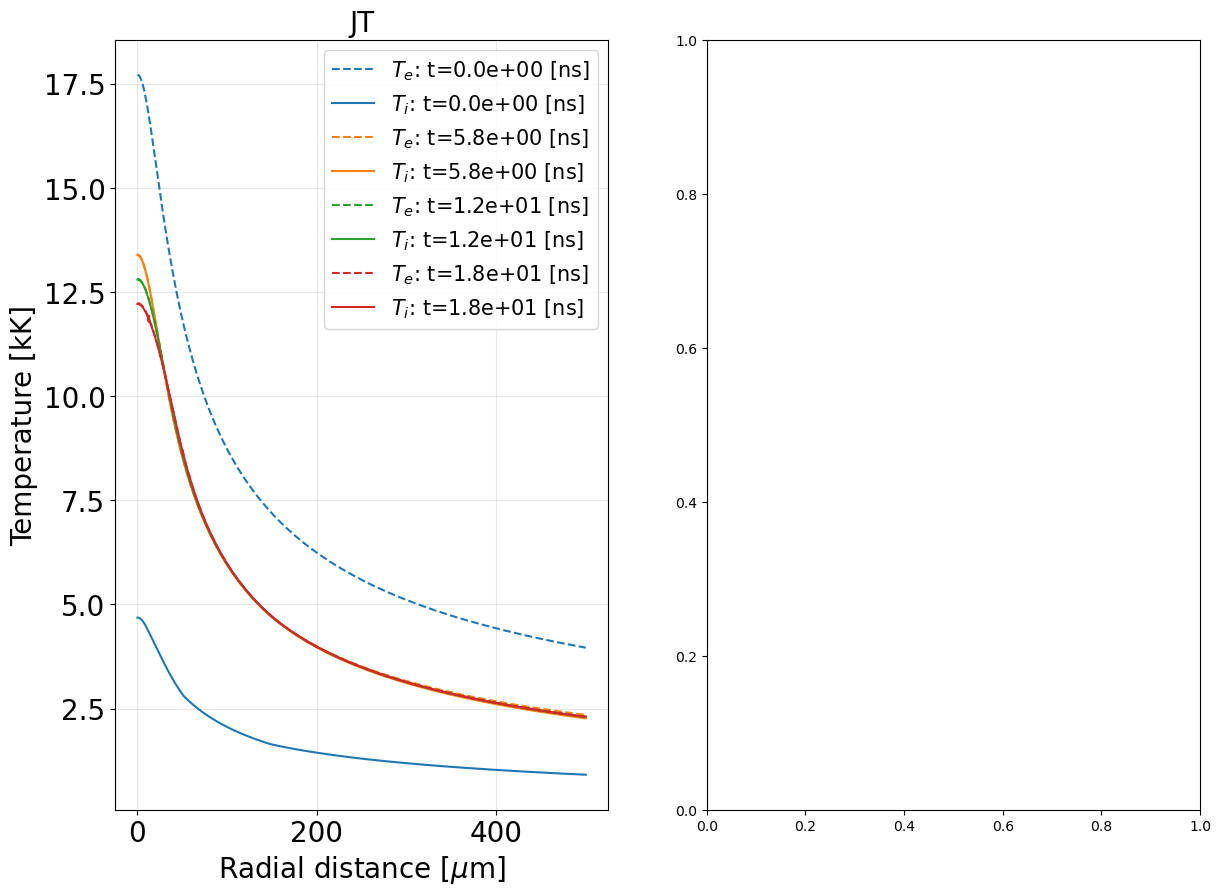

In [25]:
fig, ax = plt.subplots(1,2, figsize=(14,10),facecolor='w')

plot_temp_profiles(ttm_jt, ax = ax[0], title='JT', normalized=False)
# plot_temp_profiles(ttm_smt,  ax = ax[1], title='SMT')


# Plot FWHM

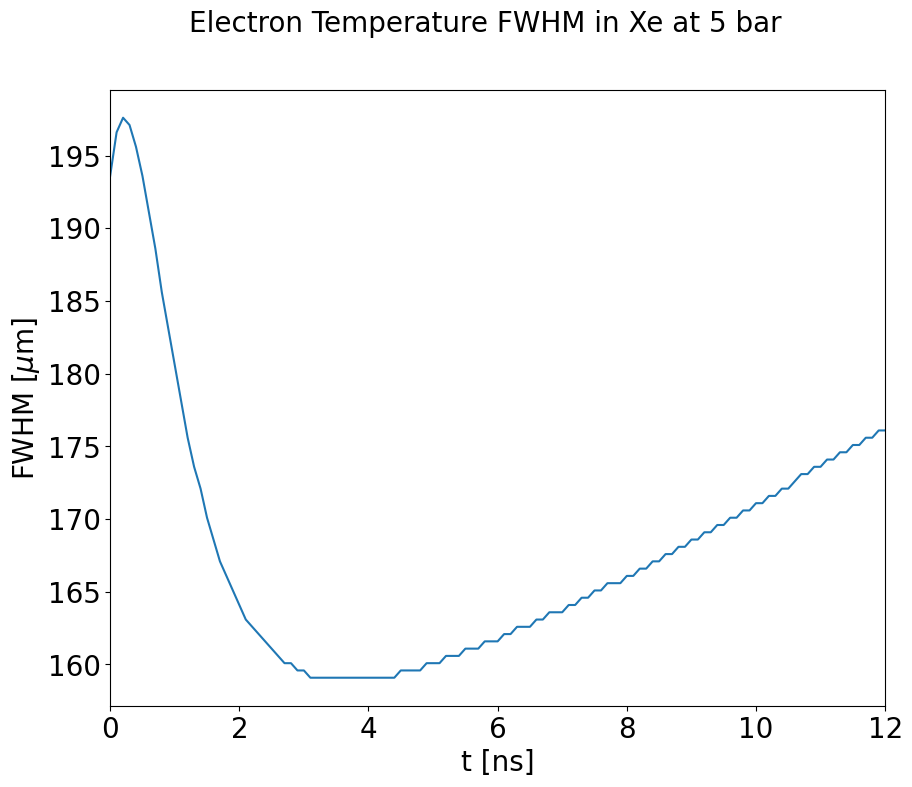

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle("Electron Temperature FWHM in Xe at 5 bar", fontsize=20)

ax.plot(np.array(ttm_jt.t_saved_list)*1e9, np.array(ttm_jt.FWHM_list)*1e6)
ax.set_ylabel('FWHM [$\mu$m]', fontsize=20)
ax.set_xlabel('t [ns]', fontsize=20)
ax.set_xlim(0,12)
# ax.set_ylim(40,60)
ax.tick_params(labelsize=20)


### Plotting Profiles over time

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

for k in range(len(ttm_jt.Te_list)):
    color = plt.cm.jet(k/len(ttm_jt.Te_list))
    ax.plot(ttm_jt.grid.cell_volumes*ttm_jt.n_e_list[k][:-1]*ttm_jt.Te_list[k][:-1], color=color)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

for k in range(len(ttm_jt.Te_list)):
    color = plt.cm.jet(k/len(ttm_jt.Te_list))
    ax.plot(ttm_jt.grid.r*ttm_jt.n_e_list[k]*ttm_jt.Te_list[k], color=color)

0.3452003163399393
0.34518676261511066
0.34517321179090626
0.3451596641555329
0.3451461195349684
0.345132578032066
0.3451190395838326
0.345105504226616
0.34509197193726
0.34507844272825133
0.34506491659072736
0.3450513935286142
0.3450378735381776
0.3450243566202729
0.34501084277300637
0.34499733199613164
0.3449838242884159
0.34497031964921787
0.34495681807754236
0.3449433195726065
0.3449298241335009
0.34491633175939246
0.3449028424494027
0.3448893562026811
0.34487587301836037
0.34486239289558407
0.34484891583348987
0.34483544183121917
0.3448219708879118
0.34480850300270893
0.3447950381747512
0.3447815764031804
0.34476811768713805
0.3447546620257662
0.3447412094182068
0.344727759863603
0.34471431336109715
0.34470086990983256
0.3446874295089528
0.3446739921576016
0.34466055785492294
0.34464712660006125
0.3446336983921611
0.34462027323036754
0.34460685111382583
0.3445934320416813
0.3445800160130801
0.34456660302716813
0.3445531930830919
0.3445397861799981
0.34452638231703386
0.34451298149

0.3355119034796572
0.33550050920997637
0.3354891174286266
0.33547772813494176
0.335466341328256
0.33545495700790345
0.33544357517321877
0.3354321958235369
0.3354208189581926
0.33540944457652117
0.335398072677858
0.33538670326153863
0.3353753363268992
0.3353639718732755
0.33535260990000393
0.335341250406421
0.3353298933918634
0.33531853885566815
0.3353071867971725
0.33529583721571354
0.3352844901106291
0.335273145481257
0.3352618033269351
0.3352504636470019
0.3352391264407956
0.3352277917076551
0.3352164594469192
0.33520512965792704
0.33519380234001805
0.33518247749253166
0.33517115511480766
0.3351598352061861
0.33514851776600707
0.3351372027936112
0.3351258902883389
0.33511458024953117
0.335103272676529
0.3350919675686738
0.3350806649253069
0.33506936474577004
0.3350580670294054
0.3350467717755548
0.3350354789835609
0.335024188652766
0.33501290078251306
0.33500161537214507
0.3349903324210053
0.3349790519284372
0.33496777389378424
0.3349564983163905
0.33494522519560005
0.334933954530757

0.32726359194488475
0.32725396640265125
0.32724434288577986
0.32723472139375287
0.3272251019260527
0.32721548448216176
0.32720586906156296
0.3271962556637388
0.32718664428817257
0.32717703493434747
0.32716742760174655
0.3271578222898535
0.32714821899815194
0.3271386177261257
0.3271290184732586
0.327119421239035
0.32710982602293903
0.32710023282445516
0.32709064164306817
0.3270810524782626
0.3270714653295234
0.3270618801963359
0.3270522970781851
0.32704271597455664
0.3270331368849359
0.32702355980880876
0.32701398474566096
0.3270044116949786
0.32699484065624806
0.3269852716289555
0.32697570461258774
0.3269661396066311
0.32695657661057254
0.3269470156238992
0.32693745664609825
0.326927899676657
0.32691834471506276
0.32690879176080345
0.32689924081336674
0.3268896918722406
0.3268801449369132
0.32687060000687274
0.32686105708160773
0.32685151616060676
0.32684197724335873
0.32683244032935227
0.3268229054180768
0.32681337250902126
0.3268038416016752
0.32679431269552817
0.32678478579006986
0.

0.3201527063587264
0.320144551680364
0.32013639865910215
0.320128247294535
0.3201200975862568
0.3201119495338619
0.3201038031369447
0.3200956583950996
0.32008751530792157
0.32007937387500535
0.3200712340959457
0.3200630959703379
0.32005495949777685
0.32004682467785805
0.3200386915101768
0.3200305599943287
0.3200224301299094
0.3200143019165145
0.3200061753537401
0.31999805044118196
0.31998992717843644
0.31998180556509964
0.319973685600768
0.3199655672850379
0.319957450617506
0.31994933559776906
0.3199412222254238
0.31993311050006734
0.3199250004212966
0.3199168919887089
0.31990878520190147
0.3199006800604716
0.31989257656401715
0.31988447471213566
0.31987637450442485
0.3198682759404827
0.31986017901990726
0.31985208374229657
0.31984399010724895
0.3198358981143628
0.3198278077632366
0.31981971905346895
0.3198116319846586
0.3198035465564046
0.3197954627683056
0.31978738061996076
0.31977930011096944
0.319771221240931
0.31976314400944456
0.3197550684161101
0.31974699446052707
0.319738922142

0.31441909470937296
0.3144120877865537
0.31440508224473085
0.31439807808357867
0.31439107530277116
0.31438407390198236
0.3143770738808867
0.31437007523915844
0.3143630779764722
0.3143560820925024
0.3143490875869236
0.3143420944594107
0.3143351027096383
0.31432811233728153
0.3143211233420154
0.3143141357235148
0.3143071494814551
0.3143001646155115
0.3142931811253594
0.3142861990106744
0.31427921827113176
0.3142722389064073
0.3142652609161768
0.31425828430011593
0.3142513090579008
0.31424433518920736
0.3142373626937116
0.31423039157108984
0.31422342182101837
0.31421645344317356
0.31420948643723184
0.31420252080286987
0.31419555653976405
0.3141885936475914
0.3141816321260286
0.3141746719747528
0.31416771319344067
0.31416075578176966
0.31415379973941665
0.3141468450660592
0.3141398917613745
0.3141329398250402
0.31412598925673374
0.31411904005613284
0.31411209222291514
0.3141051457567587
0.3140982006573412
0.31409125692434076
0.31408431455743546
0.3140773735563036
0.31407043392062345
0.3140

0.309409193174154
0.30940315965655457
0.30939712729401136
0.30939109608626075
0.30938506603303956
0.3093790371340845
0.3093730093891322
0.30936698279791963
0.30936095736018365
0.30935493307566136
0.30934890994408976
0.30934288796520587
0.30933686713874703
0.3093308474644505
0.3093248289420536
0.3093188115712939
0.3093127953519086
0.30930678028363534
0.30930076636621195
0.309294753599376
0.30928874198286527
0.30928273151641766
0.309276722199771
0.30927071403266326
0.30926470701483266
0.30925870114601706
0.309252696425955
0.3092466928543845
0.30924069043104396
0.3092346891556718
0.30922868902800654
0.30922269004778674
0.3092166922147509
0.30921069552863795
0.3092046999891864
0.3091987055961352
0.3091927123492233
0.3091867202481896
0.3091807292927732
0.3091747394827132
0.30916875081774886
0.3091627632976192
0.3091567769220639
0.3091507916908221
0.3091448076036334
0.30913882466023723
0.30913284286037335
0.3091268622037813
0.309120882690201
0.3091149043193721
0.30910892709103455
0.309102951

0.30525908642652416
0.305253837212906
0.3052485889781138
0.3052433417219309
0.305238095444141
0.3052328501445274
0.30522760582287395
0.30522236247896417
0.30521712011258184
0.3052118787235107
0.30520663831153455
0.3052013988764374
0.305196160418003
0.3051909229360155
0.30518568643025906
0.30518045090051754
0.3051752163465753
0.3051699827682165
0.3051647501652253
0.3051595185373862
0.3051542878844836
0.30514905820630195
0.3051438295026257
0.30513860177323926
0.3051333750179276
0.30512814923647513
0.3051229244286667
0.30511770059428706
0.30511247773312106
0.3051072558449535
0.30510203492956967
0.3050968149867542
0.30509159601629227
0.30508637801796906
0.30508116099156973
0.3050759449368796
0.30507072985368383
0.3050655157417677
0.3050603026009169
0.3050550904309166
0.3050498792315526
0.3050446690026102
0.30503945974387514
0.30503425145513313
0.3050290441361698
0.30502383778677117
0.3050186324067229
0.3050134279958109
0.3050082245538211
0.30500302208053975
0.3049978205757527
0.30499262003

0.3015323955631965
0.3015278325136051
0.30152327029317394
0.3015187089017248
0.3015141483390796
0.30150958860506016
0.30150502969948856
0.3015004716221865
0.3014959143729762
0.30149135795167975
0.3014868023581191
0.3014822475921166
0.3014776936534943
0.3014731405420745
0.30146858825767947
0.30146403680013156
0.30145948616925317
0.3014549363648667
0.30145038738679464
0.30144583923485946
0.3014412919088837
0.30143674540869014
0.3014321997341012
0.3014276548849396
0.3014231108610282
0.3014185676621898
0.30141402528824696
0.30140948373902277
0.30140494301434023
0.30140040311402205
0.30139586403789137
0.30139132578577127
0.30138678835748484
0.30138225175285505
0.3013777159717053
0.30137318101385857
0.30136864687913845
0.301364113567368
0.30135958107837063
0.30135504941196983
0.30135051856798895
0.30134598854625144
0.3013414593465811
0.30133693096880115
0.30133240341273543
0.3013278766782077
0.30132335076504146
0.3013188256730604
0.3013143014020886
0.3013097779519498
0.30130525532246777
0.30

0.29841499744618816
0.29841099430237517
0.29840699186890474
0.29840299014562793
0.2983989891323963
0.2983949888290608
0.29839098923547297
0.29838699035148414
0.2983829921769456
0.29837899471170903
0.2983749979556257
0.2983710019085473
0.29836700657032517
0.2983630119408111
0.29835901801985665
0.29835502480731346
0.2983510323030332
0.29834704050686767
0.2983430494186685
0.2983390590382878
0.29833506936557697
0.2983310804003883
0.2983270921425736
0.2983231045919846
0.2983191177484735
0.29831513161189227
0.298311146182093
0.29830716145892766
0.2983031774422485
0.29829919413190764
0.29829521152775734
0.2982912296296497
0.2982872484374372
0.29828326795097204
0.29827928817010646
0.298275309094693
0.29827133072458406
0.29826735305963203
0.2982633760996894
0.2982593998446088
0.29825542429424257
0.2982514494484435
0.29824747530706425
0.2982435018699574
0.2982395291369756
0.29823555710797167
0.2982315857827984
0.2982276151613085
0.29822364524335504
0.2982196760287906
0.2982157075174683
0.2982117

0.29572188771103897
0.2957183571921073
0.29571482728568055
0.29571129799163337
0.29570776930984066
0.295704241240177
0.2957007137825174
0.2956971869367366
0.2956936607027093
0.2956901350803108
0.29568661006941577
0.29568308566989926
0.2956795618816362
0.29567603870450165
0.2956725161383707
0.2956689941831185
0.2956654728386198
0.2956619521047503
0.2956584319813848
0.2956549124683986
0.2956513935656669
0.29564787527306496
0.29564435759046814
0.29564084051775175
0.295637324054791
0.29563380820146146
0.2956302929576385
0.2956267783231974
0.29562326429801383
0.29561975088196313
0.295616238074921
0.2956127258767628
0.2956092142873642
0.29560570330660085
0.2956021929343484
0.2955986831704825
0.2955951740148788
0.29559166546741306
0.2955881575279611
0.29558465019639873
0.29558114347260156
0.29557763735644577
0.29557413184780695
0.2955706269465611
0.29556712265258434
0.29556361896575234
0.29556011588594117
0.295556613413027
0.2955531115468859
0.2955496102873938
0.29554610963442685
0.2955426095

0.2932749286389184
0.29327181796323126
0.2932687078151472
0.29326559819456083
0.2932624891013668
0.2932593805354597
0.29325627249673414
0.2932531649850846
0.293250058000406
0.2932469515425929
0.2932438456115401
0.29324074020714225
0.29323763532929414
0.2932345309778907
0.2932314271528266
0.29322832385399666
0.2932252210812958
0.29322211883461896
0.293219017113861
0.2932159159189169
0.29321281524968157
0.29320971510604993
0.2932066154879172
0.2932035163951783
0.29320041782772827
0.29319731978546215
0.29319422226827513
0.2931911252760623
0.2931880288087189
0.29318493286614006
0.2931818374482208
0.2931787425548567
0.2931756481859428
0.29317255434137435
0.2931694610210467
0.29316636822485526
0.2931632759526952
0.29316018420446205
0.2931570929800511
0.29315400227935784
0.2931509121022777
0.2931478224487062
0.29314473331853874
0.29314164471167087
0.2931385566279981
0.293135469067416
0.2931323820298203
0.29312929551510636
0.29312620952317014
0.29312312405390706
0.29312003910721274
0.293116954

0.29108852026747783
0.2910857763851204
0.291083032957847
0.29108028998556856
0.2910775474681962
0.2910748054056408
0.29107206379781375
0.2910693226446259
0.29106658194598856
0.29106384170181276
0.2910611019120097
0.29105836257649054
0.29105562369516663
0.2910528852679491
0.29105014729474915
0.29104740977547816
0.2910446727100473
0.2910419360983681
0.29103919994035155
0.2910364642359092
0.2910337289849525
0.29103099418739264
0.2910282598431412
0.29102552595210956
0.29102279251420915
0.29102005952935145
0.29101732699744787
0.29101459491841003
0.2910118632921494
0.2910091321185776
0.29100640139760603
0.29100367112914655
0.29100094131311044
0.2909982119494096
0.2909954830379555
0.2909927545786599
0.29099002657143447
0.29098729901619097
0.290984571912841
0.29098184526129645
0.29097911906146895
0.2909763933132703
0.2909736680166125
0.29097094317140704
0.29096821877756607
0.29096549483500134
0.29096277134362464
0.29096004830334804
0.29095732571408334
0.2909546035757425
0.2909518818882376
0.29

0.28909674708125077
0.28909432988971523
0.2890919130900707
0.2890894966822421
0.28908708066615457
0.2890846650417332
0.28908224980890296
0.28907983496758904
0.2890774205177165
0.28907500645921047
0.28907259279199604
0.2890701795159985
0.2890677666311429
0.28906535413735457
0.2890629420345586
0.2890605303226802
0.2890581190016448
0.2890557080713774
0.28905329753180353
0.28905088738284823
0.289048477624437
0.28904606825649504
0.28904365927894776
0.2890412506917205
0.2890388424947386
0.28903643468792756
0.2890340272712126
0.28903162024451934
0.28902921360777306
0.2890268073608993
0.28902440150382347
0.28902199603647105
0.2890195909587677
0.28901718627063877
0.28901478197200986
0.2890123780628065
0.2890099745429543
0.2890075714123787
0.28900516867100556
0.2890027663187602
0.2890003643555686
0.2889979627813561
0.2889955615960484
0.2889931607995714
0.28899076039185057
0.2889883603728117
0.28898596074238064
0.288983561500483
0.28898116264704454
0.2889787641819909
0.2889763661052483
0.28897396

0.2873610466521177
0.28735890783319296
0.2873567693534365
0.28735463121278465
0.28735249341117386
0.2873503559485406
0.28734821882482137
0.2873460820399526
0.28734394559387083
0.2873418094865126
0.2873396737178144
0.2873375382877127
0.2873354031961442
0.2873332684430453
0.28733113402835275
0.28732899995200306
0.2873268662139328
0.28732473281407855
0.2873225997523772
0.28732046702876507
0.287318334643179
0.2873162025955557
0.28731407088583166
0.28731193951394385
0.2873098084798288
0.28730767778342325
0.287305547424664
0.2873034174034878
0.28730128771983143
0.2872991583736317
0.2872970293648252
0.28729490069334895
0.2872927723591397
0.2872906443621343
0.2872885167022696
0.28728638937948253
0.2872842623937099
0.28728213574488864
0.2872800094329555
0.28727788345784755
0.28727575781950176
0.2872736325178549
0.2872715075528441
0.28726938292440624
0.2872672586324783
0.2872651346769974
0.2872630110579003
0.28726088777512426
0.28725876482860624
0.2872566422182833
0.28725451994409246
0.287252398

0.2858612339179284
0.28585933046305273
0.28585742730364494
0.2858555244396507
0.2858536218710157
0.2858517195976857
0.2858498176196063
0.2858479159367233
0.2858460145489824
0.2858441134563294
0.28584221265871
0.28584031215607
0.2858384119483551
0.2858365120355112
0.28583461241748404
0.2858327130942193
0.28583081406566313
0.2858289153317611
0.28582701689245915
0.2858251187477031
0.28582322089743883
0.28582132334161225
0.28581942608016914
0.28581752911305564
0.2858156324402174
0.2858137360616006
0.2858118399771509
0.28580994418681444
0.2858080486905371
0.2858061534882649
0.28580425857994374
0.2858023639655197
0.28580046964493877
0.2857985756181469
0.2857966818850903
0.2857947884457148
0.2857928952999665
0.2857910024477915
0.28578910988913586
0.28578721762394566
0.2857853256521669
0.28578343397374595
0.28578154258862865
0.28577965149676127
0.2857777606980899
0.2857758701925607
0.2857739799801199
0.28577209006071347
0.28577020043428786
0.2857683111007891
0.2857664220601635
0.28576453331235

0.2845742121667132
0.28457250650726534
0.28457080110723726
0.284569095966582
0.2845673910852527
0.2845656864632026
0.2845639821003849
0.28456227799675277
0.2845605741522594
0.284558870566858
0.2845571672405018
0.2845554641731439
0.2845537613647378
0.2845520588152366
0.28455035652459343
0.28454865449276184
0.2845469527196948
0.2845452512053459
0.2845435499496682
0.28454184895261503
0.2845401482141399
0.28453844773419595
0.28453674751273655
0.2845350475497151
0.2845333478450848
0.28453164839879924
0.2845299492108116
0.28452825028107537
0.2845265516095439
0.2845248531961706
0.2845231550409089
0.28452145714371213
0.2845197595045339
0.2845180621233275
0.2845163650000464
0.284514668134644
0.28451297152707394
0.2845112751772896
0.2845095790852445
0.284507883250892
0.2845061876741858
0.2845044923550793
0.284502797293526
0.2845011024894796
0.28449940794289347
0.28449771365372123
0.2844960196219164
0.2844943258474326
0.2844926323302235
0.2844909390702425
0.2844892460674433
0.28448755332177955
0.

0.2833829738672258
0.2833814475347147
0.2833799214295246
0.28337839555161515
0.283376869900946
0.2833753444774768
0.28337381928116745
0.2833722943119776
0.28337076956986684
0.283369245054795
0.2833677207667219
0.28336619670560714
0.28336467287141054
0.2833631492640919
0.283361625883611
0.28336010272992757
0.2833585798030014
0.2833570571027923
0.28335553462926016
0.28335401238236463
0.28335249036206567
0.28335096856832304
0.2833494470010967
0.28334792566034633
0.2833464045460318
0.28334488365811317
0.2833433629965501
0.2833418425613025
0.2833403223523304
0.2833388023695936
0.2833372826130519
0.2833357630826654
0.28333424377839384
0.2833327247001973
0.2833312058480357
0.2833296872218689
0.2833281688216569
0.28332665064735973
0.28332513269893717
0.2833236149763494
0.2833220974795563
0.2833205802085178
0.2833190631631941
0.283317546343545
0.2833160297495307
0.28331451338111097
0.28331299723824616
0.28331148132089606
0.2833099656290209
0.2833084501625806
0.28330693492153525
0.28330541990584

0.282310292917868
0.28230892470357444
0.2823075566888039
0.2823061888735219
0.2823048212576934
0.28230345384128386
0.2823020866242585
0.28230071960658254
0.28229935278822127
0.28229798616914
0.28229661974930403
0.2822952535286786
0.28229388750722917
0.2822925216849208
0.28229115606171906
0.2822897906375891
0.28228842541249627
0.282287060386406
0.2822856955592835
0.2822843309310943
0.2822829665018036
0.28228160227137683
0.28228023823977944
0.28227887440697663
0.28227751077293395
0.28227614733761675
0.2822747841009903
0.2822734210630202
0.2822720582236718
0.2822706955829104
0.2822693331407016
0.2822679708970108
0.2822666088518033
0.28226524700504474
0.2822638853567004
0.28226252390673584
0.2822611626551165
0.282259801601808
0.2822584407467756
0.2822570800899849
0.2822557196314014
0.2822543593709905
0.28225299930871783
0.28225163944454884
0.2822502797784492
0.2822489203103842
0.2822475610403195
0.28224620196822064
0.28224484309405323
0.28224348441778274
0.28224212593937476
0.2822407676587

0.2813661157728771
0.2813648838614116
0.2813636521259244
0.28136242056638533
0.2813611891827642
0.281359957975031
0.28135872694315556
0.2813574960871077
0.28135626540685754
0.28135503490237473
0.28135380457362935
0.2813525744205912
0.2813513444432303
0.28135011464151655
0.2813488850154199
0.28134765556491015
0.28134642628995743
0.2813451971905316
0.28134396826660263
0.2813427395181405
0.2813415109451151
0.2813402825474965
0.2813390543252547
0.2813378262783596
0.28133659840678127
0.28133537071048953
0.28133414318945466
0.28133291584364645
0.28133168867303504
0.28133046167759035
0.2813292348572825
0.2813280082120814
0.2813267817419572
0.28132555544688004
0.28132432932681967
0.28132310338174643
0.28132187761163024
0.28132065201644113
0.28131942659614934
0.28131820135072483
0.28131697628013774
0.28131575138435805
0.281314526663356
0.28131330211710154
0.28131207774556494
0.2813108535487162
0.2813096295265255
0.281308405678963
0.2813071820059987
0.28130595850760287
0.2813047351837455
0.28130

0.28051398946386896
0.2805128780527062
0.2805117667970616
0.2805106556969091
0.2805095447522224
0.28050843396297553
0.2805073233291421
0.2805062128506961
0.2805051025276114
0.2805039923598617
0.28050288234742105
0.2805017724902632
0.28050066278836205
0.28049955324169146
0.28049844385022527
0.28049733461393755
0.2804962255328019
0.28049511660679244
0.2804940078358831
0.2804928992200475
0.2804917907592598
0.28049068245349384
0.2804895743027236
0.2804884663069229
0.28048735846606576
0.28048625078012607
0.28048514324907775
0.2804840358728947
0.28048292865155106
0.28048182158502066
0.28048071467327745
0.2804796079162954
0.28047850131404845
0.28047739486651063
0.2804762885736559
0.2804751824354583
0.2804740764518917
0.2804729706229302
0.2804718649485478
0.28047075942871835
0.2804696540634161
0.28046854885261485
0.2804674437962888
0.28046633889441175
0.28046523414695806
0.28046412955390143
0.280463025115216
0.2804619208308759
0.2804608167008552
0.2804597127251278
0.28045860890366786
0.2804575

0.2797414028333298
0.27974039843523146
0.2797393941747899
0.2797383900519823
0.279737386066786
0.27973638221917807
0.2797353785091359
0.27973437493663666
0.2797333715016576
0.27973236820417596
0.279731365044169
0.279730362021614
0.2797293591364882
0.2797283563887689
0.27972735377843333
0.2797263513054588
0.27972534896982254
0.27972434677150193
0.2797233447104741
0.27972234278671654
0.2797213410002064
0.27972033935092105
0.2797193378388377
0.2797183364639338
0.2797173352261866
0.2797163341255734
0.2797153331620715
0.27971433233565823
0.279713331646311
0.27971233109400717
0.27971133067872395
0.2797103304004388
0.2797093302591289
0.2797083302547718
0.27970733038734474
0.27970633065682515
0.2797053310631904
0.2797043316064177
0.27970333228648464
0.27970233310336845
0.27970133405704656
0.27970033514749637
0.2796993363746953
0.27969833773862063
0.2796973392392499
0.2796963408765604
0.2796953426505297
0.279694344561135
0.2796933466083538
0.2796923487921637
0.2796913511125418
0.279690353569465

0.2790579708062895
0.2790570591481448
0.27905614761243724
0.2790552361991468
0.2790543249082537
0.2790534137397379
0.2790525026935796
0.27905159176975886
0.2790506809682557
0.2790497702890503
0.2790488597321227
0.2790479492974532
0.2790470389850216
0.2790461287948083
0.27904521872679316
0.2790443087809565
0.2790433989572784
0.2790424892557389
0.27904157967631826
0.27904067021899653
0.2790397608837539
0.27903885167057046
0.27903794257942643
0.2790370336103019
0.2790361247631771
0.27903521603803205
0.279034307434847
0.27903339895360213
0.2790324905942776
0.2790315823568536
0.27903067424131023
0.27902976624762776
0.27902885837578634
0.27902795062576613
0.2790270429975474
0.2790261354911102
0.27902522810643493
0.2790243208435016
0.27902341370229056
0.27902250668278183
0.2790215997849559
0.27902069300879284
0.2790197863542728
0.27901887982137613
0.279017973410083
0.2790170671203736
0.27901616095222825
0.27901525490562723
0.2790143489805506
0.2790134431769788
0.2790125374948919
0.27901163193

0.2784147000034927
0.27841387385016786
0.2784130478054842
0.2784122218694242
0.2784113960419706
0.27841057032310595
0.27840974471281305
0.27840891921107436
0.2784080938178726
0.27840726853319037
0.27840644335701037
0.27840561828931526
0.27840479333008766
0.27840396847931015
0.2784031437369655
0.27840231910303637
0.27840149457750535
0.27840067016035525
0.2783998458515685
0.27839902165112806
0.27839819755901646
0.2783973735752164
0.27839654969971056
0.27839572593248163
0.2783949022735123
0.2783940787227853
0.2783932552802833
0.278392431945989
0.27839160871988516
0.27839078560195435
0.27838996259217946
0.278389139690543
0.2783883168970279
0.2783874942116168
0.2783866716342923
0.27838584916503734
0.2783850268038345
0.27838420455066654
0.27838338240551624
0.2783825603683662
0.27838173843919944
0.2783809166179985
0.2783800949047462
0.27837927329942513
0.2783784518020183
0.27837763041250835
0.278376809130878
0.27837598795711005
0.2783751668911873
0.27837434593309257
0.27837352508280844
0.2783

0.2778386790106749
0.2778379278373321
0.27783717676073916
0.2778364257808807
0.2778356748977418
0.27783492411130695
0.2778341734215612
0.2778334228284892
0.27783267233207576
0.2778319219323058
0.2778311716291641
0.2778304214226354
0.27782967131270453
0.2778289212993563
0.27782817138257565
0.2778274215623472
0.27782667183865584
0.27782592221148655
0.277825172680824
0.2778244232466531
0.2778236739089586
0.2778229246677255
0.2778221755229385
0.27782142647458247
0.2778206775226422
0.2778199286671027
0.2778191799079488
0.27781843124516514
0.2778176826787368
0.2778169342086486
0.2778161858348854
0.277815437557432
0.27781468937627335
0.27781394129139425
0.27781319330277965
0.2778124454104143
0.27781169761428315
0.2778109499143712
0.2778102023106632
0.2778094548031441
0.27780870739179875
0.27780796007661207
0.2778072128575689
0.2778064657346543
0.2778057187078529
0.2778049717771498
0.27780422494253
0.27780347820397816
0.27780273156147933
0.27780198501501846
0.2778012385645804
0.27780049221015


0.27730690799962654
0.2773062246128967
0.27730554131235036
0.2773048580979742
0.277304174969755
0.27730349192767934
0.2773028089717339
0.2773021261019056
0.27730144331818085
0.2773007606205464
0.2773000780089892
0.2772993954834957
0.2772987130440527
0.2772980306906468
0.2772973484232649
0.2772966662418936
0.2772959841465197
0.2772953021371297
0.2772946202137106
0.27729393837624894
0.2772932566247315
0.27729257495914506
0.2772918933794763
0.27729121188571193
0.2772905304778387
0.27728984915584337
0.2772891679197127
0.27728848676943335
0.27728780570499206
0.27728712472637573
0.27728644383357104
0.2772857630265646
0.2772850823053433
0.277284401669894
0.27728372112020316
0.2772830406562578
0.2772823602780446
0.2772816799855502
0.2772809997787616
0.2772803196576655
0.2772796396222486
0.27727895967249766
0.27727827980839953
0.27727760002994095
0.27727692033710877
0.27727624072988966
0.27727556120827057
0.2772748817722381
0.27727420242177914
0.2772735231568804
0.2772728439775289
0.27727216488

0.27682140801452293
0.2768207852245753
0.27682016251152974
0.2768195398753745
0.276818917316098
0.2768182948336884
0.27681767242813415
0.27681705009942364
0.27681642784754507
0.27681580567248687
0.2768151835742374
0.2768145615527849
0.27681393960811784
0.27681331774022455
0.2768126959490932
0.2768120742347123
0.27681145259707024
0.27681083103615534
0.27681020955195584
0.2768095881444602
0.2768089668136568
0.27680834555953404
0.2768077243820801
0.27680710328128355
0.27680648225713267
0.27680586130961576
0.2768052404387214
0.27680461964443775
0.2768039989267533
0.2768033782856564
0.27680275772113544
0.27680213723317876
0.27680151682177484
0.276800896486912
0.2768002762285786
0.2767996560467631
0.2767990359414539
0.2767984159126393
0.27679779596030785
0.2767971760844479
0.2767965562850477
0.27679593656209583
0.2767953169155806
0.27679469734549045
0.27679407785181387
0.2767934584345392
0.27679283909365476
0.27679221982914914
0.2767916006410106
0.2767909815292277
0.2767903624937888
0.276789

0.2763688769240826
0.2763683094253947
0.2763677419952898
0.27636717463375765
0.2763666073407881
0.27636604011637084
0.2763654729604957
0.2763649058731524
0.2763643388543308
0.2763637719040206
0.2763632050222117
0.2763626382088938
0.2763620714640567
0.2763615047876903
0.2763609381797843
0.2763603716403285
0.27635980516931274
0.27635923876672674
0.2763586724325604
0.27635810616680345
0.2763575399694458
0.2763569738404771
0.2763564077798873
0.2763558417876661
0.2763552758638034
0.276354710008289
0.27635414422111265
0.27635357850226433
0.27635301285173364
0.27635244726951064
0.2763518817555849
0.27635131630994647
0.27635075093258504
0.2763501856234905
0.27634962038265265
0.2763490552100613
0.2763484901057063
0.27634792506957756
0.27634736010166494
0.2763467952019581
0.276346230370447
0.2763456656071214
0.27634510091197134
0.2763445362849865
0.27634397172615677
0.276343407235472
0.276342842812922
0.2763422784584967
0.2763417141721859
0.2763411499539795
0.2763405858038673
0.27634002172183925

0.27596182265526553
0.275961303841771
0.27596078508966543
0.27596026639893995
0.27595974776958543
0.27595922920159305
0.27595871069495376
0.27595819224965845
0.2759576738656983
0.27595715554306427
0.2759566372817474
0.2759561190817387
0.2759556009430292
0.2759550828656099
0.2759545648494719
0.2759540468946061
0.27595352900100373
0.2759530111686556
0.27595249339755296
0.2759519756876867
0.27595145803904797
0.2759509404516276
0.2759504229254168
0.2759499054604066
0.27594938805658814
0.2759488707139523
0.27594835343249
0.2759478362121927
0.27594731905305114
0.2759468019550564
0.27594628491819967
0.27594576794247183
0.2759452510278641
0.2759447341743674
0.2759442173819729
0.2759437006506716
0.27594318398045453
0.27594266737131284
0.27594215082323753
0.2759416343362197
0.2759411179102504
0.27594060154532074
0.27594008524142166
0.2759395689985445
0.27593905281668013
0.2759385366958196
0.2759380206359541
0.27593750463707456
0.2759369886991722
0.27593647282223815
0.2759359570062634
0.275935441

0.27559552773020796
0.27559505182108646
0.2755945759671267
0.27559410016832087
0.275593624424661
0.2755931487361391
0.27559267310274727
0.27559219752447756
0.275591722001322
0.2755912465332728
0.275590771120322
0.2755902957624616
0.2755898204596837
0.2755893452119804
0.2755888700193438
0.27558839488176595
0.27558791979923897
0.27558744477175484
0.27558696979930586
0.27558649488188386
0.27558602001948107
0.27558554521208967
0.27558507045970154
0.2755845957623089
0.2755841211199038
0.2755836465324784
0.2755831720000248
0.27558269752253495
0.2755822231000011
0.27558174873241525
0.27558127441976965
0.2755808001620562
0.27558032595926724
0.27557985181139466
0.2755793777184307
0.27557890368036736
0.27557842969719687
0.2755779557689113
0.2755774818955027
0.2755770080769633
0.2755765343132851
0.27557606060446027
0.2755755869504809
0.2755751133513392
0.2755746398070272
0.275574166317537
0.2755736928828608
0.27557321950299074
0.2755727461779188
0.27557227290763736
0.2755717996921383
0.2755713265

0.27525835752358674
0.2752579203019313
0.27525748312992215
0.2752570460075524
0.27525660893481485
0.2752561719117026
0.2752557349382086
0.2752552980143259
0.2752548611400475
0.2752544243153663
0.27525398754027536
0.27525355081476766
0.2752531141388362
0.275252677512474
0.2752522409356741
0.2752518044084293
0.27525136793073285
0.2752509315025776
0.27525049512395666
0.2752500587948629
0.27524962251528945
0.27524918628522926
0.27524875010467537
0.2752483139736207
0.27524787789205846
0.27524744185998146
0.2752470058773828
0.2752465699442555
0.2752461340605925
0.27524569822638695
0.2752452624416318
0.27524482670632
0.2752443910204447
0.2752439553839988
0.27524351979697537
0.27524308425936755
0.27524264877116816
0.27524221333237037
0.27524177794296717
0.2752413426029516
0.2752409073123166
0.2752404720710553
0.27524003687916077
0.27523960173662587
0.2752391666434438
0.27523873159960754
0.2752382966051101
0.27523786165994457
0.27523742676410395
0.27523699191758133
0.27523655712036965
0.2752361

0.2749410971438165
0.27494069557854434
0.2749402940579273
0.2749398925819592
0.2749394911506339
0.2749390897639451
0.2749386884218866
0.27493828712445234
0.27493788587163603
0.2749374846634316
0.2749370834998327
0.27493668238083324
0.27493628130642705
0.2749358802766079
0.2749354792913697
0.27493507835070613
0.2749346774546112
0.27493427660307856
0.27493387579610207
0.2749334750336756
0.27493307431579295
0.2749326736424479
0.27493227301363443
0.2749318724293462
0.2749314718895771
0.274931071394321
0.2749306709435717
0.274930270537323
0.2749298701755688
0.2749294698583029
0.2749290695855191
0.2749286693572113
0.2749282691733733
0.2749278690339989
0.27492746893908204
0.27492706888861645
0.2749266688825961
0.27492626892101474
0.2749258690038663
0.2749254691311444
0.27492506930284316
0.2749246695189563
0.2749242697794776
0.27492387008440106
0.27492347043372045
0.2749230708274296
0.27492267126552244
0.2749222717479927
0.27492187227483444
0.27492147284604124
0.27492107346160716
0.27492067412

0.2746650114336652
0.2746646402757366
0.2746642691582834
0.2746638980813
0.2746635270447808
0.2746631560487205
0.2746627850931134
0.27466241417795406
0.274662043303237
0.2746616724689567
0.27466130167510755
0.2746609309216842
0.274660560208681
0.27466018953609256
0.27465981890391333
0.2746594483121378
0.2746590777607605
0.2746587072497758
0.2746583367791785
0.2746579663489628
0.2746575959591232
0.27465722560965444
0.27465685530055084
0.274656485031807
0.27465611480341734
0.2746557446153764
0.27465537446767874
0.2746550043603188
0.27465463429329107
0.2746542642665901
0.2746538942802104
0.2746535243341465
0.27465315442839294
0.2746527845629441
0.2746524147377946
0.27465204495293893
0.27465167520837164
0.27465130550408723
0.27465093584008016
0.27465056621634504
0.27465019663287626
0.2746498270896684
0.2746494575867161
0.27464908812401373
0.2746487187015559
0.274648349319337
0.27464797997735174
0.2746476106755945
0.27464724141405994
0.2746468721927424
0.2746465030116366
0.27464613387073694

0.27440620581684194
0.2744058626108278
0.27440551944151476
0.27440517630889794
0.2744048332129724
0.27440449015373325
0.27440414713117567
0.27440380414529464
0.27440346119608533
0.27440311828354275
0.2744027754076621
0.27440243256843844
0.2744020897658668
0.2744017469999423
0.2744014042706601
0.2744010615780153
0.2744007189220029
0.2744003763026181
0.274400033719856
0.27439969117371166
0.27439934866418014
0.2743990061912566
0.2743986637549362
0.27439832135521397
0.274397978992085
0.27439763666554445
0.27439729437558746
0.27439695212220905
0.2743966099054043
0.2743962677251685
0.27439592558149656
0.2743955834743837
0.27439524140382504
0.27439489936981565
0.2743945573723507
0.27439421541142517
0.27439387348703437
0.27439353159917323
0.274393189747837
0.27439284793302077
0.2743925061547196
0.27439216441292863
0.27439182270764306
0.2743914810388579
0.2743911394065684
0.2743907978107696
0.2743904562514565
0.2743901147286244
0.2743897732422685
0.2743894317923837
0.2743890903789652
0.27438874

0.27416448761413825
0.2741641700088454
0.2741638524368593
0.2741635348981757
0.27416321739279015
0.27416289992069837
0.2741625824818959
0.2741622650763784
0.2741619477041415
0.2741616303651808
0.274161313059492
0.2741609957870707
0.2741606785479125
0.274160361342013
0.27416004416936796
0.2741597270299729
0.2741594099238235
0.27415909285091533
0.27415877581124415
0.2741584588048055
0.274158141831595
0.2741578248916084
0.27415750798484123
0.2741571911112892
0.2741568742709479
0.274156557463813
0.27415624068988015
0.27415592394914495
0.27415560724160304
0.27415529056725013
0.27415497392608174
0.27415465731809363
0.2741543407432815
0.2741540242016408
0.2741537076931673
0.27415339121785665
0.2741530747757045
0.2741527583667064
0.2741524419908581
0.2741521256481553
0.27415180933859346
0.2741514930621684
0.2741511768188757
0.274150860608711
0.27415054443167003
0.2741502282877484
0.2741499121769418
0.2741495960992457
0.27414928005465605
0.2741489640431683
0.2741486480647782
0.2741483321194813


0.27393622265563095
0.27393592875745254
0.2739356348894956
0.27393534105175654
0.2739350472442311
0.2739347534669156
0.2739344597198061
0.2739341660028987
0.27393387231618943
0.2739335786596746
0.2739332850333502
0.2739329914372123
0.273932697871257
0.2739324043354805
0.2739321108298789
0.27393181735444816
0.2739315239091846
0.2739312304940843
0.27393093710914324
0.2739306437543576
0.2739303504297236
0.2739300571352372
0.2739297638708945
0.2739294706366919
0.2739291774326251
0.2739288842586906
0.27392859111488427
0.27392829800120233
0.2739280049176409
0.273927711864196
0.27392741884086386
0.27392712584764056
0.2739268328845223
0.2739265399515051
0.2739262470485851
0.27392595417575843
0.27392566133302126
0.2739253685203697
0.27392507573779984
0.2739247829853078
0.2739244902628898
0.2739241975705418
0.27392390490826
0.2739236122760407
0.2739233196738798
0.2739230271017735
0.273922734559718
0.2739224420477093
0.2739221495657437
0.27392185711381717
0.2739215646919259
0.2739212723000661
0.2

0.2737202128665046
0.2737199409652791
0.27371966909146667
0.27371939724506394
0.27371912542606747
0.2737188536344736
0.27371858187027914
0.2737183101334804
0.273718038424074
0.2737177667420565
0.27371749508742443
0.27371722346017424
0.27371695186030265
0.27371668028780605
0.27371640874268105
0.27371613722492416
0.27371586573453194
0.27371559427150083
0.27371532283582756
0.27371505142750846
0.27371478004654026
0.27371450869291947
0.2737142373666426
0.27371396606770615
0.2737136947961067
0.2737134235518408
0.27371315233490506
0.2737128811452959
0.27371260998300995
0.27371233884804375
0.27371206774039386
0.2737117966600568
0.2737115256070291
0.2737112545813074
0.2737109835828882
0.27371071261176794
0.27371044166794334
0.2737101707514109
0.27370989986216715
0.2737096290002086
0.27370935816553194
0.2737090873581336
0.27370881657801016
0.27370854582515824
0.27370827509957435
0.273708004401255
0.27370773373019686
0.2737074630863964
0.27370719246985015
0.27370692188055473
0.27370665131850663
0

0.273533355754475
0.27353310252482393
0.2735328493202466
0.2735325961407399
0.2735323429863005
0.27353208985692556
0.27353183675261183
0.27353158367335634
0.27353133061915574
0.2735310775900071
0.27353082458590733
0.2735305716068532
0.27353031865284166
0.2735300657238696
0.27352981281993394
0.2735295599410315
0.2735293070871593
0.2735290542583141
0.2735288014544928
0.27352854867569243
0.27352829592190975
0.2735280431931417
0.27352779048938525
0.27352753781063716
0.2735272851568944
0.27352703252815386
0.27352677992441243
0.27352652734566707
0.2735262747919146
0.273526022263152
0.273525769759376
0.27352551728058366
0.2735252648267719
0.27352501239793753
0.27352475999407744
0.2735245076151886
0.2735242552612679
0.2735240029323122
0.27352375062831846
0.2735234983492836
0.27352324609520434
0.2735229938660778
0.2735227416619008
0.27352248948267033
0.2735222373283832
0.27352198519903637
0.27352173309462663
0.273521481015151
0.2735212289606064
0.27352097693098965
0.27352072492629775
0.27352047

0.27335662491468177
0.2733563890292704
0.2733561531667992
0.2733559173272652
0.2733556815106657
0.273355445716998
0.2733552099462591
0.2733549741984464
0.27335473847355707
0.2733545027715882
0.27335426709253713
0.273354031436401
0.27335379580317704
0.27335356019286244
0.2733533246054544
0.27335308904095024
0.27335285349934696
0.273352617980642
0.2733523824848324
0.27335214701191546
0.27335191156188837
0.2733516761347483
0.2733514407304925
0.27335120534911816
0.2733509699906226
0.2733507346550029
0.2733504993422563
0.2733502640523801
0.2733500287853714
0.2733497935412275
0.27334955831994556
0.2733493231215228
0.27334908794595647
0.2733488527932438
0.2733486176633819
0.2733483825563682
0.27334814747219965
0.27334791241087364
0.2733476773723874
0.2733474423567381
0.27334720736392293
0.2733469723939391
0.27334673744678395
0.2733465025224546
0.2733462676209483
0.27334603274226227
0.27334579788639374
0.2733455630533399
0.27334532824309793
0.2733450934556652
0.2733448586910388
0.2733446239492

0.2731879395299766
0.27318771990376606
0.27318750029853267
0.27318728071427406
0.2731870611509876
0.27318684160867096
0.2731866220873215
0.2731864025869366
0.27318618310751397
0.273185963649051
0.2731857442115453
0.2731855247949942
0.2731853053993953
0.273185086024746
0.27318486667104386
0.27318464733828646
0.2731844280264711
0.27318420873559546
0.273183989465657
0.2731837702166531
0.2731835509885814
0.27318333178143933
0.2731831125952244
0.2731828934299341
0.2731826742855659
0.2731824551621174
0.273182236059586
0.2731820169779693
0.2731817979172647
0.27318157887746974
0.27318135985858194
0.2731811408605988
0.27318092188351784
0.27318070292733637
0.2731804839920522
0.2731802650776627
0.27318004618416525
0.2731798273115576
0.273179608459837
0.2731793896290012
0.2731791708190475
0.2731789520299735
0.27317873326177666
0.27317851451445463
0.27317829578800473
0.2731780770824246
0.27317785839771164
0.27317763973386344
0.2731774210908774
0.2731772024687512
0.27317698386748224
0.27317676528706

0.2730305781408335
0.2730303734142366
0.2730301687068522
0.27302996401867813
0.27302975934971213
0.2730295546999519
0.27302935006939516
0.27302914545803975
0.2730289408658834
0.27302873629292373
0.2730285317391587
0.27302832720458586
0.2730281226892031
0.27302791819300815
0.2730277137159987
0.2730275092581725
0.27302730481952736
0.27302710040006095
0.27302689599977115
0.27302669161865556
0.2730264872567121
0.2730262829139383
0.2730260785903321
0.27302587428589126
0.2730256700006134
0.2730254657344964
0.27302526148753786
0.2730250572597357
0.2730248530510875
0.2730246488615912
0.2730244446912445
0.2730242405400451
0.2730240364079908
0.2730238322950793
0.27302362820130843
0.2730234241266759
0.2730232200711795
0.273023016034817
0.27302281201758605
0.2730226080194845
0.2730224040405102
0.2730222000806607
0.2730219961399339
0.2730217922183275
0.27302158831583934
0.27302138443246704
0.27302118056820845
0.27302097672306136
0.27302077289702353
0.2730205690900926
0.2730203653022664
0.2730201615

0.2728857155453233
0.27288552429980334
0.2728853330719293
0.27288514186169927
0.2728849506691112
0.272884759494163
0.2728845683368527
0.2728843771971783
0.27288418607513765
0.27288399497072874
0.2728838038839498
0.2728836128147984
0.27288342176327274
0.27288323072937076
0.27288303971309047
0.2728828487144298
0.2728826577333867
0.2728824667699592
0.2728822758241452
0.27288208489594273
0.2728818939853498
0.27288170309236426
0.2728815122169842
0.2728813213592075
0.2728811305190323
0.2728809396964564
0.27288074889147784
0.27288055810409456
0.27288036733430465
0.27288017658210595
0.2728799858474965
0.2728797951304743
0.27287960443103726
0.27287941374918345
0.27287922308491075
0.2728790324382172
0.27287884180910077
0.27287865119755944
0.2728784606035911
0.2728782700271939
0.27287807946836573
0.2728778889271045
0.27287769840340836
0.2728775078972751
0.2728773174087028
0.2728771269376895
0.27287693648423306
0.2728767460483315
0.27287655562998286
0.2728763652291851
0.2728761748459361
0.27287598

0.27274995835341626
0.27274977953198565
0.27274960072678445
0.2727494219378108
0.272749243165063
0.2727490644085391
0.2727488856682372
0.2727487069441556
0.2727485282362924
0.2727483495446459
0.27274817086921405
0.2727479922099952
0.2727478135669874
0.27274763494018883
0.27274745632959785
0.27274727773521235
0.27274709915703066
0.2727469205950509
0.2727467420492713
0.27274656351969
0.2727463850063052
0.27274620650911496
0.27274602802811754
0.27274584956331116
0.2727456711146939
0.272745492682264
0.27274531426601956
0.2727451358659588
0.2727449574820799
0.272744779114381
0.27274460076286033
0.272744422427516
0.27274424410834625
0.2727440658053492
0.2727438875185231
0.272743709247866
0.27274353099337617
0.2727433527550518
0.272743174532891
0.2727429963268919
0.27274281813705287
0.2727426399633719
0.27274246180584727
0.2727422836644771
0.27274210553925965
0.272741927430193
0.27274174933727535
0.2727415712605049
0.2727413931998799
0.2727412151553984
0.27274103712705855
0.27274085911485874


0.2726231194041254
0.2726229520033525
0.2726227846175313
0.27262261724666026
0.27262244989073764
0.27262228254976184
0.2726221152237311
0.27262194791264394
0.2726217806164985
0.2726216133352933
0.27262144606902655
0.2726212788176967
0.272621111581302
0.2726209443598409
0.2726207771533117
0.27262060996171267
0.2726204427850422
0.27262027562329877
0.2726201084764806
0.272619941344586
0.2726197742276134
0.27261960712556116
0.27261944003842753
0.27261927296621097
0.27261910590890975
0.2726189388665222
0.27261877183904676
0.27261860482648176
0.2726184378288254
0.27261827084607626
0.2726181038782325
0.27261793692529257
0.27261776998725484
0.2726176030641176
0.2726174361558792
0.272617269262538
0.27261710238409237
0.2726169355205406
0.27261676867188117
0.2726166018381123
0.2726164350192324
0.2726162682152399
0.272616101426133
0.2726159346519101
0.2726157678925696
0.27261560114810984
0.27261543441852915
0.2726152677038259
0.2726151010039984
0.27261493431904504
0.27261476764896425
0.27261460099

0.2725054186970346
0.2725052617292414
0.2725051047752546
0.27250494783507273
0.2725047909086944
0.272504633996118
0.272504477097342
0.27250432021236504
0.2725041633411855
0.27250400648380185
0.27250384964021274
0.27250369281041653
0.27250353599441185
0.27250337919219697
0.2725032224037707
0.2725030656291313
0.27250290886827744
0.27250275212120745
0.27250259538792
0.27250243866841345
0.2725022819626864
0.2725021252707373
0.2725019685925647
0.2725018119281671
0.2725016552775429
0.2725014986406907
0.272501342017609
0.27250118540829626
0.27250102881275107
0.27250087223097186
0.27250071566295714
0.2725005591087054
0.2725004025682152
0.272500246041485
0.2725000895285133
0.27249993302929865
0.27249977654383956
0.27249962007213446
0.27249946361418187
0.2724993071699804
0.27249915073952846
0.27249899432282454
0.27249883791986723
0.272498681530655
0.2724985251551863
0.27249836879345973
0.27249821244547373
0.27249805611122685
0.2724978997907176
0.2724977434839444
0.27249758719090583
0.27249743091

0.2723911741630669
0.27239102716768643
0.27239088018503843
0.2723907332151215
0.2723905862579344
0.2723904393134756
0.27239029238174395
0.27239014546273793
0.2723899985564562
0.2723898516628975
0.27238970478206037
0.2723895579139435
0.2723894110585456
0.2723892642158651
0.2723891173859009
0.2723889705686515
0.27238882376411555
0.27238867697229174
0.2723885301931787
0.27238838342677507
0.2723882366730795
0.2723880899320906
0.2723879432038071
0.27238779648822753
0.2723876497853507
0.272387503095175
0.2723873564176994
0.2723872097529223
0.2723870631008424
0.2723869164614584
0.2723867698347689
0.2723866232207726
0.27238647661946813
0.2723863300308541
0.27238618345492915
0.27238603689169194
0.27238589034114125
0.27238574380327546
0.27238559727809347
0.2723854507655938
0.2723853042657751
0.27238515777863614
0.2723850113041754
0.27238486484239166
0.2723847183932835
0.2723845719568496
0.27238442553308856
0.2723842791219991
0.2723841327235798
0.27238398633782934
0.27238383996474647
0.2723836936

0.2722822074441368
0.2722820698170577
0.2722819322017218
0.2722817945981278
0.2722816570062745
0.27228151942616075
0.2722813818577851
0.27228124430114664
0.2722811067562439
0.2722809692230757
0.27228083170164086
0.2722806941919381
0.2722805566939663
0.27228041920772417
0.2722802817332104
0.2722801442704239
0.2722800068193633
0.2722798693800276
0.27227973195241534
0.2722795945365254
0.2722794571323566
0.27227931973990754
0.2722791823591772
0.27227904499016425
0.2722789076328675
0.2722787702872857
0.27227863295341764
0.2722784956312621
0.2722783583208178
0.27227822102208366
0.2722780837350583
0.27227794645974057
0.2722778091961292
0.27227767194422303
0.2722775347040209
0.27227739747552143
0.27227726025872345
0.2722771230536258
0.27227698586022714
0.2722768486785263
0.27227671150852223
0.27227657435021346
0.27227643720359884
0.2722763000686772
0.2722761629454473
0.27227602583390786
0.2722758887340578
0.27227575164589574
0.27227561456942057
0.27227547750463105
0.27227534045152585
0.2722752

0.2721800074298596
0.2721798784607882
0.27217974950256374
0.27217962055518485
0.27217949161865057
0.27217936269295967
0.2721792337781112
0.2721791048741039
0.2721789759809367
0.2721788470986085
0.27217871822711825
0.2721785893664648
0.2721784605166469
0.27217833167766364
0.2721782028495138
0.27217807403219635
0.2721779452257101
0.2721778164300539
0.2721776876452268
0.27217755887122763
0.2721774301080551
0.2721773013557084
0.2721771726141863
0.27217704388348757
0.2721769151636112
0.2721767864545561
0.27217665775632116
0.2721765290689052
0.27217640039230717
0.272176271726526
0.2721761430715605
0.2721760144274096
0.27217588579407215
0.2721757571715472
0.27217562855983346
0.27217549995892987
0.27217537136883535
0.2721752427895488
0.2721751142210691
0.27217498566339515
0.27217485711652584
0.27217472858046
0.2721746000551966
0.27217447154073454
0.27217434303707266
0.2721742145442099
0.2721740860621452
0.27217395759087737
0.27217382913040533
0.2721737006807279
0.2721735722418441
0.27217344381

0.27208661465241624
0.2720864934857203
0.27208637232907895
0.2720862511824912
0.272086130045956
0.2720860089194724
0.27208588780303933
0.2720857666966558
0.27208564560032084
0.2720855245140334
0.2720854034377925
0.272085282371597
0.27208516131544613
0.27208504026933866
0.2720849192332737
0.27208479820725023
0.27208467719126717
0.2720845561853236
0.2720844351894185
0.2720843142035508
0.2720841932277195
0.2720840722619236
0.27208395130616214
0.27208383036043404
0.2720837094247384
0.27208358849907405
0.27208346758344015
0.2720833466778356
0.2720832257822594
0.27208310489671056
0.272082984021188
0.27208286315569086
0.272082742300218
0.27208262145476847
0.2720825006193413
0.27208237979393535
0.27208225897854976
0.27208213817318344
0.27208201737783544
0.2720818965925047
0.27208177581719023
0.272081655051891
0.2720815342966061
0.2720814135513344
0.27208129281607496
0.2720811720908268
0.27208105137558886
0.2720809306703601
0.27208080997513967
0.27208068928992635
0.27208056861471935
0.272080447

0.2719943999875
0.27199428642183776
0.27199417286547334
0.2719940593184059
0.27199394578063457
0.2719938322521584
0.27199371873297645
0.2719936052230878
0.27199349172249154
0.2719933782311868
0.2719932647491726
0.2719931512764481
0.2719930378130123
0.2719929243588643
0.27199281091400324
0.2719926974784282
0.2719925840521382
0.2719924706351324
0.2719923572274098
0.2719922438289696
0.27199213043981074
0.2719920170599325
0.2719919036893338
0.2719917903280138
0.2719916769759715
0.2719915636332061
0.2719914502997166
0.2719913369755022
0.2719912236605619
0.2719911103548947
0.2719909970584999
0.2719908837713764
0.27199077049352344
0.27199065722494
0.2719905439656252
0.27199043071557805
0.2719903174747978
0.27199020424328335
0.27199009102103394
0.2719899778080487
0.2719898646043265
0.27198975140986653
0.27198963822466793
0.27198952504872975
0.2719894118820511
0.27198929872463107
0.27198918557646873
0.27198907243756315
0.27198895930791345
0.2719888461875187
0.27198873307637794
0.271988619974490

0.2719129504104082
0.2719128434734689
0.27191273654518033
0.27191262962554175
0.2719125227145522
0.2719124158122109
0.271912308918517
0.27191220203346955
0.271912095157068
0.2719119882893113
0.2719118814301987
0.27191177457972926
0.2719116677379022
0.27191156090471674
0.27191145408017203
0.2719113472642672
0.2719112404570014
0.27191113365837377
0.2719110268683836
0.2719109200870299
0.27191081331431194
0.2719107065502289
0.2719105997947799
0.27191049304796405
0.27191038630978065
0.27191027958022873
0.2719101728593075
0.2719100661470162
0.2719099594433539
0.2719098527483198
0.2719097460619131
0.27190963938413293
0.2719095327149784
0.2719094260544488
0.27190931940254326
0.2719092127592609
0.2719091061246009
0.2719089994985624
0.27190889288114467
0.27190878627234677
0.2719086796721679
0.2719085730806073
0.271908466497664
0.2719083599233373
0.27190825335762625
0.27190814680053005
0.2719080402520479
0.27190793371217903
0.2719078271809225
0.2719077206582775
0.2719076141442433
0.27190750763881

0.27183834612803076
0.27183824519313426
0.27183814426631325
0.2718380433475671
0.271837942436895
0.27183784153429613
0.27183774063976984
0.2718376397533152
0.2718375388749316
0.2718374380046182
0.27183733714237424
0.27183723628819895
0.27183713544209154
0.2718370346040513
0.2718369337740774
0.27183683295216915
0.27183673213832577
0.27183663133254643
0.2718365305348304
0.27183642974517697
0.2718363289635853
0.2718362281900546
0.27183612742458424
0.2718360266671733
0.27183592591782113
0.27183582517652694
0.27183572444328985
0.27183562371810926
0.27183552300098435
0.2718354222919143
0.2718353215908984
0.2718352208979359
0.271835120213026
0.27183501953616795
0.271834918867361
0.2718348182066043
0.2718347175538972
0.27183461690923894
0.27183451627262867
0.2718344156440656
0.2718343150235491
0.2718342144110783
0.2718341138066525
0.2718340132102709
0.27183391262193274
0.2718338120416373
0.27183371146938373
0.2718336109051714
0.2718335103489994
0.27183340980086707
0.2718333092607736
0.27183320

0.2717665735250588
0.27176647830219197
0.2717663830868633
0.27176628787907214
0.27176619267881774
0.27176609748609937
0.2717660023009163
0.2717659071232679
0.27176581195315347
0.27176571679057226
0.27176562163552365
0.2717655264880068
0.27176543134802117
0.27176533621556587
0.2717652410906404
0.2717651459732439
0.2717650508633757
0.2717649557610352
0.27176486066622163
0.27176476557893425
0.2717646704991724
0.27176457542693533
0.27176448036222245
0.271764385305033
0.2717642902553662
0.2717641952132215
0.2717641001785981
0.27176400515149524
0.27176391013191237
0.27176381511984865
0.27176372011530353
0.2717636251182762
0.271763530128766
0.27176343514677215
0.27176334017229403
0.271763245205331
0.2717631502458822
0.27176305529394706
0.27176296034952485
0.27176286541261485
0.2717627704832164
0.2717626755613287
0.27176258064695114
0.27176248574008305
0.2717623908407236
0.27176229594887225
0.27176220106452814
0.2717621061876907
0.2717620113183592
0.2717619164565329
0.2717618216022112
0.271761

0.27169929196099873
0.2716992020381326
0.271699112122315
0.27169902221354536
0.2716989323118232
0.27169884241714753
0.271698752529518
0.27169866264893383
0.27169857277539433
0.271698482908899
0.2716983930494471
0.271698303197038
0.2716982133516711
0.27169812351334566
0.27169803368206114
0.2716979438578168
0.2716978540406121
0.27169776423044634
0.27169767442731885
0.271697584631229
0.2716974948421762
0.2716974050601597
0.27169731528517904
0.27169722551723335
0.27169713575632215
0.2716970460024447
0.2716969562556004
0.27169686651578867
0.27169677678300874
0.2716966870572601
0.27169659733854196
0.27169650762685377
0.2716964179221949
0.2716963282245647
0.2716962385339624
0.2716961488503875
0.2716960591738394
0.2716959695043173
0.27169587984182064
0.2716957901863488
0.2716957005379011
0.27169561089647687
0.2716955212620756
0.27169543163469645
0.2716953420143389
0.2716952524010024
0.2716951627946861
0.27169507319538944
0.2716949836031118
0.2716948940178526
0.271694804439611
0.271694714868386

0.27163344616893337
0.2716333613828171
0.2716332766032837
0.2716331918303325
0.2716331070639631
0.2716330223041748
0.27163293755096696
0.2716328528043391
0.2716327680642905
0.27163268333082063
0.271632598603929
0.2716325138836148
0.2716324291698777
0.27163234446271695
0.2716322597621319
0.2716321750681221
0.2716320903806869
0.2716320056998257
0.27163192102553796
0.271631836357823
0.27163175169668036
0.27163166704210934
0.2716315823941094
0.2716314977526799
0.2716314131178203
0.27163132848953
0.2716312438678084
0.2716311592526549
0.271631074644069
0.27163099004204994
0.2716309054465973
0.27163082085771034
0.27163073627538864
0.27163065169963146
0.2716305671304383
0.27163048256780853
0.2716303980117416
0.27163031346223687
0.2716302289192938
0.2716301443829117
0.2716300598530901
0.27162997532982847
0.27162989081312594
0.2716298063029823
0.27162972179939665
0.27162963730236844
0.27162955281189727
0.2716294683279824
0.27162938385062335
0.2716292993798194
0.27162921491557
0.2716291304578747


0.27157126502565243
0.2715711850460653
0.2715711050726333
0.2715710251053561
0.27157094514423297
0.2715708651892634
0.27157078524044687
0.2715707052977828
0.2715706253612708
0.27157054543091014
0.27157046550670033
0.27157038558864094
0.2715703056767313
0.2715702257709709
0.2715701458713592
0.2715700659778956
0.27156998609057975
0.27156990620941096
0.27156982633438864
0.2715697464655123
0.2715696666027815
0.2715695867461956
0.27156950689575404
0.2715694270514563
0.2715693472133019
0.2715692673812903
0.2715691875554208
0.27156910773569304
0.27156902792210635
0.2715689481146603
0.27156886831335425
0.2715687885181878
0.27156870872916017
0.27156862894627104
0.2715685491695198
0.2715684693989059
0.2715683896344288
0.27156830987608793
0.2715682301238828
0.27156815037781296
0.27156807063787763
0.2715679909040764
0.27156791117640877
0.2715678314548742
0.27156775173947206
0.2715676720302018
0.27156759232706307
0.27156751263005513
0.2715674329391775
0.2715673532544297
0.2715672735758111
0.2715671

0.2715125189939263
0.2715124435171483
0.2715123680461323
0.27151229258087783
0.27151221712138435
0.2715121416676514
0.2715120662196785
0.27151199077746513
0.2715119153410107
0.27151183991031486
0.271511764485377
0.2715116890661967
0.27151161365277343
0.27151153824510665
0.27151146284319594
0.2715113874470408
0.27151131205664064
0.271511236671995
0.27151116129310343
0.2715110859199655
0.27151101055258053
0.2715109351909481
0.27151085983506773
0.2715107844849389
0.2715107091405612
0.271510633801934
0.2715105584690569
0.2715104831419294
0.2715104078205509
0.271510332504921
0.2715102571950392
0.2715101818909049
0.27151010659251773
0.2715100312998772
0.2715099560129827
0.2715098807318338
0.27150980545643005
0.2715097301867708
0.2715096549228557
0.27150957966468425
0.27150950441225585
0.27150942916557014
0.2715093539246265
0.27150927868942454
0.27150920345996354
0.2715091282362433
0.27150905301826317
0.2715089778060227
0.2715089025995214
0.27150882739875865
0.27150875220373416
0.271508677014

0.2714581374874281
0.2714580661473013
0.27145799481258187
0.2714579234832694
0.2714578521593634
0.2714577808408634
0.27145770952776893
0.2714576382200796
0.27145756691779493
0.27145749562091437
0.27145742432943754
0.271457353043364
0.27145728176269324
0.2714572104874248
0.2714571392175583
0.27145706795309316
0.271456996694029
0.27145692544036537
0.27145685419210175
0.27145678294923775
0.2714567117117729
0.2714566404797067
0.2714565692530386
0.27145649803176847
0.2714564268158955
0.27145635560541936
0.27145628440033964
0.2714562132006559
0.2714561420063676
0.2714560708174742
0.27145599963397543
0.27145592845587074
0.2714558572831597
0.2714557861158418
0.2714557149539166
0.27145564379738374
0.2714555726462426
0.27145550150049286
0.271455430360134
0.27145535922516556
0.27145528809558706
0.27145521697139813
0.2714551458525982
0.2714550747391869
0.2714550036311637
0.27145493252852826
0.27145486143127995
0.2714547903394185
0.27145471925294334
0.27145464817185405
0.2714545770961501
0.27145450

0.2714046378202932
0.2714045705217235
0.2714045032282212
0.27140443593978564
0.27140436865641654
0.27140430137811344
0.2714042341048759
0.27140416683670354
0.27140409957359596
0.27140403231555266
0.2714039650625733
0.2714038978146574
0.27140383057180456
0.27140376333401434
0.2714036961012863
0.2714036288736201
0.2714035616510152
0.2714034944334713
0.2714034272209878
0.2714033600135645
0.2714032928112009
0.27140322561389657
0.271403158421651
0.27140309123446393
0.2714030240523348
0.2714029568752632
0.27140288970324883
0.27140282253629117
0.27140275537438974
0.27140268821754426
0.27140262106575425
0.2714025539190193
0.27140248677733897
0.27140241964071277
0.2714023525091404
0.2714022853826214
0.2714022182611553
0.27140215114474175
0.2714020840333803
0.27140201692707056
0.271401949825812
0.2714018827296043
0.27140181563844706
0.2714017485523397
0.271401681471282
0.2714016143952735
0.27140154732431365
0.27140148025840216
0.2714014131975385
0.2714013461417224
0.2714012790909533
0.2714012120

0.2713447491443265
0.2713446863394998
0.27134462353936994
0.2713445607439364
0.2713444979531989
0.27134443516715717
0.27134437238581055
0.2713443096091589
0.2713442468372017
0.27134418406993854
0.2713441213073692
0.2713440585494932
0.2713439957963101
0.27134393304781956
0.2713438703040213
0.2713438075649148
0.2713437448304997
0.2713436821007757
0.27134361937574236
0.2713435566553993
0.2713434939397461
0.27134343122878246
0.271343368522508
0.27134330582092225
0.27134324312402486
0.27134318043181543
0.2713431177442937
0.2713430550614591
0.2713429923833114
0.2713429297098502
0.271342867041075
0.27134280437698555
0.2713427417175814
0.27134267906286214
0.27134261641282753
0.27134255376747707
0.27134249112681036
0.27134242849082707
0.2713423658595268
0.2713423032329092
0.27134224061097384
0.2713421779937204
0.27134211538114844
0.2713420527732576
0.27134199017004756
0.2713419275715178
0.27134186497766805
0.2713418023884979
0.27134173980400694
0.27134167722419483
0.2713416146490612
0.271341552

0.2712961520233848
0.2712960928437621
0.27129603366854343
0.2712959744977285
0.27129591533131686
0.2712958561693083
0.27129579701170226
0.2712957378584986
0.2712956787096968
0.2712956195652966
0.2712955604252976
0.27129550128969954
0.2712954421585019
0.27129538303170453
0.27129532390930694
0.27129526479130883
0.2712952056777098
0.27129514656850956
0.27129508746370773
0.27129502836330394
0.2712949692672979
0.27129491017568924
0.2712948510884775
0.2712947920056625
0.2712947329272437
0.271294673853221
0.27129461478359373
0.2712945557183618
0.27129449665752475
0.2712944376010823
0.27129437854903393
0.27129431950137955
0.27129426045811855
0.27129420141925076
0.2712941423847757
0.2712940833546931
0.2712940243290026
0.2712939653077039
0.27129390629079647
0.27129384727828015
0.2712937882701545
0.27129372926641915
0.27129367026707385
0.2712936112721181
0.2712935522815517
0.2712934932953742
0.27129343431358527
0.27129337533618464
0.2712933163631718
0.27129325739454657
0.27129319843030847
0.27129

0.2712526443201823
0.2712525883720634
0.27125253242809233
0.27125247648826883
0.2712524205525926
0.2712523646210633
0.2712523086936805
0.27125225277044407
0.27125219685135354
0.2712521409364086
0.271252085025609
0.27125202911895435
0.27125197321644434
0.27125191731807863
0.27125186142385693
0.27125180553377887
0.2712517496478442
0.27125169376605246
0.27125163788840345
0.2712515820148968
0.2712515261455322
0.2712514702803093
0.2712514144192278
0.2712513585622874
0.27125130270948766
0.27125124686082835
0.2712511910163091
0.2712511351759297
0.27125107933968967
0.2712510235075888
0.27125096767962664
0.27125091185580297
0.2712508560361175
0.27125080022056974
0.2712507444091595
0.2712506886018865
0.2712506327987502
0.2712505769997505
0.271250521204887
0.27125046541415937
0.27125040962756725
0.2712503538451103
0.27125029806678835
0.27125024229260086
0.2712501865225477
0.2712501307566284
0.2712500749948427
0.2712500192371903
0.27124996348367075
0.27124990773428387
0.2712498519890293
0.27124979

0.2712096591044182
0.2712096063381627
0.2712095535758075
0.2712095008173523
0.2712094480627967
0.2712093953121405
0.27120934256538337
0.271209289822525
0.2712092370835651
0.2712091843485034
0.2712091316173395
0.2712090788900732
0.27120902616670417
0.27120897344723205
0.27120892073165664
0.2712088680199776
0.2712088153121946
0.2712087626083074
0.27120870990831564
0.27120865721221904
0.27120860452001727
0.2712085518317101
0.2712084991472972
0.2712084464667782
0.27120839379015294
0.27120834111742104
0.27120828844858214
0.271208235783636
0.2712081831225824
0.27120813046542086
0.2712080778121513
0.27120802516277315
0.2712079725172864
0.2712079198756905
0.27120786723798535
0.2712078146041706
0.2712077619742458
0.2712077093482108
0.27120765672606534
0.271207604107809
0.27120755149344145
0.2712074988829626
0.2712074462763719
0.2712073936736692
0.27120734107485417
0.27120728847992653
0.2712072358888859
0.2712071833017321
0.27120713071846475
0.2712070781390835
0.2712070255635882
0.27120697299197

0.2711684686307545
0.2711684189058042
0.2711683691845218
0.27116831946690717
0.27116826975295993
0.2711682200426799
0.27116817033606666
0.27116812063312007
0.27116807093383977
0.2711680212382256
0.2711679715462771
0.2711679218579941
0.27116787217337635
0.2711678224924235
0.2711677728151354
0.27116772314151155
0.27116767347155185
0.271167623805256
0.2711675741426236
0.27116752448365455
0.2711674748283485
0.27116742517670517
0.2711673755287242
0.2711673258844055
0.2711672762437486
0.27116722660675335
0.27116717697341947
0.2711671273437466
0.2711670777177346
0.27116702809538296
0.2711669784766916
0.27116692886166016
0.2711668792502885
0.27116682964257605
0.27116678003852285
0.2711667304381285
0.2711666808413926
0.27116663124831514
0.2711665816588956
0.2711665320731338
0.2711664824910295
0.2711664329125824
0.27116638333779214
0.27116633376665855
0.27116628419918126
0.2711662346353601
0.2711661850751947
0.2711661355186849
0.27116608596583025
0.2711660364166307
0.27116598687108573
0.27116593

0.27112988470500576
0.27112983782458383
0.2711297909476167
0.271129744074104
0.2711296972040455
0.27112965033744113
0.27112960347429044
0.27112955661459315
0.27112950975834915
0.2711294629055581
0.27112941605621976
0.27112936921033387
0.27112932236790016
0.2711292755289184
0.27112922869338835
0.2711291818613097
0.2711291350326822
0.27112908820750564
0.27112904138577976
0.2711289945675042
0.2711289477526788
0.2711289009413034
0.2711288541333775
0.27112880732890104
0.2711287605278737
0.27112871373029523
0.2711286669361654
0.27112862014548383
0.2711285733582504
0.27112852657446485
0.2711284797941268
0.27112843301723616
0.27112838624379254
0.2711283394737958
0.2711282927072456
0.27112824594414164
0.27112819918448383
0.27112815242827176
0.2711281056755052
0.271128058926184
0.2711280121803078
0.2711279654378763
0.2711279186988894
0.27112787196334676
0.27112782523124807
0.2711277785025932
0.2711277317773818
0.2711276850556136
0.27112763833728837
0.27112759162240596
0.2711275449109659
0.271127

0.27109319798389453
0.27109315380690435
0.27109310963316996
0.2710930654626912
0.27109302129546775
0.2710929771314995
0.2710929329707861
0.2710928888133274
0.2710928446591231
0.27109280050817297
0.2710927563604768
0.2710927122160343
0.27109266807484533
0.2710926239369096
0.27109257980222684
0.27109253567079683
0.27109249154261933
0.27109244741769417
0.271092403296021
0.27109235917759966
0.2710923150624299
0.2710922709505115
0.2710922268418442
0.27109218273642777
0.27109213863426196
0.27109209453534655
0.2710920504396813
0.27109200634726593
0.2710919622581002
0.27109191817218403
0.271091874089517
0.27109183001009896
0.2710917859339297
0.2710917418610089
0.2710916977913363
0.27109165372491173
0.271091609661735
0.27109156560180586
0.27109152154512395
0.2710914774916892
0.2710914334415013
0.2710913893945599
0.2710913453508649
0.27109130131041603
0.2710912572732131
0.27109121323925583
0.2710911692085439
0.27109112518107725
0.27109108115685554
0.27109103713587857
0.271090993118146
0.27109094

0.2710587938732423
0.2710587522331172
0.2710587105960647
0.2710586689620846
0.2710586273311766
0.2710585857033406
0.2710585440785764
0.27105850245688357
0.2710584608382621
0.2710584192227117
0.27105837761023216
0.2710583360008232
0.27105829439448464
0.27105825279121626
0.2710582111910179
0.27105816959388923
0.27105812799983015
0.2710580864088403
0.2710580448209196
0.27105800323606777
0.2710579616542846
0.27105792007556984
0.27105787849992324
0.2710578369273447
0.27105779535783386
0.2710577537913907
0.2710577122280147
0.271057670667706
0.27105762911046405
0.27105758755628884
0.27105754600518006
0.27105750445713755
0.27105746291216104
0.2710574213702503
0.27105737983140515
0.2710573382956254
0.27105729676291074
0.271057255233261
0.271057213706676
0.27105717218315545
0.27105713066269915
0.27105708914530696
0.27105704763097854
0.27105700611971373
0.2710569646115123
0.271056923106374
0.27105688160429875
0.2710568401052862
0.2710567986093361
0.27105675711644833
0.27105671562662265
0.27105667

0.2710260922785415
0.27102605305406985
0.27102601383249947
0.27102597461383016
0.27102593539806186
0.2710258961851941
0.27102585697522685
0.27102581776816
0.27102577856399307
0.27102573936272606
0.27102570016435873
0.27102566096889086
0.2710256217763222
0.27102558258665266
0.27102554339988194
0.27102550421600985
0.2710254650350362
0.2710254258569609
0.27102538668178355
0.27102534750950397
0.2710253083401221
0.2710252691736377
0.27102523001005047
0.27102519084936016
0.2710251516915668
0.27102511253667
0.27102507338466963
0.2710250342355655
0.2710249950893573
0.2710249559460449
0.2710249168056281
0.27102487766810673
0.2710248385334806
0.27102479940174934
0.2710247602729129
0.27102472114697107
0.27102468202392355
0.27102464290377026
0.27102460378651094
0.2710245646721454
0.27102452556067336
0.2710244864520947
0.27102444734640924
0.2710244082436167
0.2710243691437169
0.27102433004670967
0.27102429095259484
0.271024251861372
0.27102421277304123
0.2710241736876022
0.2710241346050546
0.271024

0.27099551204799405
0.2709954750892161
0.27099543813318167
0.27099540117989057
0.2709953642293426
0.2709953272815376
0.2709952903364754
0.2709952533941557
0.27099521645457847
0.27099517951774343
0.2709951425836504
0.2709951056522991
0.27099506872368956
0.2709950317978214
0.2709949948746945
0.2709949579543087
0.2709949210366638
0.2709948841217595
0.27099484720959577
0.27099481030017236
0.27099477339348893
0.2709947364895456
0.27099469958834194
0.2709946626898779
0.2709946257941531
0.27099458890116757
0.27099455201092104
0.2709945151234132
0.27099447823864414
0.2709944413566134
0.27099440447732087
0.27099436760076645
0.27099433072694984
0.2709942938558709
0.27099425698752944
0.2709942201219253
0.2709941832590582
0.2709941463989281
0.2709941095415347
0.2709940726868778
0.2709940358349572
0.2709939989857728
0.2709939621393244
0.2709939252956117
0.2709938884546347
0.270993851616393
0.2709938147808866
0.27099377794811513
0.2709937411180786
0.2709937042907767
0.27099366746620923
0.27099363064

0.27096827096611315
0.2709682360338427
0.27096820110417696
0.270968166177116
0.27096813125265956
0.2709680963308075
0.27096806141155944
0.2709680264949155
0.2709679915808753
0.2709679566694388
0.2709679217606057
0.2709678868543759
0.2709678519507492
0.2709678170497254
0.27096778215130435
0.2709677472554859
0.2709677123622698
0.27096767747165595
0.27096764258364414
0.2709676076982342
0.27096757281542594
0.27096753793521916
0.2709675030576138
0.27096746818260947
0.27096743331020623
0.27096739844040374
0.2709673635732019
0.2709673287086005
0.27096729384659934
0.27096725898719837
0.27096722413039726
0.27096718927619595
0.2709671544245942
0.2709671195755918
0.2709670847291886
0.27096704988538456
0.27096701504417925
0.2709669802055727
0.27096694536956467
0.27096691053615496
0.27096687570534345
0.27096684087712986
0.27096680605151413
0.27096677122849605
0.2709667364080754
0.270966701590252
0.2709666667750258
0.27096663196239645
0.2709665971523639
0.2709665623449279
0.27096652754008826
0.27096

0.27094140622422214
0.27094137330093876
0.2709413403801252
0.27094130746178113
0.2709412745459065
0.2709412416325011
0.2709412087215649
0.2709411758130976
0.27094114290709903
0.27094111000356913
0.2709410771025076
0.2709410442039144
0.27094101130778925
0.2709409784141321
0.27094094552294273
0.270940912634221
0.27094087974796666
0.2709408468641797
0.2709408139828598
0.2709407811040069
0.27094074822762076
0.2709407153537013
0.27094068248224823
0.27094064961326153
0.27094061674674097
0.2709405838826864
0.27094055102109754
0.27094051816197445
0.2709404853053168
0.2709404524511244
0.27094041959939724
0.27094038675013504
0.27094035390333765
0.27094032105900495
0.27094028821713667
0.27094025537773286
0.2709402225407931
0.27094018970631745
0.27094015687430556
0.27094012404475737
0.2709400912176727
0.2709400583930514
0.27094002557089325
0.2709399927511981
0.27093995993396586
0.2709399271191963
0.27093989430688925
0.2709398614970446
0.27093982868966204
0.2709397958847416
0.27093976308228307
0.27

0.27091596719910555
0.2709159361908587
0.27091590518495506
0.27091587418139446
0.2709158431801767
0.2709158121813018
0.27091578118476944
0.27091575019057956
0.2709157191987319
0.27091568820922646
0.27091565722206296
0.2709156262372413
0.27091559525476133
0.2709155642746229
0.27091553329682583
0.27091550232136996
0.2709154713482551
0.2709154403774813
0.2709154094090481
0.2709153784429556
0.27091534747920354
0.2709153165177917
0.2709152855587201
0.27091525460198845
0.2709152236475966
0.27091519269554454
0.2709151617458319
0.27091513079845875
0.27091509985342477
0.2709150689107298
0.27091503797037386
0.2709150070323566
0.270914976096678
0.27091494516333786
0.270914914232336
0.27091488330367236
0.27091485237734664
0.2709148214533588
0.27091479053170864
0.2709147596123961
0.2709147286954209
0.27091469778078286
0.270914666868482
0.270914635958518
0.2709146050508908
0.2709145741456003
0.2709145432426462
0.2709145123420284
0.2709144814437468
0.2709144505478012
0.2709144196541915
0.270914388762

0.2708920134169667
0.27089198422645655
0.27089195503817154
0.2708919258521115
0.27089189666827646
0.27089186748666605
0.27089183830728025
0.270891809130119
0.270891779955182
0.2708917507824692
0.27089172161198044
0.2708916924437156
0.27089166327767444
0.2708916341138569
0.27089160495226283
0.2708915757928921
0.27089154663574444
0.27089151748081997
0.27089148832811827
0.27089145917763935
0.270891430029383
0.2708914008833491
0.2708913717395376
0.27089134259794817
0.27089131345858086
0.2708912843214354
0.2708912551865116
0.27089122605380955
0.27089119692332886
0.2708911677950695
0.2708911386690313
0.27089110954521417
0.27089108042361787
0.27089105130424235
0.27089102218708744
0.270890993072153
0.2708909639594388
0.27089093484894483
0.2708909057406709
0.2708908766346168
0.2708908475307825
0.27089081842916773
0.2708907893297725
0.2708907602325965
0.2708907311376398
0.270890702044902
0.2708906729543832
0.270890643866083
0.2708906147800015
0.27089058569613844
0.2708905566144937
0.270890527535

0.2708633707830205
0.2708633437898778
0.2708633167988203
0.27086328980984803
0.27086326282296075
0.2708632358381583
0.2708632088554407
0.2708631818748077
0.2708631548962592
0.27086312791979494
0.27086310094541505
0.2708630739731192
0.27086304700290736
0.27086302003477924
0.27086299306873496
0.27086296610477417
0.2708629391428969
0.2708629121831029
0.27086288522539204
0.2708628582697643
0.2708628313162194
0.27086280436475735
0.27086277741537795
0.27086275046808106
0.2708627235228666
0.27086269657973433
0.2708626696386843
0.27086264269971616
0.27086261576282994
0.27086258882802544
0.27086256189530256
0.2708625349646612
0.2708625080361011
0.27086248110962224
0.2708624541852245
0.2708624272629077
0.27086240034267167
0.27086237342451647
0.2708623465084417
0.2708623195944474
0.2708622926825334
0.27086226577269956
0.2708622388649458
0.2708622119592719
0.2708621850556778
0.2708621581541633
0.27086213125472836
0.2708621043573728
0.2708620774620965
0.2708620505688993
0.27086202367778106
0.270861

0.27084276168650856
0.2708427362947576
0.27084271090499185
0.27084268551721136
0.27084266013141595
0.2708426347476054
0.2708426093657797
0.2708425839859387
0.27084255860808226
0.2708425332322103
0.27084250785832265
0.2708424824864192
0.27084245711649974
0.27084243174856437
0.27084240638261275
0.27084238101864483
0.27084235565666054
0.27084233029665966
0.2708423049386422
0.27084227958260787
0.2708422542285567
0.27084222887648846
0.2708422035264031
0.2708421781783005
0.2708421528321804
0.2708421274880428
0.27084210214588755
0.27084207680571465
0.27084205146752377
0.2708420261313149
0.2708420007970879
0.2708419754648426
0.270841950134579
0.2708419248062969
0.27084189947999615
0.2708418741556766
0.2708418488333383
0.2708418235129809
0.27084179819460447
0.2708417728782087
0.27084174756379364
0.2708417222513591
0.27084169694090493
0.2708416716324311
0.2708416463259374
0.2708416210214237
0.2708415957188899
0.2708415704183359
0.2708415451197616
0.2708415198231668
0.27084149452855144
0.27084146

0.27082369306689685
0.2708236691757838
0.27082364528656405
0.27082362139923727
0.2708235975138034
0.27082357363026244
0.27082354974861417
0.2708235258688585
0.27082350199099536
0.27082347811502455
0.27082345424094595
0.27082343036875955
0.2708234064984652
0.2708233826300627
0.270823358763552
0.270823334898933
0.27082331103620555
0.2708232871753696
0.2708232633164249
0.27082323945937153
0.2708232156042092
0.2708231917509379
0.2708231678995574
0.2708231440500677
0.2708231202024686
0.27082309635676005
0.27082307251294196
0.2708230486710142
0.27082302483097653
0.2708230009928289
0.27082297715657133
0.2708229533222035
0.27082292948972553
0.2708229056591371
0.2708228818304381
0.27082285800362854
0.2708228341787082
0.27082281035567707
0.27082278653453495
0.2708227627152817
0.27082273889791736
0.27082271508244166
0.27082269126885455
0.27082266745715583
0.27082264364734554
0.2708226198394234
0.2708225960333895
0.2708225722292435
0.2708225484269854
0.27082252462661505
0.2708225008281324
0.270822

0.2708059611744467
0.27080593869862374
0.2708059162246085
0.2708058937524008
0.27080587128200057
0.27080584881340775
0.27080582634662215
0.27080580388164377
0.27080578141847245
0.270805758957108
0.2708057364975505
0.27080571403979975
0.2708056915838555
0.2708056691297178
0.27080564667738655
0.2708056242268616
0.2708056017781428
0.27080557933123006
0.27080555688612334
0.2708055344428225
0.2708055120013274
0.2708054895616379
0.27080546712375403
0.27080544468767553
0.2708054222534024
0.27080539982093443
0.27080537739027155
0.2708053549614138
0.27080533253436084
0.27080531010911263
0.2708052876856692
0.2708052652640303
0.2708052428441958
0.2708052204261657
0.2708051980099399
0.2708051755955182
0.2708051531829005
0.27080513077208673
0.2708051083630768
0.27080508595587055
0.2708050635504679
0.2708050411468687
0.27080501874507296
0.27080499634508043
0.2708049739468911
0.2708049515505048
0.27080492915592147
0.270804906763141
0.2708048843721632
0.2708048619829881
0.27080483959561547
0.270804817

0.27078909745717883
0.27078907634879146
0.27078905524213054
0.270789034137196
0.27078901303398767
0.2707889919325055
0.27078897083274944
0.2707889497347193
0.27078892863841497
0.2707889075438364
0.2707888864509835
0.2707888653598562
0.2707888442704542
0.27078882318277764
0.2707888020968263
0.27078878101260007
0.2707887599300989
0.2707887388493227
0.2707887177702713
0.27078869669294464
0.27078867561734254
0.27078865454346507
0.27078863347131193
0.2707886124008832
0.2707885913321787
0.27078857026519826
0.27078854919994183
0.27078852813640936
0.2707885070746007
0.2707884860145157
0.27078846495615444
0.2707884438995166
0.27078842284460214
0.2707884017914111
0.2707883807399432
0.2707883596901984
0.27078833864217666
0.27078831759587774
0.27078829655130165
0.2707882755084483
0.2707882544673175
0.27078823342790925
0.2707882123902233
0.2707881913542598
0.2707881703200184
0.27078814928749906
0.2707881282567018
0.27078810722762636
0.2707880862002727
0.2707880651746408
0.27078804415073043
0.270788

0.2707732881283776
0.270773268324801
0.2707732485228745
0.2707732287225981
0.2707732089239718
0.2707731891269954
0.2707731693316687
0.27077314953799175
0.27077312974596446
0.2707731099555866
0.27077309016685824
0.27077307037977916
0.27077305059434936
0.2707730308105687
0.27077301102843704
0.27077299124795434
0.2707729714691205
0.27077295169193544
0.270772931916399
0.2707729121425111
0.2707728923702717
0.27077287259968064
0.27077285283073793
0.2707728330634433
0.27077281329779684
0.27077279353379835
0.27077277377144776
0.2707727540107449
0.2707727342516898
0.2707727144942823
0.27077269473852233
0.27077267498440977
0.27077265523194455
0.2707726354811265
0.2707726157319556
0.27077259598443176
0.27077257623855483
0.2707725564943248
0.27077253675174145
0.27077251701080474
0.27077249727151464
0.270772477533871
0.27077245779787373
0.27077243806352275
0.2707724183308179
0.27077239859975916
0.2707723788703464
0.2707723591425795
0.27077233941645845
0.27077231969198307
0.2707722999691533
0.270772

0.27075839090261977
0.2707583723529741
0.27075835380490654
0.2707583352584169
0.2707583167135052
0.2707582981701713
0.27075827962841514
0.2707582610882365
0.2707582425496355
0.27075822401261185
0.2707582054771656
0.27075818694329656
0.2707581684110048
0.27075814988029007
0.2707581313511523
0.27075811282359147
0.27075809429760744
0.27075807577320016
0.27075805725036944
0.2707580387291153
0.2707580202094376
0.27075800169133635
0.2707579831748113
0.27075796465986246
0.2707579461464896
0.270757927634693
0.2707579091244721
0.2707578906158271
0.27075787210875785
0.2707578536032642
0.2707578350993461
0.2707578165970035
0.27075779809623624
0.2707577795970443
0.2707577610994275
0.2707577426033858
0.2707577241089192
0.27075770561602747
0.2707576871247106
0.2707576686349685
0.270757650146801
0.2707576316602081
0.2707576131751896
0.2707575946917456
0.27075757620987584
0.27075755772958027
0.2707575392508589
0.27075752077371146
0.27075750229813805
0.27075748382413845
0.2707574653517126
0.27075744688

0.270744325253478
0.27074430791396226
0.2707442905759561
0.2707442732394595
0.27074425590447226
0.2707442385709944
0.2707442212390258
0.27074420390856635
0.270744186579616
0.27074416925217465
0.27074415192624224
0.2707441346018187
0.27074411727890385
0.27074409995749765
0.27074408263760014
0.270744065319211
0.2707440480023303
0.270744030686958
0.27074401337309395
0.27074399606073796
0.2707439787498901
0.27074396144055024
0.27074394413271824
0.2707439268263941
0.2707439095215777
0.27074389221826894
0.2707438749164677
0.27074385761617403
0.2707438403173877
0.2707438230201087
0.27074380572433693
0.2707437884300723
0.2707437711373148
0.27074375384606414
0.27074373655632045
0.27074371926808355
0.2707437019813534
0.2707436846961298
0.27074366741241285
0.27074365013020235
0.2707436328494982
0.2707436155703004
0.2707435982926087
0.27074358101642326
0.2707435637417438
0.27074354646857035
0.27074352919690275
0.2707435119267409
0.2707434946580848
0.27074347739093435
0.2707434601252894
0.270743442

0.2707311230279388
0.27073110685223617
0.2707310906779783
0.27073107450516526
0.2707310583337968
0.27073104216387295
0.27073102599539356
0.2707310098283585
0.2707309936627679
0.2707309774986215
0.2707309613359193
0.27073094517466123
0.2707309290148471
0.2707309128564769
0.2707308966995505
0.270730880544068
0.2707308643900291
0.2707308482374339
0.2707308320862821
0.2707308159365739
0.27073079978830894
0.2707307836414874
0.27073076749610897
0.2707307513521737
0.27073073520968155
0.27073071906863233
0.270730702929026
0.2707306867908625
0.2707306706541417
0.27073065451886363
0.2707306383850281
0.27073062225263506
0.2707306061216845
0.2707305899921762
0.27073057386411015
0.27073055773748633
0.27073054161230453
0.27073052548856485
0.27073050936626714
0.2707304932454112
0.27073047712599707
0.2707304610080246
0.27073044489149384
0.2707304287764045
0.27073041266275677
0.2707303965505503
0.27073038043978526
0.2707303643304614
0.27073034822257863
0.27073033211613695
0.2707303160111363
0.270730299

0.27071880313058166
0.270718788070519
0.2707187730118401
0.2707187579545448
0.270718742898633
0.2707187278441048
0.2707187127909599
0.2707186977391984
0.27071868268882004
0.27071866763982494
0.2707186525922129
0.27071863754598396
0.27071862250113793
0.27071860745767473
0.2707185924155944
0.27071857737489674
0.27071856233558184
0.2707185472976494
0.2707185322610995
0.2707185172259321
0.27071850219214694
0.2707184871597441
0.27071847212872346
0.27071845709908493
0.27071844207082846
0.27071842704395394
0.27071841201846136
0.27071839699435063
0.27071838197162157
0.2707183669502743
0.2707183519303085
0.2707183369117243
0.27071832189452155
0.2707183068787002
0.2707182918642601
0.27071827685120126
0.2707182618395235
0.2707182468292269
0.27071823182031124
0.2707182168127765
0.2707182018066227
0.2707181868018496
0.27071817179845725
0.27071815679644545
0.27071814179581427
0.27071812679656354
0.27071811179869326
0.27071809680220327
0.2707180818070935
0.2707180668133639
0.27071805182101444
0.27071

0.2707074708269926
0.2707074568238165
0.27070744282196707
0.2707074288214444
0.2707074148222483
0.2707074008243788
0.2707073868278356
0.27070737283261886
0.2707073588387285
0.27070734484616427
0.27070733085492626
0.27070731686501437
0.27070730287642847
0.27070728888916856
0.27070727490323454
0.27070726091862635
0.27070724693534387
0.2707072329533871
0.2707072189727559
0.27070720499345025
0.2707071910154701
0.2707071770388153
0.2707071630634858
0.2707071490894816
0.27070713511680256
0.27070712114544865
0.27070710717541974
0.2707070932067158
0.27070707923933685
0.2707070652732826
0.27070705130855316
0.27070703734514845
0.2707070233830683
0.2707070094223127
0.2707069954628815
0.27070698150477485
0.2707069675479924
0.27070695359253427
0.2707069396384003
0.2707069256855905
0.2707069117341047
0.2707068977839429
0.27070688383510505
0.27070686988759096
0.27070685594140065
0.27070684199653405
0.2707068280529911
0.2707068141107717
0.2707068001698757
0.2707067862303032
0.27070677229205403
0.27070

0.27069680310256744
0.27069679012710224
0.2706967771529093
0.27069676417998845
0.2706967512083397
0.27069673823796303
0.27069672526885824
0.27069671230102543
0.2706966993344644
0.27069668636917515
0.2706966734051576
0.27069666044241164
0.27069664748093725
0.2706966345207344
0.2706966215618029
0.27069660860414285
0.27069659564775406
0.2706965826926364
0.27069656973878997
0.2706965567862147
0.2706965438349104
0.27069653088487705
0.2706965179361146
0.27069650498862297
0.2706964920424021
0.27069647909745187
0.27069646615377235
0.2706964532113633
0.2706964402702249
0.27069642733035676
0.27069641439175907
0.27069640145443163
0.2706963885183744
0.27069637558358733
0.2706963626500704
0.2706963497178234
0.27069633678684646
0.2706963238571394
0.2706963109287021
0.2706962980015346
0.27069628507563676
0.27069627215100855
0.2706962592276499
0.2706962463055608
0.270696233384741
0.27069622046519065
0.27069620754690954
0.2706961946298977
0.27069618171415494
0.2706961687996813
0.2706961558864767
0.2706

0.27068702755021723
0.27068701555079805
0.27068700355260006
0.27068699155562337
0.27068697955986776
0.27068696756533334
0.2706869555720199
0.2706869435799274
0.27068693158905577
0.27068691959940505
0.270686907610975
0.27068689562376586
0.27068688363777726
0.2706868716530092
0.2706868596694617
0.27068684768713464
0.27068683570602803
0.2706868237261417
0.2706868117474756
0.2706867997700298
0.2706867877938041
0.27068677581879846
0.2706867638450129
0.27068675187244723
0.2706867399011015
0.2706867279309756
0.27068671596206945
0.27068670399438294
0.2706866920279161
0.2706866800626688
0.2706866680986411
0.2706866561358328
0.2706866441742439
0.27068663221387435
0.270686620254724
0.2706866082967929
0.2706865963400809
0.270686584384588
0.2706865724303141
0.2706865604772591
0.270686548525423
0.2706865365748057
0.2706865246254072
0.2706865126772273
0.2706865007302662
0.2706864887845235
0.2706864768399994
0.2706864648966937
0.27068645295460636
0.27068644101373734
0.27068642907408663
0.2706864171356

0.27067795669142763
0.2706779456339585
0.2706779345776622
0.2706779235225388
0.270677912468588
0.2706779014158101
0.27067789036420475
0.270677879313772
0.2706778682645118
0.27067785721642407
0.27067784616950874
0.2706778351237657
0.270677824079195
0.2706778130357965
0.27067780199357017
0.270677790952516
0.27067777991263386
0.2706777688739237
0.2706777578363854
0.27067774680001905
0.27067773576482457
0.2706777247308017
0.27067771369795063
0.27067770266627117
0.2706776916357632
0.27067768060642683
0.2706776695782619
0.27067765855126835
0.27067764752544615
0.2706776365007952
0.2706776254773155
0.2706776144550069
0.27067760343386943
0.27067759241390293
0.2706775813951075
0.27067757037748297
0.2706775593610293
0.27067754834574637
0.27067753733163424
0.2706775263186927
0.27067751530692186
0.27067750429632154
0.2706774932868917
0.27067748227863236
0.27067747127154335
0.27067746026562467
0.2706774492608763
0.27067743825729806
0.27067742725488997
0.270677416253652
0.2706774052535841
0.270677394

0.2706696226085332
0.27066961245484733
0.27066960230228876
0.2706695921508572
0.27066958200055274
0.2706695718513753
0.2706695617033248
0.2706695515564012
0.27066954141060445
0.2706695312659345
0.2706695211223913
0.27066951097997477
0.2706695008386848
0.2706694906985214
0.27066948055948453
0.27066947042157413
0.27066946028479005
0.27066945014913235
0.27066944001460097
0.27066942988119574
0.2706694197489167
0.2706694096177638
0.2706693994877369
0.27066938935883594
0.270669379231061
0.27066936910441197
0.2706693589788887
0.2706693488544913
0.2706693387312195
0.27066932860907345
0.2706693184880529
0.27066930836815795
0.2706692982493885
0.27066928813174446
0.2706692780152258
0.2706692678998324
0.27066925778556433
0.2706692476724215
0.2706692375604038
0.27066922744951116
0.2706692173397436
0.2706692072311009
0.2706691971235832
0.2706691870171904
0.2706691769119224
0.27066916680777914
0.27066915670476055
0.2706691466028666
0.2706691365020973
0.2706691264024525
0.27066911630393214
0.270669106

0.2706620222057014
0.2706620129165136
0.2706620036284098
0.2706619943413902
0.2706619850554546
0.270661975770603
0.2706619664868353
0.27066195720415154
0.27066194792255155
0.27066193864203536
0.27066192936260286
0.27066192008425405
0.27066191080698887
0.27066190153080716
0.270661892255709
0.27066188298169436
0.27066187370876305
0.2706618644369151
0.27066185516615043
0.270661845896469
0.2706618366278708
0.27066182736035566
0.27066181809392365
0.2706618088285746
0.2706617995643086
0.27066179030112547
0.27066178103902516
0.2706617717780077
0.27066176251807306
0.27066175325922104
0.2706617440014517
0.27066173474476496
0.27066172548916073
0.27066171623463897
0.2706617069811997
0.2706616977288428
0.27066168847756816
0.27066167922737594
0.2706616699782658
0.2706616607302379
0.2706616514832921
0.2706616422374284
0.2706616329926466
0.27066162374894687
0.270661614506329
0.27066160526479294
0.2706615960243387
0.2706615867849662
0.2706615775466754
0.2706615683094662
0.2706615590733386
0.2706615498

0.27065504265628315
0.2706550342040532
0.2706550257528664
0.2706550173027226
0.2706550088536219
0.2706550004055642
0.27065499195854936
0.27065498351257744
0.27065497506764835
0.270654966623762
0.2706549581809184
0.27065494973911747
0.27065494129835915
0.2706549328586434
0.2706549244199702
0.27065491598233943
0.27065490754575106
0.2706548991102052
0.2706548906757015
0.2706548822422401
0.270654873809821
0.270654865378444
0.2706548569481091
0.2706548485188163
0.2706548400905655
0.2706548316633567
0.2706548232371898
0.27065481481206477
0.2706548063879815
0.27065479796493996
0.2706547895429403
0.27065478112198216
0.2706547727020657
0.27065476428319074
0.2706547558653573
0.2706547474485653
0.27065473903281484
0.27065473061810563
0.2706547222044377
0.27065471379181105
0.2706547053802257
0.27065469696968136
0.27065468856017816
0.27065468015171606
0.270654671744295
0.27065466333791477
0.2706546549325755
0.2706546465282771
0.27065463812501944
0.27065462972280263
0.27065462132162643
0.27065461292

0.27064877819727634
0.27064877054153924
0.27064876288680695
0.2706487552330793
0.27064874758035623
0.27064873992863775
0.2706487322779237
0.2706487246282142
0.27064871697950904
0.2706487093318083
0.27064870168511185
0.27064869403941966
0.2706486863947317
0.2706486787510479
0.2706486711083682
0.27064866346669264
0.27064865582602105
0.2706486481863535
0.27064864054768983
0.27064863291003005
0.27064862527337413
0.2706486176377219
0.27064861000307355
0.2706486023694288
0.2706485947367877
0.2706485871051502
0.27064857947451626
0.27064857184488583
0.2706485642162588
0.27064855658863524
0.270648548962015
0.2706485413363981
0.27064853371178443
0.2706485260881739
0.2706485184655666
0.2706485108439624
0.2706485032233613
0.2706484956037632
0.27064848798516805
0.2706484803675758
0.2706484727509865
0.2706484651354
0.27064845752081623
0.27064844990723524
0.2706484422946569
0.2706484346830812
0.27064842707250814
0.2706484194629376
0.2706484118543695
0.2706484042468039
0.27064839664024065
0.2706483890

0.27064317024117707
0.2706431633460296
0.2706431564518507
0.2706431495586404
0.2706431426663985
0.27064313577512505
0.27064312888481995
0.27064312199548324
0.27064311510711475
0.2706431082197145
0.2706431013332825
0.27064309444781864
0.2706430875633229
0.27064308067979514
0.2706430737972354
0.2706430669156437
0.2706430600350199
0.27064305315536397
0.2706430462766759
0.2706430393989555
0.27064303252220295
0.27064302564641807
0.27064301877160085
0.27064301189775125
0.27064300502486915
0.27064299815295456
0.27064299128200753
0.2706429844120278
0.2706429775430155
0.27064297067497056
0.2706429638078929
0.2706429569417824
0.27064295007663913
0.270642943212463
0.270642936349254
0.2706429294870121
0.2706429226257371
0.2706429157654291
0.270642908906088
0.27064290204771385
0.2706428951903065
0.2706428883338659
0.2706428814783921
0.2706428746238849
0.2706428677703444
0.2706428609177705
0.2706428540661632
0.27064284721552234
0.27064284036584796
0.27064283351713997
0.2706428266693984
0.27064281982

0.2706381936521019
0.27063818748197815
0.27063818131278894
0.2706381751445344
0.2706381689772144
0.2706381628108288
0.27063815664537777
0.27063815048086104
0.2706381443172788
0.27063813815463084
0.27063813199291714
0.2706381258321377
0.27063811967229245
0.2706381135133814
0.27063810735540433
0.27063810119836146
0.2706380950422526
0.27063808888707763
0.2706380827328367
0.2706380765795296
0.2706380704271564
0.2706380642757169
0.27063805812521124
0.2706380519756393
0.270638045827001
0.2706380396792964
0.27063803353252536
0.27063802738668785
0.2706380212417839
0.2706380150978133
0.27063800895477613
0.27063800281267236
0.270637996671502
0.2706379905312648
0.27063798439196096
0.27063797825359026
0.2706379721161527
0.2706379659796483
0.27063795984407696
0.27063795370943855
0.27063794757573323
0.2706379414429608
0.2706379353111213
0.2706379291802147
0.2706379230502408
0.2706379169211997
0.27063791079309135
0.27063790466591564
0.27063789853967263
0.27063789241436215
0.27063788628998425
0.270637

0.2706336888126992
0.27063368335411264
0.2706336778964279
0.2706336724396449
0.27063366698376373
0.27063366152878426
0.2706336560747064
0.2706336506215302
0.2706336451692556
0.2706336397178825
0.27063363426741094
0.27063362881784075
0.27063362336917207
0.2706336179214048
0.2706336124745388
0.27063360702857403
0.27063360158351063
0.2706335961393484
0.2706335906960874
0.2706335852537274
0.27063357981226854
0.2706335743717108
0.270633568932054
0.2706335634932982
0.27063355805544337
0.2706335526184893
0.2706335471824361
0.2706335417472837
0.27063353631303216
0.2706335308796813
0.27063352544723107
0.2706335200156815
0.2706335145850325
0.27063350915528406
0.27063350372643613
0.2706334982984887
0.27063349287144167
0.27063348744529503
0.2706334820200488
0.2706334765957028
0.2706334711722571
0.27063346574971164
0.2706334603280663
0.27063345490732116
0.2706334494874761
0.27063344406853107
0.2706334386504861
0.2706334332333411
0.2706334278170961
0.27063342240175087
0.2706334169873056
0.2706334115

0.27062976394750654
0.2706297591687049
0.27062975439077425
0.2706297496137145
0.2706297448375257
0.2706297400622077
0.27062973528776046
0.2706297305141841
0.2706297257414784
0.27062972096964344
0.2706297161986791
0.2706297114285854
0.27062970665936226
0.2706297018910096
0.27062969712352747
0.27062969235691586
0.2706296875911746
0.27062968282630373
0.2706296780623032
0.270629673299173
0.270629668536913
0.2706296637755233
0.2706296590150037
0.2706296542553543
0.2706296494965749
0.2706296447386657
0.2706296399816265
0.27062963522545724
0.270629630470158
0.2706296257157286
0.2706296209621691
0.2706296162094794
0.27062961145765946
0.2706296067067093
0.2706296019566289
0.27062959720741814
0.27062959245907703
0.2706295877116055
0.27062958296500356
0.2706295782192711
0.2706295734744081
0.27062956873041455
0.2706295639872904
0.2706295592450356
0.2706295545036501
0.27062954976313397
0.270629545023487
0.27062954028470926
0.2706295355468007
0.2706295308097612
0.27062952607359086
0.2706295213382895

0.2706263144899384
0.2706263103753993
0.2706263062617016
0.2706263021488451
0.27062629803682975
0.2706262939256555
0.27062628981532244
0.2706262857058304
0.2706262815971795
0.27062627748936946
0.2706262733824004
0.27062626927627237
0.27062626517098515
0.27062626106653875
0.2706262569629332
0.27062625286016845
0.27062624875824437
0.2706262446571611
0.2706262405569184
0.2706262364575163
0.2706262323589549
0.27062622826123395
0.27062622416435356
0.27062622006831366
0.27062621597311415
0.2706262118787551
0.27062620778523633
0.27062620369255797
0.2706261996007198
0.270626195509722
0.27062619141956434
0.27062618733024685
0.27062618324176957
0.27062617915413234
0.27062617506733516
0.27062617098137803
0.2706261668962609
0.2706261628119837
0.27062615872854645
0.2706261546459491
0.27062615056419154
0.27062614648327377
0.2706261424031958
0.2706261383239576
0.27062613424555904
0.27062613016800013
0.2706261260912809
0.27062612201540115
0.270626117940361
0.27062611386616037
0.2706261097927992
0.2706

0.2706233543573663
0.27062335088866424
0.27062334742077504
0.2706233439536987
0.270623340487435
0.27062333702198405
0.27062333355734575
0.27062333009352013
0.27062332663050703
0.27062332316830656
0.2706233197069186
0.27062331624634317
0.27062331278658014
0.2706233093276295
0.27062330586949135
0.2706233024121655
0.2706232989556519
0.2706232954999507
0.27062329204506164
0.27062328859098483
0.27062328513772016
0.2706232816852677
0.2706232782336273
0.27062327478279896
0.2706232713327827
0.2706232678835784
0.270623264435186
0.2706232609876056
0.27062325754083705
0.27062325409488036
0.27062325064973547
0.27062324720540243
0.2706232437618811
0.27062324031917145
0.2706232368772735
0.27062323343618716
0.2706232299959125
0.2706232265564493
0.27062322311779774
0.2706232196799576
0.270623216242929
0.2706232128067118
0.270623209371306
0.2706232059367115
0.2706232025029284
0.2706231990699565
0.2706231956377959
0.27062319220644654
0.2706231887759084
0.27062318534618124
0.27062318191726537
0.270623178

0.2706208929448907
0.2706208900995623
0.2706208872550196
0.27062088441126264
0.2706208815682914
0.27062087872610585
0.2706208758847059
0.27062087304409155
0.2706208702042628
0.2706208673652195
0.2706208645269618
0.2706208616894895
0.2706208588528027
0.2706208560169012
0.27062085318178514
0.27062085034745437
0.27062084751390886
0.27062084468114866
0.2706208418491737
0.2706208390179839
0.27062083618757926
0.2706208333579598
0.27062083052912533
0.270620827701076
0.27062082487381167
0.2706208220473323
0.27062081922163794
0.2706208163967285
0.2706208135726039
0.27062081074926425
0.2706208079267093
0.27062080510493924
0.2706208022839539
0.2706207994637533
0.27062079664433736
0.2706207938257061
0.27062079100785935
0.2706207881907973
0.2706207853745198
0.2706207825590268
0.27062077974431825
0.27062077693039416
0.2706207741172545
0.2706207713048992
0.2706207684933283
0.2706207656825417
0.27062076287253933
0.27062076006332125
0.27062075725488743
0.2706207544472377
0.27062075164037214
0.270620748

0.27061905707665873
0.2706190547846461
0.27061905249339563
0.27061905020290716
0.2706190479131808
0.2706190456242164
0.270619043336014
0.2706190410485736
0.270619038761895
0.27061903647597835
0.27061903419082356
0.2706190319064306
0.27061902962279943
0.27061902733993
0.27061902505782226
0.27061902277647626
0.27061902049589187
0.27061901821606915
0.27061901593700805
0.27061901365870844
0.2706190113811704
0.2706190091043938
0.2706190068283787
0.27061900455312504
0.2706190022786328
0.2706190000049019
0.27061899773193226
0.270618995459724
0.27061899318827703
0.2706189909175913
0.27061898864766676
0.27061898637850335
0.27061898411010116
0.27061898184246
0.27061897957557995
0.27061897730946094
0.2706189750441029
0.2706189727795059
0.27061897051566985
0.2706189682525947
0.27061896599028046
0.270618963728727
0.2706189614679344
0.2706189592079026
0.2706189569486315
0.27061895469012115
0.2706189524323715
0.2706189501753825
0.27061894791915414
0.2706189456636864
0.27061894340897913
0.270618941155

0.2706174761878318
0.2706174744901747
0.27061747279325477
0.27061747109707185
0.27061746940162595
0.270617467706917
0.270617466012945
0.2706174643197099
0.27061746262721176
0.27061746093545036
0.2706174592444259
0.2706174575541381
0.27061745586458713
0.2706174541757729
0.2706174524876953
0.27061745080035443
0.2706174491137502
0.2706174474278825
0.27061744574275143
0.2706174440583569
0.27061744237469887
0.27061744069177734
0.27061743900959223
0.2706174373281436
0.27061743564743124
0.27061743396745536
0.2706174322882158
0.27061743060971244
0.27061742893194546
0.2706174272549146
0.27061742557862006
0.27061742390306165
0.27061742222823937
0.27061742055415317
0.27061741888080315
0.2706174172081891
0.2706174155363111
0.2706174138651691
0.270617412194763
0.27061741052509286
0.2706174088561586
0.2706174071879603
0.27061740552049773
0.270617403853771
0.2706174021877801
0.2706174005225248
0.27061739885800534
0.2706173971942215
0.27061739553117337
0.27061739386886086
0.27061739220728387
0.2706173

0.27061637354409235
0.27061637241213116
0.27061637128088356
0.2706163701503495
0.27061636902052905
0.27061636789142207
0.2706163667630286
0.27061636563534847
0.27061636450838183
0.2706163633821286
0.27061636225658864
0.2706163611317621
0.27061636000764877
0.27061635888424873
0.27061635776156195
0.27061635663958833
0.27061635551832797
0.27061635439778076
0.2706163532779466
0.27061635215882557
0.2706163510404176
0.27061634992272265
0.2706163488057407
0.27061634768947174
0.2706163465739157
0.27061634545907265
0.2706163443449424
0.27061634323152506
0.2706163421188205
0.27061634100682874
0.27061633989554984
0.2706163387849836
0.2706163376751301
0.2706163365659892
0.27061633545756103
0.27061633434984544
0.2706163332428425
0.2706163321365521
0.2706163310309742
0.2706163299261089
0.270616328821956
0.2706163277185155
0.2706163266157875
0.27061632551377185
0.2706163244124685
0.2706163233118776
0.27061632221199894
0.27061632111283257
0.2706163200143784
0.2706163189166365
0.2706163178196067
0.2706

0.2706157241797641
0.27061572357348007
0.2706157229678881
0.27061572236298825
0.27061572175878046
0.27061572115526467
0.27061572055244076
0.270615719950309
0.27061571934886897
0.2706157187481209
0.27061571814806473
0.2706157175487004
0.2706157169500279
0.2706157163520472
0.2706157157547582
0.2706157151581609
0.27061571456225536
0.27061571396704154
0.2706157133725193
0.2706157127786887
0.2706157121855497
0.27061571159310216
0.27061571100134624
0.2706157104102818
0.27061570981990896
0.27061570923022743
0.27061570864123735
0.27061570805293866
0.27061570746533137
0.27061570687841546
0.2706157062921908
0.2706157057066574
0.2706157051218153
0.27061570453766437
0.27061570395420464
0.27061570337143614
0.2706157027893587
0.27061570220797243
0.2706157016272772
0.2706157010472731
0.27061570046796
0.2706156998893379
0.2706156993114068
0.2706156987341666
0.2706156981576173
0.27061569758175896
0.2706156970065914
0.2706156964321147
0.27061569585832884
0.2706156952852337
0.27061569471282937
0.27061569

0.2706154634186806
0.2706154633136176
0.27061546320922647
0.2706154631055072
0.27061546300245987
0.2706154629000842
0.27061546279838034
0.2706154626973483
0.270615462596988
0.27061546249729934
0.2706154623982824
0.2706154622999371
0.2706154622022634
0.27061546210526133
0.2706154620089308
0.2706154619132718
0.27061546181828433
0.2706154617239684
0.27061546163032385
0.2706154615373508
0.2706154614450491
0.27061546135341885
0.2706154612624599
0.2706154611721723
0.27061546108255596
0.2706154609936109
0.2706154609053371
0.2706154608177345
0.27061546073080317
0.27061546064454295
0.2706154605589539
0.2706154604740359
0.27061546038978906
0.2706154603062132
0.2706154602233084
0.2706154601410746
0.2706154600595118
0.27061545997861997
0.270615459898399
0.27061545981884905
0.27061545973996987
0.27061545966176154
0.270615459584224
0.27061545950735727
0.27061545943116133
0.27061545935563613
0.2706154592807817
0.2706154592065978
0.27061545913308466
0.2706154590602421
0.2706154589880702
0.270615458916

0.2706155822731925
0.2706155826822042
0.27061558309186734
0.27061558350218196
0.27061558391314794
0.2706155843247654
0.2706155847370342
0.27061558514995426
0.2706155855635257
0.27061558597774843
0.2706155863926224
0.2706155868081476
0.27061558722432405
0.2706155876411517
0.27061558805863045
0.27061558847676037
0.2706155888955413
0.2706155893149735
0.2706155897350566
0.27061559015579084
0.270615590577176
0.2706155909992122
0.27061559142189934
0.27061559184523737
0.2706155922692263
0.2706155926938662
0.27061559311915684
0.27061559354509834
0.2706155939716907
0.2706155943989338
0.2706155948268276
0.2706155952553722
0.2706155956845675
0.27061559611441344
0.27061559654491
0.2706155969760572
0.270615597407855
0.27061559784030337
0.2706155982734023
0.27061559870715174
0.27061559914155164
0.2706155995766021
0.2706156000123029
0.2706156004486541
0.2706156008856557
0.27061560132330775
0.27061560176161015
0.2706156022005628
0.27061560264016576
0.27061560308041893
0.2706156035213224
0.270615603962

0.2706160569520375
0.2706160578330472
0.2706160587146899
0.27061605959696555
0.27061606047987424
0.27061606136341576
0.27061606224759016
0.27061606313239744
0.27061606401783755
0.2706160649039105
0.2706160657906162
0.27061606667795474
0.27061606756592593
0.2706160684545299
0.2706160693437665
0.2706160702336358
0.27061607112413777
0.2706160720152723
0.2706160729070395
0.2706160737994392
0.2706160746924715
0.27061607558613626
0.27061607648043356
0.2706160773753633
0.27061607827092554
0.27061607916712016
0.27061608006394716
0.27061608096140655
0.27061608185949837
0.2706160827582224
0.2706160836575788
0.2706160845575674
0.2706160854581883
0.2706160863594414
0.27061608726132674
0.2706160881638442
0.2706160890669939
0.27061608997077563
0.27061609087518956
0.2706160917802355
0.27061609268591347
0.2706160935922235
0.27061609449916557
0.27061609540673953
0.2706160963149455
0.27061609722378344
0.2706160981332532
0.27061609904335493
0.2706160999540885
0.27061610086545385
0.27061610177745105
0.270

0.27061682318166275
0.2706168244979749
0.2706168258149033
0.27061682713244783
0.2706168284506086
0.27061682976938534
0.27061683108877815
0.27061683240878703
0.27061683372941203
0.270616835050653
0.27061683637250994
0.2706168376949828
0.27061683901807165
0.2706168403417764
0.27061684166609706
0.27061684299103367
0.270616844316586
0.2706168456427542
0.27061684696953814
0.2706168482969379
0.2706168496249534
0.2706168509535847
0.27061685228283167
0.2706168536126942
0.27061685494317256
0.27061685627426646
0.270616857605976
0.2706168589383011
0.27061686027124177
0.270616861604798
0.2706168629389697
0.27061686427375686
0.2706168656091596
0.2706168669451777
0.27061686828181125
0.2706168696190602
0.27061687095692455
0.27061687229540415
0.27061687363449916
0.2706168749742095
0.27061687631453507
0.2706168776554759
0.27061687899703196
0.2706168803392032
0.27061688168198966
0.27061688302539133
0.27061688436940806
0.2706168857140399
0.2706168870592868
0.27061688840514886
0.27061688975162596
0.270616

0.2706180245373589
0.27061802632362364
0.2706180281104867
0.27061802989794803
0.27061803168600757
0.27061803347466534
0.2706180352639213
0.2706180370537754
0.2706180388442277
0.27061804063527806
0.27061804242692655
0.2706180442191732
0.2706180460120178
0.2706180478054604
0.27061804959950103
0.2706180513941397
0.2706180531893764
0.27061805498521085
0.27061805678164336
0.2706180585786737
0.270618060376302
0.27061806217452805
0.270618063973352
0.2706180657727737
0.2706180675727932
0.2706180693734105
0.27061807117462555
0.27061807297643825
0.27061807477884864
0.2706180765818567
0.27061807838546253
0.2706180801896659
0.27061808199446685
0.2706180837998654
0.2706180856058615
0.27061808741245513
0.27061808921964625
0.27061809102743495
0.27061809283582106
0.2706180946448046
0.2706180964543856
0.27061809826456396
0.2706181000753397
0.27061810188671276
0.2706181036986832
0.270618105511251
0.27061810732441605
0.27061810913817835
0.27061811095253785
0.27061811276749465
0.27061811458304863
0.270618

0.2706195418604972
0.2706195440921184
0.27061954632432117
0.27061954855710546
0.2706195507904714
0.2706195530244187
0.27061955525894754
0.27061955749405786
0.2706195597297496
0.2706195619660227
0.2706195642028773
0.27061956644031315
0.2706195686783305
0.27061957091692906
0.270619573156109
0.27061957539587017
0.2706195776362127
0.2706195798771364
0.2706195821186413
0.2706195843607274
0.27061958660339475
0.2706195888466432
0.27061959109047284
0.27061959333488356
0.27061959557987536
0.27061959782544825
0.27061960007160213
0.27061960231833715
0.2706196045656531
0.27061960681355
0.2706196090620279
0.2706196113110868
0.27061961356072656
0.27061961581094723
0.2706196180617487
0.27061962031313114
0.2706196225650944
0.27061962481763846
0.27061962707076326
0.27061962932446887
0.2706196315787552
0.27061963383362225
0.27061963608907
0.2706196383450985
0.2706196406017076
0.27061964285889734
0.2706196451166677
0.27061964737501865
0.2706196496339502
0.27061965189346227
0.2706196541535549
0.2706196564

0.27062118202121255
0.27062118464109297
0.27062118726154066
0.2706211898825555
0.2706211925041375
0.27062119512628663
0.27062119774900284
0.2706212003722862
0.27062120299613657
0.27062120562055403
0.27062120824553854
0.27062121087109003
0.2706212134972085
0.27062121612389395
0.2706212187511464
0.27062122137896566
0.27062122400735195
0.27062122663630506
0.27062122926582505
0.2706212318959118
0.2706212345265655
0.2706212371577859
0.27062123978957314
0.2706212424219272
0.27062124505484786
0.2706212476883353
0.27062125032238943
0.2706212529570103
0.27062125559219774
0.27062125822795186
0.2706212608642726
0.27062126350115984
0.27062126613861376
0.27062126877663417
0.27062127141522113
0.27062127405437464
0.2706212766940945
0.27062127933438107
0.2706212819752339
0.2706212846166532
0.2706212872586389
0.270621289901191
0.27062129254430944
0.27062129518799427
0.27062129783224537
0.2706213004770628
0.27062130312244653
0.2706213057683965
0.27062130841491266
0.2706213110619951
0.2706213137096437
0.

0.27062342068620987
0.27062342374666737
0.270623426807676
0.2706234298692357
0.27062343293134644
0.2706234359940083
0.2706234390572212
0.27062344212098505
0.27062344518529996
0.2706234482501658
0.2706234513155827
0.2706234543815504
0.2706234574480691
0.2706234605151387
0.2706234635827591
0.27062346665093046
0.27062346971965257
0.27062347278892557
0.27062347585874924
0.2706234789291238
0.2706234820000491
0.2706234850715251
0.27062348814355186
0.2706234912161293
0.27062349428925736
0.27062349736293617
0.2706235004371656
0.2706235035119456
0.27062350658727624
0.2706235096631574
0.2706235127395892
0.27062351581657146
0.27062351889410424
0.2706235219721876
0.2706235250508214
0.2706235281300056
0.27062353120974025
0.2706235342900254
0.27062353737086087
0.27062354045224674
0.270623543534183
0.27062354661666954
0.2706235496997064
0.27062355278329364
0.2706235558674311
0.2706235589521188
0.27062356203735677
0.27062356512314495
0.27062356820948336
0.2706235712963719
0.27062357438381063
0.2706235

0.2706259772056627
0.27062598069054694
0.270625984175967
0.2706259876619229
0.2706259911484146
0.2706259946354421
0.27062599812300536
0.27062600161110445
0.27062600509973916
0.2706260085889097
0.27062601207861586
0.2706260155688578
0.2706260190596353
0.2706260225509485
0.27062602604279734
0.2706260295351818
0.2706260330281018
0.2706260365215573
0.27062604001554846
0.27062604351007513
0.27062604700513726
0.2706260505007349
0.27062605399686807
0.27062605749353663
0.27062606099074066
0.2706260644884801
0.27062606798675487
0.27062607148556506
0.27062607498491065
0.27062607848479153
0.27062608198520777
0.27062608548615924
0.27062608898764606
0.27062609248966807
0.2706260959922254
0.27062609949531796
0.2706261029989457
0.27062610650310853
0.2706261100078067
0.2706261135130399
0.27062611701880823
0.2706261205251117
0.27062612403195024
0.27062612753932386
0.2706261310472326
0.2706261345556763
0.27062613806465496
0.2706261415741687
0.2706261450842174
0.27062614859480105
0.2706261521059196
0.270

0.27062857364158016
0.2706285775006012
0.2706285813601449
0.27062858522021116
0.2706285890807999
0.2706285929419112
0.2706285968035452
0.2706286006657015
0.27062860452838033
0.2706286083915816
0.2706286122553054
0.2706286161195515
0.2706286199843201
0.27062862384961106
0.2706286277154244
0.2706286315817601
0.2706286354486181
0.2706286393159984
0.270628643183901
0.2706286470523259
0.2706286509212731
0.2706286547907425
0.27062865866073416
0.27062866253124795
0.270628666402284
0.2706286702738422
0.2706286741459225
0.27062867801852497
0.27062868189164957
0.27062868576529625
0.270628689639465
0.2706286935141558
0.2706286973893687
0.2706287012651035
0.2706287051413604
0.2706287090181393
0.2706287128954401
0.2706287167732629
0.27062872065160753
0.2706287245304742
0.2706287284098627
0.2706287322897731
0.2706287361702053
0.27062874005115933
0.27062874393263525
0.270628747814633
0.2706287516971524
0.27062875558019367
0.27062875946375664
0.27062876334784136
0.2706287672324478
0.2706287711175759
0

0.27063154554984015
0.27063154978755777
0.27063155402578476
0.27063155826452107
0.2706315625037667
0.2706315667435216
0.2706315709837858
0.2706315752245593
0.270631579465842
0.2706315837076339
0.2706315879499351
0.27063159219274546
0.27063159643606494
0.27063160067989356
0.27063160492423133
0.2706316091690783
0.27063161341443426
0.2706316176602994
0.27063162190667356
0.27063162615355674
0.270631630400949
0.2706316346488503
0.27063163889726055
0.2706316431461798
0.27063164739560797
0.2706316516455451
0.27063165589599114
0.2706316601469461
0.27063166439840997
0.27063166865038274
0.27063167290286433
0.27063167715585473
0.270631681409354
0.27063168566336204
0.2706316899178789
0.27063169417290445
0.2706316984284388
0.2706317026844819
0.27063170694103367
0.27063171119809415
0.2706317154556633
0.2706317197137411
0.2706317239723276
0.2706317282314227
0.27063173249102634
0.27063173675113866
0.2706317410117595
0.27063174527288886
0.27063174953452684
0.2706317537966733
0.27063175805932826
0.27063

0.2706347182630231
0.27063472286195905
0.27063472746139194
0.27063473206132166
0.2706347366617483
0.27063474126267173
0.270634745864092
0.27063475046600904
0.27063475506842294
0.27063475967133355
0.270634764274741
0.27063476887864507
0.27063477348304593
0.2706347780879435
0.27063478269333774
0.2706347872992287
0.2706347919056163
0.27063479651250044
0.2706348011198813
0.2706348057277587
0.2706348103361328
0.27063481494500335
0.2706348195543705
0.2706348241642342
0.2706348287745944
0.270634833385451
0.27063483799680427
0.2706348426086539
0.270634847221
0.27063485183384256
0.2706348564471815
0.27063486106101686
0.27063486567534856
0.27063487029017663
0.27063487490550114
0.27063487952132187
0.2706348841376389
0.27063488875445235
0.270634893371762
0.27063489798956797
0.2706349026078701
0.27063490722666855
0.27063491184596317
0.270634916465754
0.2706349210860409
0.2706349257068241
0.27063493032810343
0.27063493494987884
0.27063493957215035
0.270634944194918
0.27063494881818173
0.270634953441

0.27064041885999
0.27064042402745636
0.2706404291954003
0.27064043436382185
0.270640439532721
0.2706404447020978
0.2706404498719521
0.270640455042284
0.2706404602130934
0.2706404653843804
0.2706404705561448
0.2706404757283868
0.27064048090110615
0.2706404860743031
0.27064049124797734
0.2706404964221291
0.2706405015967583
0.2706405067718648
0.2706405119474487
0.27064051712351
0.27064052230004865
0.2706405274770646
0.2706405326545579
0.27064053783252845
0.27064054301097634
0.27064054818990146
0.2706405533693038
0.27064055854918345
0.27064056372954026
0.27064056891037425
0.2706405740916855
0.2706405792734739
0.27064058445573946
0.27064058963848214
0.27064059482170194
0.27064060000539886
0.27064060518957284
0.27064061037422393
0.27064061555935204
0.27064062074495726
0.2706406259310395
0.2706406311175987
0.27064063630463486
0.2706406414921481
0.27064064668013826
0.27064065186860536
0.27064065705754936
0.27064066224697036
0.2706406674368682
0.2706406726272429
0.27064067781809453
0.2706406830

0.27064465979949387
0.2706446653403038
0.2706446708815789
0.27064467642331924
0.2706446819655248
0.27064468750819554
0.27064469305133143
0.27064469859493245
0.27064470413899866
0.2706447096835299
0.2706447152285263
0.2706447207739877
0.27064472631991426
0.27064473186630583
0.2706447374131625
0.2706447429604841
0.27064474850827075
0.2706447540565224
0.270644759605239
0.2706447651544206
0.2706447707040671
0.27064477625417854
0.270644781804755
0.2706447873557962
0.27064479290730237
0.2706447984592734
0.27064480401170926
0.27064480956461
0.27064481511797556
0.27064482067180595
0.2706448262261011
0.27064483178086096
0.2706448373360857
0.2706448428917751
0.27064484844792924
0.27064485400454813
0.27064485956163176
0.27064486511918
0.270644870677193
0.2706448762356705
0.27064488179461277
0.27064488735401965
0.2706448929138911
0.2706448984742271
0.27064490403502783
0.270644909596293
0.27064491515802275
0.270644920720217
0.27064492628287584
0.27064493184599914
0.27064493740958695
0.2706449429736

0.27064902155825327
0.2706490274496241
0.2706490333414487
0.270649039233727
0.270649045126459
0.2706490510196447
0.27064905691328406
0.2706490628073771
0.27064906870192385
0.27064907459692417
0.2706490804923781
0.2706490863882857
0.27064909228464684
0.2706490981814616
0.2706491040787299
0.2706491099764517
0.2706491158746271
0.270649121773256
0.2706491276723384
0.2706491335718743
0.2706491394718637
0.27064914537230644
0.27064915127320277
0.27064915717455246
0.27064916307635556
0.2706491689786121
0.270649174881322
0.27064918078448524
0.27064918668810184
0.27064919259217185
0.2706491984966951
0.27064920440167173
0.2706492103071016
0.2706492162129848
0.27064922211932124
0.27064922802611097
0.27064923393335394
0.2706492398410501
0.27064924574919946
0.27064925165780207
0.2706492575668578
0.27064926347636675
0.2706492693863288
0.27064927529674404
0.2706492812076123
0.27064928711893377
0.2706492930307082
0.2706492989429358
0.2706493048556165
0.2706493107687502
0.27064931668233694
0.27064932259

0.2706537098535299
0.27065371609129674
0.270653722329506
0.270653728568158
0.2706537348072524
0.27065374104678935
0.2706537472867689
0.2706537535271908
0.27065375976805517
0.2706537660093621
0.2706537722511114
0.27065377849330313
0.2706537847359373
0.2706537909790139
0.27065379722253285
0.2706538034664942
0.27065380971089786
0.2706538159557439
0.27065382220103223
0.27065382844676295
0.27065383469293597
0.2706538409395512
0.27065384718660873
0.2706538534341085
0.2706538596820506
0.2706538659304349
0.2706538721792614
0.2706538784285301
0.27065388467824103
0.2706538909283941
0.27065389717898936
0.2706539034300267
0.2706539096815062
0.27065391593342786
0.2706539221857916
0.2706539284385974
0.27065393469184534
0.2706539409455353
0.27065394719966734
0.27065395345424137
0.27065395970925743
0.2706539659647155
0.27065397222061555
0.2706539784769576
0.2706539847337416
0.27065399099096754
0.2706539972486354
0.27065400350674523
0.27065400976529697
0.27065401602429057
0.270654022283726
0.2706540285

0.27065870208063453
0.27065870865891306
0.2706587152376234
0.2706587218167654
0.27065872839633914
0.2706587349763446
0.27065874155678166
0.27065874813765034
0.27065875471895073
0.2706587613006827
0.2706587678828464
0.2706587744654416
0.2706587810484684
0.2706587876319268
0.27065879421581684
0.2706588008001383
0.2706588073848914
0.27065881397007596
0.27065882055569207
0.27065882714173967
0.27065883372821875
0.27065884031512927
0.2706588469024713
0.2706588534902447
0.2706588600784496
0.27065886666708583
0.2706588732561535
0.2706588798456526
0.270658886435583
0.2706588930259448
0.27065889961673795
0.2706589062079624
0.27065891279961823
0.27065891939170533
0.2706589259842237
0.27065893257717333
0.2706589391705543
0.2706589457643665
0.2706589523586099
0.27065895895328457
0.2706589655483905
0.2706589721439275
0.2706589787398957
0.2706589853362951
0.2706589919331257
0.27065899853038744
0.2706590051280803
0.2706590117262042
0.27065901832475925
0.2706590249237454
0.2706590315231626
0.2706590381

0.27066406002921495
0.2706640669460511
0.2706640738633085
0.2706640807809869
0.27066408769908645
0.270664094617607
0.27066410153654874
0.27066410845591143
0.2706641153756952
0.2706641222959
0.27066412921652583
0.2706641361375726
0.27066414305904046
0.2706641499809292
0.270664156903239
0.2706641638259697
0.2706641707491213
0.2706641776726938
0.2706641845966873
0.27066419152110166
0.2706641984459369
0.270664205371193
0.27066421229687
0.2706642192229678
0.27066422614948643
0.27066423307642595
0.2706642400037862
0.27066424693156726
0.2706642538597691
0.2706642607883917
0.27066426771743507
0.2706642746468992
0.270664281576784
0.2706642885070896
0.27066429543781584
0.2706643023689627
0.27066430930053037
0.27066431623251863
0.27066432316492756
0.2706643300977571
0.2706643370310073
0.2706643439646781
0.27066435089876945
0.27066435783328147
0.270664364768214
0.27066437170356705
0.27066437863934073
0.2706643855755349
0.27066439251214963
0.2706643994491848
0.2706644063866405
0.2706644133245167
0.

0.2706697124879034
0.2706697197366839
0.27066972698587527
0.27066973423547747
0.27066974148549056
0.27066974873591443
0.27066975598674914
0.2706697632379947
0.270669770489651
0.27066977774171813
0.2706697849941961
0.2706697922470847
0.27066979950038417
0.27066980675409436
0.27066981400821516
0.2706698212627468
0.27066982851768906
0.27066983577304204
0.2706698430288057
0.27066985028498003
0.270669857541565
0.2706698647985606
0.2706698720559668
0.27066987931378367
0.27066988657201113
0.2706698938306491
0.27066990108969774
0.2706699083491569
0.2706699156090266
0.2706699228693068
0.2706699301299976
0.2706699373910989
0.2706699446526107
0.2706699519145329
0.2706699591768657
0.27066996643960883
0.2706699737027625
0.2706699809663266
0.2706699882303011
0.27066999549468607
0.2706700027594814
0.27067001002468705
0.27067001729030316
0.27067002455632955
0.2706700318227664
0.2706700390896135
0.2706700463568709
0.27067005362453866
0.2706700608926168
0.27067006816110506
0.2706700754300037
0.270670082

0.2706755130806722
0.27067552064736555
0.2706755282144601
0.27067553578195586
0.2706755433498528
0.2706755509181509
0.2706755584868502
0.27067556605595056
0.2706755736254522
0.27067558119535484
0.27067558876565867
0.27067559633636357
0.2706756039074696
0.2706756114789767
0.2706756190508848
0.270675626623194
0.2706756341959042
0.27067564176901543
0.2706756493425278
0.27067565691644113
0.27067566449075536
0.2706756720654707
0.27067567964058686
0.2706756872161041
0.27067569479202225
0.2706757023683414
0.27067570994506135
0.2706757175221823
0.27067572509970406
0.27067573267762673
0.2706757402559503
0.27067574783467474
0.2706757554138
0.2706757629933262
0.27067577057325315
0.2706757781535809
0.2706757857343094
0.2706757933154388
0.2706758008969689
0.27067580847889977
0.2706758160612314
0.2706758236439638
0.27067583122709693
0.27067583881063073
0.2706758463945652
0.2706758539789005
0.27067586156363643
0.27067586914877295
0.27067587673431015
0.2706758843202481
0.27067589190658653
0.2706758994

0.2706815833109923
0.2706815911893516
0.2706815990681027
0.2706816069472457
0.27068161482678055
0.27068162270670726
0.27068163058702577
0.2706816384677361
0.2706816463488383
0.27068165423033225
0.27068166211221795
0.2706816699944955
0.27068167787716474
0.2706816857602258
0.27068169364367856
0.2706817015275231
0.2706817094117593
0.2706817172963872
0.2706817251814068
0.2706817330668181
0.27068174095262104
0.2706817488388157
0.27068175672540196
0.27068176461237986
0.2706817724997494
0.2706817803875105
0.27068178827566325
0.2706817961642075
0.27068180405314346
0.27068181194247093
0.2706818198321899
0.2706818277223005
0.27068183561280257
0.2706818435036962
0.2706818513949813
0.27068185928665794
0.270681867178726
0.2706818750711856
0.27068188296403656
0.27068189085727906
0.270681898750913
0.27068190664493824
0.27068191453935503
0.27068192243416317
0.2706819303293627
0.2706819382249536
0.270681946120936
0.27068195401730955
0.27068196191407456
0.2706819698112309
0.2706819777087785
0.2706819856

0.27068778932600235
0.27068779750385213
0.27068780568208495
0.2706878138607008
0.27068782203969965
0.2706878302190816
0.2706878383988465
0.27068784657899436
0.2706878547595252
0.270687862940439
0.27068787112173576
0.27068787930341554
0.2706878874854782
0.27068789566792373
0.2706879038507522
0.27068791203396353
0.27068792021755783
0.27068792840153494
0.27068793658589496
0.2706879447706378
0.27068795295576353
0.270687961141272
0.2706879693271634
0.2706879775134375
0.27068798570009445
0.27068799388713416
0.2706880020745567
0.27068801026236194
0.27068801845054996
0.2706880266391207
0.2706880348280742
0.27068804301741045
0.27068805120712935
0.27068805939723095
0.2706880675877152
0.2706880757785822
0.27068808396983185
0.2706880921614641
0.270688100353479
0.2706881085458766
0.2706881167386568
0.27068812493181954
0.2706881331253649
0.27068814131929286
0.27068814951360337
0.27068815770829646
0.2706881659033721
0.27068817409883034
0.270688182294671
0.2706881904908942
0.2706881986874999
0.2706882

0.2706939026368337
0.27069391109323004
0.2706939195500013
0.27069392800714753
0.27069393646466866
0.2706939449225647
0.27069395338083574
0.2706939618394815
0.27069397029850223
0.2706939787578978
0.27069398721766824
0.27069399567781355
0.27069400413833367
0.27069401259922865
0.2706940210604984
0.27069402952214294
0.2706940379841623
0.2706940464465565
0.2706940549093254
0.27069406337246904
0.2706940718359875
0.2706940802998806
0.27069408876414847
0.27069409722879106
0.2706941056938084
0.2706941141592004
0.2706941226249671
0.27069413109110846
0.27069413955762445
0.27069414802451514
0.27069415649178047
0.27069416495942034
0.2706941734274349
0.2706941818958241
0.27069419036458786
0.2706941988337262
0.2706942073032391
0.2706942157731266
0.2706942242433886
0.2706942327140252
0.2706942411850364
0.27069424965642197
0.27069425812818215
0.2706942666003168
0.27069427507282595
0.27069428354570957
0.27069429201896766
0.2706943004926002
0.2706943089666072
0.27069431744098854
0.27069432591574444
0.270

0.2706998435163527
0.2706998522296497
0.27069986094331433
0.27069986965734644
0.27069987837174614
0.2706998870865134
0.27069989580164816
0.2706999045171505
0.2706999132330203
0.27069992194925757
0.2706999306658624
0.27069993938283465
0.27069994810017445
0.2706999568178816
0.27069996553595627
0.2706999742543984
0.2706999829732079
0.27069999169238484
0.2707000004119292
0.27070000913184095
0.2707000178521201
0.2707000265727666
0.2707000352937805
0.2707000440151617
0.2707000527369103
0.2707000614590262
0.2707000701815094
0.27070007890435993
0.2707000876275778
0.27070009635116293
0.2707001050751153
0.270700113799435
0.27070012252412196
0.27070013124917613
0.27070013997459763
0.2707001487003863
0.2707001574265421
0.27070016615306525
0.2707001748799555
0.270700183607213
0.27070019233483766
0.2707002010628295
0.2707002097911884
0.27070021851991455
0.27070022724900783
0.2707002359784682
0.2707002447082957
0.2707002534384903
0.27070026216905196
0.2707002708999807
0.2707002796312766
0.27070028836

0.2707067057642006
0.27070671475926444
0.27070672375468796
0.270706732750471
0.27070674174661363
0.27070675074311584
0.2707067597399777
0.270706768737199
0.2707067777347799
0.2707067867327203
0.27070679573102024
0.27070680472967973
0.2707068137286987
0.27070682272807717
0.2707068317278151
0.27070684072791246
0.27070684972836945
0.2707068587291857
0.2707068677303615
0.27070687673189675
0.27070688573379137
0.27070689473604537
0.27070690373865886
0.27070691274163167
0.2707069217449639
0.27070693074865554
0.2707069397527065
0.2707069487571168
0.2707069577618864
0.27070696676701544
0.27070697577250374
0.2707069847783513
0.27070699378455826
0.2707070027911245
0.27070701179804996
0.27070702080533476
0.27070702981297884
0.27070703882098207
0.2707070478293446
0.27070705683806634
0.2707070658471473
0.2707070748565875
0.2707070838663869
0.2707070928765455
0.27070710188706326
0.2707071108979402
0.2707071199091763
0.27070712892077153
0.2707071379327259
0.27070714694503945
0.27070715595771205
0.2707

0.2707138860178006
0.27071389529243733
0.27071390456742594
0.2707139138427663
0.27071392311845843
0.27071393239450237
0.27071394167089813
0.2707139509476456
0.27071396022474487
0.2707139695021959
0.27071397877999864
0.2707139880581531
0.2707139973366593
0.27071400661551714
0.27071401589472677
0.270714025174288
0.270714034454201
0.27071404373446567
0.2707140530150819
0.2707140622960499
0.27071407157736943
0.27071408085904064
0.27071409014106346
0.2707140994234379
0.2707141087061639
0.27071411798924155
0.27071412727267075
0.27071413655645155
0.27071414584058384
0.2707141551250678
0.2707141644099032
0.2707141736950902
0.2707141829806287
0.2707141922665187
0.2707142015527602
0.2707142108393532
0.27071422012629776
0.2707142294135937
0.2707142387012411
0.27071424798924
0.27071425727759035
0.2707142665662921
0.2707142758553453
0.2707142851447499
0.2707142944345059
0.2707143037246133
0.2707143130150721
0.2707143223058823
0.27071433159704383
0.2707143408885568
0.270714350180421
0.27071435947263

0.27072131228736196
0.27072132183659314
0.27072133138616866
0.27072134093608846
0.27072135048635243
0.2707213600369607
0.27072136958791326
0.27072137913921
0.27072138869085094
0.27072139824283614
0.2707214077951655
0.2707214173478391
0.2707214269008569
0.2707214364542188
0.2707214460079249
0.2707214555619752
0.2707214651163696
0.2707214746711082
0.27072148422619086
0.27072149378161764
0.27072150333738854
0.2707215128935036
0.2707215224499627
0.27072153200676585
0.2707215415639131
0.2707215511214044
0.2707215606792398
0.2707215702374192
0.2707215797959427
0.2707215893548101
0.27072159891402164
0.2707216084735772
0.2707216180334766
0.27072162759372015
0.27072163715430764
0.270721646715239
0.27072165627651446
0.2707216658381338
0.2707216754000971
0.2707216849624043
0.27072169452505546
0.27072170408805046
0.2707217136513894
0.2707217232150723
0.27072173277909906
0.2707217423434697
0.27072175190818415
0.2707217614732425
0.2707217710386447
0.2707217806043907
0.2707217901704806
0.270721799736

0.27072880566826174
0.27072881548119293
0.2707288252944613
0.2707288351080668
0.2707288449220094
0.27072885473628916
0.270728864550906
0.27072887436585996
0.27072888418115104
0.2707288939967792
0.2707289038127444
0.27072891362904666
0.27072892344568605
0.27072893326266245
0.2707289430799759
0.27072895289762644
0.27072896271561386
0.2707289725339384
0.2707289823525999
0.27072899217159846
0.27072900199093397
0.27072901181060643
0.2707290216306159
0.2707290314509623
0.27072904127164565
0.270729051092666
0.2707290609140232
0.27072907073571734
0.2707290805577484
0.27072909038011644
0.2707291002028213
0.2707291100258631
0.27072911984924175
0.27072912967295726
0.2707291394970096
0.2707291493213988
0.27072915914612494
0.2707291689711878
0.27072917879658753
0.2707291886223241
0.27072919844839743
0.2707292082748076
0.27072921810155454
0.27072922792863824
0.2707292377560587
0.27072924758381595
0.27072925741190995
0.2707292672403407
0.27072927706910815
0.27072928689821235
0.2707292967276533
0.2707

0.2707366118469644
0.2707366219218077
0.27073663199698117
0.27073664207248477
0.27073665214831855
0.2707366622244825
0.2707366723009766
0.2707366823778008
0.27073669245495513
0.2707367025324396
0.2707367126102541
0.27073672268839877
0.2707367327668735
0.27073674284567834
0.27073675292481325
0.2707367630042782
0.2707367730840732
0.27073678316419825
0.2707367932446533
0.2707368033254384
0.27073681340655353
0.27073682348799866
0.2707368335697738
0.27073684365187894
0.27073685373431405
0.2707368638170791
0.2707368739001742
0.2707368839835992
0.27073689406735413
0.27073690415143903
0.2707369142358539
0.2707369243205986
0.2707369344056733
0.2707369444910779
0.27073695457681235
0.2707369646628767
0.27073697474927094
0.27073698483599506
0.270736994923049
0.2707370050104328
0.27073701509814646
0.2707370251861899
0.2707370352745633
0.2707370453632664
0.27073705545229937
0.27073706554166205
0.2707370756313547
0.27073708572137695
0.27073709581172906
0.27073710590241096
0.27073711599342254
0.270737

0.2707446938322624
0.27074470416590374
0.2707447144998684
0.2707447248341565
0.27074473516876796
0.27074474550370276
0.2707447558389609
0.2707447661745424
0.27074477651044726
0.27074478684667536
0.27074479718322686
0.27074480752010166
0.27074481785729976
0.27074482819482115
0.27074483853266584
0.27074484887083383
0.270744859209325
0.27074486954813953
0.27074487988727725
0.27074489022673826
0.2707449005665225
0.27074491090662994
0.2707449212470606
0.2707449315878145
0.2707449419288916
0.2707449522702919
0.2707449626120153
0.270744972954062
0.27074498329643176
0.27074499363912474
0.27074500398214085
0.27074501432548015
0.2707450246691425
0.2707450350131281
0.2707450453574367
0.27074505570206847
0.2707450660470233
0.2707450763923013
0.2707450867379023
0.27074509708382644
0.27074510743007363
0.27074511777664384
0.2707451281235371
0.27074513847075343
0.2707451488182928
0.2707451591661552
0.27074516951434063
0.2707451798628491
0.2707451902116805
0.2707452005608349
0.2707452109103123
0.270745

0.27075269295121607
0.2707527035298174
0.2707527141087358
0.27075272468797124
0.2707527352675237
0.27075274584739323
0.27075275642757973
0.2707527670080834
0.2707527775889039
0.2707527881700415
0.27075279875149605
0.2707528093332676
0.27075281991535616
0.27075283049776167
0.2707528410804841
0.27075285166352353
0.2707528622468799
0.27075287283055316
0.2707528834145434
0.27075289399885055
0.2707529045834746
0.27075291516841554
0.27075292575367343
0.2707529363392482
0.27075294692513985
0.2707529575113483
0.2707529680978737
0.27075297868471593
0.270752989271875
0.2707529998593509
0.27075301044714367
0.2707530210352532
0.2707530316236796
0.27075304221242286
0.27075305280148276
0.2707530633908596
0.27075307398055315
0.27075308457056346
0.2707530951608906
0.27075310575153444
0.27075311634249505
0.2707531269337724
0.2707531375253665
0.27075314811727735
0.27075315870950484
0.27075316930204907
0.27075317989491005
0.2707531904880877
0.270753201081582
0.270753211675393
0.2707532222695207
0.2707532

0.27076036950346305
0.2707603803076424
0.27076039111213307
0.27076040191693496
0.27076041272204826
0.27076042352747276
0.2707604343332086
0.27076044513925573
0.27076045594561415
0.2707604667522837
0.27076047755926463
0.27076048836655675
0.2707604991741601
0.2707605099820747
0.2707605207903005
0.2707605315988375
0.2707605424076857
0.27076055321684517
0.27076056402631576
0.2707605748360976
0.27076058564619054
0.27076059645659467
0.27076060726731
0.2707606180783364
0.270760628889674
0.27076063970132275
0.2707606505132826
0.27076066132555354
0.2707606721381356
0.27076068295102873
0.270760693764233
0.27076070457774837
0.2707607153915748
0.2707607262057123
0.27076073702016085
0.2707607478349205
0.27076075864999116
0.27076076946537286
0.2707607802810656
0.27076079109706935
0.2707608019133842
0.27076081273000996
0.27076082354694675
0.2707608343641945
0.2707608451817533
0.270760855999623
0.27076086681780376
0.27076087763629547
0.27076088845509805
0.27076089927421165
0.2707609100936361
0.2707609

0.2707687802993841
0.27076879134097154
0.2707688023828644
0.27076881342506254
0.27076882446756606
0.2707688355103749
0.27076884655348904
0.2707688575969086
0.2707688686406334
0.27076887968466345
0.27076889072899885
0.27076890177363955
0.2707689128185855
0.2707689238638368
0.2707689349093933
0.270768945955255
0.270768957001422
0.2707689680478943
0.2707689790946718
0.2707689901417545
0.27076900118914243
0.2707690122368355
0.27076902328483393
0.2707690343331375
0.2707690453817462
0.2707690564306601
0.2707690674798792
0.27076907852940346
0.27076908957923285
0.27076910062936743
0.2707691116798071
0.270769122730552
0.27076913378160195
0.27076914483295705
0.27076915588461725
0.27076916693658254
0.27076917798885297
0.27076918904142844
0.27076920009430905
0.2707692111474947
0.2707692222009854
0.2707692332547812
0.27076924430888205
0.2707692553632879
0.27076926641799887
0.27076927747301477
0.2707692885283357
0.27076929958396173
0.2707693106398927
0.27076932169612866
0.2707693327526697
0.27076934

0.2707766849785926
0.2707766962347882
0.27077670749128385
0.2707767187480796
0.2707767300051754
0.2707767412625711
0.27077675252026695
0.27077676377826276
0.27077677503655856
0.27077678629515434
0.2707767975540501
0.2707768088132459
0.2707768200727416
0.2707768313325374
0.27077684259263307
0.27077685385302863
0.27077686511372423
0.2707768763747197
0.27077688763601515
0.2707768988976105
0.2707769101595057
0.27077692142170096
0.270776932684196
0.270776943946991
0.2707769552100858
0.27077696647348054
0.27077697773717513
0.27077698900116964
0.2707770002654639
0.27077701153005806
0.2707770227949521
0.27077703406014597
0.27077704532563956
0.27077705659143303
0.2707770678575263
0.27077707912391946
0.2707770903906123
0.270777101657605
0.2707771129248975
0.2707771241924897
0.27077713546038173
0.2707771467285735
0.270777157997065
0.27077716926585627
0.27077718053494726
0.27077719180433796
0.2707772030740284
0.2707772143440186
0.2707772256143085
0.270777236884898
0.2707772481557873
0.270777259426

0.2707849813672042
0.27078499284049345
0.2707850043140774
0.2707850157879562
0.2707850272621297
0.2707850387365979
0.27078505021136084
0.2707850616864186
0.270785073161771
0.270785084637418
0.27078509611335977
0.27078510758959623
0.2707851190661274
0.27078513054295317
0.27078514202007364
0.27078515349748883
0.27078516497519856
0.27078517645320305
0.2707851879315021
0.27078519941009577
0.2707852108889841
0.27078522236816704
0.27078523384764464
0.2707852453274167
0.27078525680748344
0.27078526828784477
0.2707852797685007
0.27078529124945117
0.2707853027306962
0.27078531421223584
0.27078532569407
0.2707853371761987
0.2707853486586219
0.27078536014133964
0.27078537162435196
0.2707853831076588
0.2707853945912601
0.2707854060751559
0.27078541755934626
0.27078542904383107
0.2707854405286103
0.27078545201368404
0.27078546349905225
0.27078547498471495
0.2707854864706721
0.2707854979569237
0.2707855094434697
0.2707855209303101
0.27078553241744496
0.27078554390487425
0.27078555539259797
0.2707855

0.270794101436975
0.2707941131400507
0.27079412484341575
0.2707941365470699
0.2707941482510133
0.27079415995524586
0.27079417165976766
0.27079418336457867
0.2707941950696789
0.2707942067750682
0.27079421848074675
0.2707942301867145
0.2707942418929714
0.27079425359951736
0.27079426530635253
0.2707942770134769
0.27079428872089034
0.27079430042859287
0.27079431213658456
0.2707943238448654
0.2707943355534353
0.2707943472622943
0.27079435897144233
0.2707943706808795
0.27079438239060577
0.27079439410062106
0.27079440581092545
0.27079441752151895
0.27079442923240143
0.27079444094357297
0.2707944526550335
0.2707944643667831
0.27079447607882173
0.2707944877911494
0.27079449950376605
0.27079451121667164
0.27079452292986633
0.2707945346433499
0.2707945463571225
0.27079455807118413
0.2707945697855346
0.27079458150017416
0.27079459321510263
0.27079460493032004
0.2707946166458263
0.27079462836162166
0.2707946400777059
0.270794651794079
0.270794663510741
0.270794675227692
0.27079468694493186
0.270794

0.2708034364465878
0.270803448376029
0.27080346030575414
0.2708034722357631
0.270803484166056
0.27080349609663273
0.27080350802749326
0.27080351995863766
0.2708035318900659
0.27080354382177796
0.27080355575377385
0.2708035676860535
0.270803579618617
0.2708035915514643
0.2708036034845954
0.2708036154180103
0.27080362735170893
0.27080363928569134
0.27080365121995753
0.2708036631545075
0.27080367508934117
0.2708036870244586
0.2708036989598598
0.2708037108955447
0.2708037228315134
0.27080373476776576
0.2708037467043018
0.2708037586411216
0.2708037705782251
0.2708037825156122
0.27080379445328306
0.27080380639123763
0.2708038183294758
0.27080383026799765
0.27080384220680326
0.2708038541458924
0.27080386608526524
0.27080387802492173
0.2708038899648618
0.2708039019050856
0.2708039138455929
0.27080392578638385
0.2708039377274584
0.27080394966881655
0.27080396161045833
0.2708039735523837
0.27080398549459256
0.2708039974370851
0.2708040093798612
0.27080402132292075
0.27080403326626395
0.270804045

0.27081271780609184
0.270812729952442
0.27081274209907097
0.2708127542459787
0.27081276639316526
0.27081277854063074
0.2708127906883749
0.2708128028363978
0.2708128149846996
0.2708128271332801
0.27081283928213934
0.27081285143127737
0.2708128635806942
0.2708128757303897
0.270812887880364
0.270812900030617
0.2708129121811488
0.27081292433195925
0.2708129364830484
0.2708129486344163
0.2708129607860629
0.2708129729379881
0.27081298509019214
0.27081299724267477
0.2708130093954361
0.2708130215484761
0.27081303370179477
0.2708130458553921
0.2708130580092681
0.2708130701634227
0.27081308231785595
0.2708130944725678
0.2708131066275583
0.2708131187828275
0.2708131309383752
0.2708131430942016
0.27081315525030647
0.27081316740669004
0.2708131795633522
0.27081319172029283
0.2708132038775121
0.27081321603501
0.2708132281927864
0.2708132403508413
0.2708132525091749
0.2708132646677869
0.2708132768266775
0.2708132889858466
0.2708133011452942
0.2708133133050204
0.270813325465025
0.2708133376253082
0.27

0.27082126342067975
0.2708212757600921
0.2708212880997788
0.27082130043973995
0.2708213127799754
0.2708213251204853
0.2708213374612695
0.2708213498023281
0.270821362143661
0.2708213744852683
0.27082138682714985
0.27082139916930575
0.270821411511736
0.2708214238544406
0.27082143619741944
0.2708214485406726
0.2708214608842001
0.2708214732280018
0.27082148557207786
0.27082149791642823
0.2708215102610528
0.27082152260595166
0.2708215349511248
0.27082154729657215
0.27082155964229376
0.2708215719882896
0.2708215843345597
0.27082159668110406
0.27082160902792257
0.27082162137501536
0.2708216337223823
0.27082164607002346
0.27082165841793887
0.2708216707661284
0.2708216831145922
0.27082169546333007
0.27082170781234216
0.2708217201616284
0.27082173251118885
0.27082174486102345
0.27082175721113216
0.270821769561515
0.270821781912172
0.2708217942631031
0.2708218066143084
0.2708218189657877
0.2708218313175412
0.27082184366956874
0.2708218560218704
0.27082186837444616
0.270821880727296
0.270821893080

0.2708307326058606
0.2708307451522894
0.2708307576989879
0.2708307702459561
0.270830782793194
0.27083079534070154
0.2708308078884788
0.2708308204365257
0.2708308329848423
0.27083084553342845
0.27083085808228435
0.27083087063140987
0.270830883180805
0.2708308957304698
0.27083090828040424
0.2708309208306082
0.2708309333810819
0.27083094593182516
0.270830958482838
0.2708309710341205
0.27083098358567254
0.2708309961374942
0.2708310086895854
0.27083102124194613
0.27083103379457646
0.2708310463474764
0.27083105890064585
0.27083107145408486
0.27083108400779343
0.2708310965617715
0.2708311091160191
0.27083112167053625
0.27083113422532284
0.270831146780379
0.2708311593357047
0.2708311718912999
0.27083118444716453
0.27083119700329866
0.2708312095597023
0.2708312221163754
0.270831234673318
0.27083124723053004
0.27083125978801154
0.27083127234576243
0.27083128490378283
0.2708312974620727
0.27083131002063193
0.2708313225794606
0.2708313351385587
0.2708313476979262
0.2708313602575631
0.2708313728174

0.27083888079834695
0.2708388935174847
0.2708389062368882
0.27083891895655765
0.27083893167649287
0.2708389443966939
0.2708389571171609
0.2708389698378936
0.27083898255889205
0.27083899528015637
0.2708390080016864
0.27083902072348237
0.27083903344554405
0.27083904616787147
0.2708390588904647
0.27083907161332377
0.27083908433644854
0.27083909705983905
0.27083910978349535
0.2708391225074173
0.2708391352316051
0.27083914795605857
0.2708391606807778
0.2708391734057627
0.2708391861310134
0.27083919885652974
0.27083921158231183
0.27083922430835955
0.270839237034673
0.2708392497612521
0.2708392624880969
0.27083927521520745
0.27083928794258355
0.2708393006702254
0.2708393133981329
0.270839326126306
0.27083933885474476
0.27083935158344913
0.27083936431241923
0.2708393770416549
0.2708393897711561
0.27083940250092303
0.27083941523095556
0.27083942796125365
0.27083944069181737
0.27083945342264665
0.27083946615374155
0.27083947888510196
0.270839491616728
0.2708395043486196
0.2708395170807768
0.2708

0.2708483006891713
0.27084831360213063
0.2708483265153515
0.27084833942883396
0.270848352342578
0.27084836525658357
0.2708483781708507
0.2708483910853794
0.27084840400016963
0.27084841691522143
0.2708484298305347
0.27084844274610953
0.27084845566194593
0.2708484685780438
0.27084848149440316
0.270848494411024
0.2708485073279064
0.27084852024505024
0.2708485331624556
0.27084854608012243
0.27084855899805077
0.2708485719162405
0.27084858483469176
0.2708485977534045
0.27084861067237864
0.2708486235916142
0.27084863651111124
0.2708486494308697
0.2708486623508896
0.27084867527117096
0.27084868819171365
0.2708487011125178
0.2708487140335834
0.27084872695491036
0.2708487398764987
0.27084875279834847
0.27084876572045957
0.2708487786428321
0.270848791565466
0.2708488044883612
0.27084881741151784
0.27084883033493573
0.2708488432586151
0.2708488561825557
0.2708488691067577
0.27084888203122104
0.27084889495594566
0.27084890788093163
0.27084892080617895
0.27084893373168756
0.27084894665745746
0.27084

0.27085783569308247
0.27085784879626035
0.27085786189969574
0.2708578750033885
0.27085788810733874
0.2708579012115464
0.27085791431601147
0.27085792742073395
0.2708579405257139
0.2708579536309512
0.270857966736446
0.27085797984219817
0.2708579929482077
0.2708580060544747
0.270858019160999
0.2708580322677807
0.2708580453748198
0.2708580584821162
0.27085807158967007
0.2708580846974812
0.2708580978055497
0.2708581109138756
0.2708581240224588
0.27085813713129936
0.2708581502403972
0.27085816334975243
0.27085817645936494
0.2708581895692348
0.2708582026793619
0.27085821578974634
0.2708582289003881
0.27085824201128716
0.2708582551224435
0.27085826823385706
0.2708582813455279
0.2708582944574561
0.27085830756964147
0.27085832068208415
0.2708583337947841
0.2708583469077412
0.2708583600209556
0.27085837313442723
0.2708583862481561
0.2708583993621422
0.2708584124763855
0.270858425590886
0.2708584387056437
0.2708584518206587
0.2708584649359308
0.27085847805146007
0.2708584911672466
0.27085850428329

0.27086800094569613
0.270868014245488
0.27086802754553324
0.27086804084583166
0.2708680541463833
0.2708680674471882
0.27086808074824636
0.2708680940495577
0.27086810735112227
0.27086812065294
0.270868133955011
0.2708681472573352
0.2708681605599126
0.2708681738627432
0.27086818716582695
0.27086820046916393
0.27086821377275405
0.27086822707659736
0.2708682403806938
0.2708682536850434
0.27086826698964617
0.2708682802945021
0.2708682935996112
0.2708683069049734
0.27086832021058876
0.2708683335164572
0.27086834682257876
0.2708683601289535
0.2708683734355813
0.2708683867424623
0.27086840004959634
0.2708684133569834
0.27086842666462363
0.2708684399725169
0.27086845328066333
0.2708684665890627
0.2708684798977153
0.2708684932066209
0.2708685065157795
0.2708685198251912
0.2708685331348559
0.2708685464447737
0.27086855975494456
0.2708685730653684
0.2708685863760453
0.2708685996869752
0.27086861299815806
0.27086862630959396
0.27086863962128294
0.2708686529332248
0.2708686662454198
0.27086867955786

0.27087810050292027
0.27087811399215517
0.2708781274816394
0.2708781409713729
0.27087815446135566
0.2708781679515876
0.2708781814420688
0.27087819493279935
0.270878208423779
0.27087822191500793
0.2708782354064862
0.27087824889821355
0.27087826239019014
0.2708782758824159
0.27087828937489095
0.27087830286761516
0.2708783163605885
0.2708783298538111
0.2708783433472829
0.2708783568410038
0.2708783703349739
0.2708783838291932
0.27087839732366165
0.27087841081837927
0.270878424313346
0.2708784378085619
0.27087845130402693
0.2708784647997411
0.2708784782957044
0.2708784917919168
0.27087850528837837
0.270878518785089
0.27087853228204883
0.27087854577925774
0.27087855927671567
0.27087857277442273
0.2708785862723789
0.27087859977058415
0.2708786132690385
0.2708786267677419
0.27087864026669434
0.27087865376589587
0.27087866726534643
0.27087868076504606
0.2708786942649948
0.27087870776519246
0.2708787212656392
0.27087873476633506
0.2708787482672799
0.27087876176847375
0.2708787752699166
0.2708787

0.27088832810496255
0.2708883417804364
0.27088835545615564
0.2708883691321202
0.2708883828083303
0.2708883964847857
0.27088841016148646
0.27088842383843265
0.27088843751562425
0.27088845119306115
0.2708884648707435
0.27088847854867115
0.27088849222684414
0.2708885059052625
0.27088851958392623
0.2708885332628353
0.27088854694198966
0.2708885606213894
0.27088857430103447
0.27088858798092486
0.27088860166106055
0.27088861534144154
0.2708886290220679
0.27088864270293944
0.27088865638405635
0.27088867006541856
0.27088868374702607
0.27088869742887883
0.2708887111109769
0.2708887247933202
0.2708887384759088
0.2708887521587426
0.2708887658418217
0.27088877952514606
0.2708887932087157
0.2708888068925305
0.2708888205765906
0.2708888342608958
0.2708888479454464
0.2708888616302421
0.2708888753152831
0.2708888890005693
0.27088890268610066
0.27088891637187723
0.270888930057899
0.270888943744166
0.27088895743067815
0.2708889711174355
0.27088898480443796
0.27088899849168563
0.27088901217917855
0.27088

0.27089847315484256
0.2708984870098269
0.27089850086505307
0.2708985147205209
0.27089852857623054
0.2708985424321818
0.2708985562883749
0.27089857014480967
0.27089858400148614
0.27089859785840437
0.27089861171556423
0.27089862557296585
0.27089863943060916
0.27089865328849416
0.2708986671466208
0.27089868100498915
0.2708986948635992
0.2708987087224509
0.2708987225815443
0.2708987364408793
0.27089875030045596
0.27089876416027436
0.2708987780203343
0.2708987918806359
0.27089880574117925
0.2708988196019641
0.2708988334629906
0.2708988473242588
0.27089886118576856
0.2708988750475199
0.27089888890951297
0.27089890277174755
0.2708989166342237
0.27089893049694147
0.27089894435990086
0.27089895822310184
0.27089897208654434
0.27089898595022843
0.2708989998141541
0.2708990136783213
0.27089902754273015
0.27089904140738047
0.2708990552722724
0.2708990691374058
0.27089908300278076
0.2708990968683973
0.2708991107342554
0.2708991246003549
0.270899138466696
0.27089915233327866
0.27089916620010274
0.270

0.27090900212995855
0.2709090161660809
0.27090903020244134
0.2709090442390399
0.2709090582758766
0.2709090723129513
0.27090908635026406
0.270909100387815
0.27090911442560395
0.270909128463631
0.2709091425018961
0.2709091565403993
0.27090917057914055
0.27090918461811986
0.2709091986573372
0.2709092126967926
0.270909226736486
0.2709092407764175
0.27090925481658695
0.27090926885699446
0.27090928289764
0.2709092969385235
0.2709093109796451
0.2709093250210046
0.27090933906260223
0.27090935310443776
0.2709093671465113
0.2709093811888228
0.27090939523137236
0.27090940927415985
0.27090942331718526
0.27090943736044865
0.2709094514039501
0.27090946544768946
0.2709094794916667
0.270909493535882
0.2709095075803352
0.27090952162502635
0.27090953566995535
0.27090954971512243
0.2709095637605273
0.27090957780617014
0.2709095918520509
0.27090960589816954
0.27090961994452617
0.2709096339911206
0.270909648037953
0.2709096620850232
0.2709096761323314
0.27090969017987737
0.2709097042276613
0.27090971827568

0.27091988008166107
0.27091989429973323
0.2709199085180398
0.2709199227365809
0.2709199369553565
0.27091995117436657
0.27091996539361113
0.27091997961309017
0.27091999383280374
0.27092000805275174
0.2709200222729342
0.27092003649335117
0.2709200507140026
0.2709200649348884
0.27092007915600874
0.2709200933773635
0.2709201075989527
0.27092012182077635
0.2709201360428344
0.2709201502651269
0.27092016448765377
0.27092017871041507
0.27092019293341085
0.270920207156641
0.2709202213801056
0.27092023560380457
0.27092024982773794
0.27092026405190567
0.2709202782763078
0.2709202925009443
0.2709203067258152
0.27092032095092045
0.27092033517626013
0.27092034940183407
0.27092036362764244
0.2709203778536851
0.2709203920799622
0.2709204063064736
0.2709204205332194
0.27092043476019945
0.27092044898741385
0.27092046321486263
0.27092047744254566
0.270920491670463
0.2709205058986147
0.27092052012700074
0.270920534355621
0.2709205485844756
0.2709205628135645
0.2709205770428877
0.27092059127244517
0.270920

0.27093082509707916
0.2709308394932173
0.27093085388958643
0.27093086828618657
0.27093088268301774
0.27093089708007995
0.2709309114773732
0.2709309258748975
0.27093094027265274
0.270930954670639
0.2709309690688563
0.2709309834673046
0.27093099786598385
0.27093101226489413
0.2709310266640354
0.27093104106340765
0.27093105546301083
0.27093106986284504
0.2709310842629102
0.2709310986632063
0.2709311130637334
0.27093112746449144
0.2709311418654804
0.2709311562667004
0.27093117066815126
0.270931185069833
0.27093119947174577
0.27093121387388946
0.270931228276264
0.27093124267886953
0.27093125708170596
0.27093127148477325
0.2709312858880715
0.2709313002916007
0.2709313146953607
0.2709313290993517
0.27093134350357345
0.27093135790802614
0.2709313723127097
0.2709313867176242
0.2709314011227695
0.2709314155281457
0.27093142993375274
0.2709314443395906
0.2709314587456594
0.27093147315195903
0.2709314875584895
0.2709315019652508
0.2709315163722429
0.27093153077946586
0.2709315451869196
0.270931559

0.27094199276323516
0.2709420073361937
0.27094202190937994
0.2709420364827938
0.2709420510564353
0.2709420656303045
0.27094208020440125
0.2709420947787256
0.27094210935327767
0.27094212392805733
0.27094213850306464
0.27094215307829955
0.270942167653762
0.2709421822294521
0.2709421968053698
0.2709422113815151
0.27094222595788797
0.27094224053448845
0.27094225511131653
0.27094226968837215
0.27094228426565536
0.2709422988431662
0.27094231342090447
0.2709423279988704
0.27094234257706384
0.27094235715548487
0.27094237173413344
0.2709423863130096
0.2709424008921132
0.2709424154714444
0.2709424300510031
0.2709424446307893
0.2709424592108031
0.27094247379104436
0.2709424883715132
0.27094250295220945
0.2709425175331333
0.2709425321142846
0.2709425466956634
0.2709425612772697
0.2709425758591035
0.27094259044116475
0.27094260502345346
0.2709426196059697
0.2709426341887134
0.27094264877168456
0.27094266335488315
0.27094267793830923
0.2709426925219628
0.2709427071058437
0.27094272168995215
0.270942

0.27095286819130143
0.27095288293200004
0.2709528976729232
0.2709529124140708
0.2709529271554429
0.27095294189703945
0.2709529566388605
0.27095297138090607
0.270952986123176
0.2709530008656704
0.2709530156083893
0.27095303035133267
0.2709530450945004
0.27095305983789264
0.2709530745815093
0.2709530893253504
0.270953104069416
0.27095311881370593
0.2709531335582203
0.2709531483029591
0.27095316304792233
0.2709531777931099
0.27095319253852196
0.2709532072841584
0.2709532220300192
0.2709532367761044
0.270953251522414
0.270953266268948
0.27095328101570637
0.2709532957626891
0.27095331050989624
0.2709533252573277
0.2709533400049836
0.27095335475286375
0.2709533695009683
0.2709533842492972
0.2709533989978505
0.27095341374662807
0.27095342849563
0.2709534432448563
0.2709534579943069
0.2709534727439818
0.27095348749388104
0.27095350224400466
0.2709535169943525
0.2709535317449247
0.2709535464957211
0.27095356124674197
0.2709535759979871
0.2709535907494564
0.27095360550115005
0.270953620253068
0.

0.2709637330763061
0.27096374798043926
0.27096376288479396
0.2709637777893701
0.27096379269416765
0.27096380759918665
0.2709638225044271
0.270963837409889
0.2709638523155723
0.27096386722147703
0.2709638821276032
0.27096389703395074
0.2709639119405198
0.27096392684731013
0.270963941754322
0.2709639566615552
0.27096397156900975
0.2709639864766858
0.27096400138458315
0.270964016292702
0.2709640312010421
0.2709640461096036
0.27096406101838655
0.27096407592739086
0.27096409083661643
0.2709641057460635
0.2709641206557319
0.2709641355656216
0.27096415047573263
0.2709641653860651
0.27096418029661884
0.2709641952073939
0.27096421011839034
0.2709642250296081
0.2709642399410471
0.27096425485270753
0.27096426976458926
0.27096428467669226
0.27096429958901663
0.2709643145015622
0.2709643294143292
0.27096434432731736
0.2709643592405269
0.2709643741539577
0.2709643890676098
0.2709644039814832
0.2709644188955778
0.27096443380989377
0.27096444872443093
0.2709644636391894
0.2709644785541691
0.2709644934

0.27097465669337767
0.27097467175787937
0.2709746868225997
0.27097470188753847
0.27097471695269576
0.27097473201807154
0.27097474708366587
0.2709747621494787
0.27097477721551
0.2709747922817598
0.2709748073482281
0.27097482241491494
0.2709748374818202
0.270974852548944
0.2709748676162862
0.2709748826838469
0.2709748977516261
0.2709749128196237
0.2709749278878398
0.27097494295627433
0.2709749580249273
0.2709749730937988
0.2709749881628887
0.27097500323219703
0.2709750183017238
0.270975033371469
0.2709750484414327
0.27097506351161477
0.27097507858201525
0.2709750936526341
0.2709751087234714
0.27097512379452715
0.2709751388658013
0.2709751539372938
0.27097516900900476
0.270975184080934
0.27097519915308177
0.27097521422544785
0.2709752292980323
0.2709752443708352
0.27097525944385636
0.27097527451709597
0.27097528959055395
0.27097530466423025
0.27097531973812494
0.270975334812238
0.27097534988656935
0.27097536496111907
0.2709753800358871
0.27097539511087354
0.2709754101860783
0.270975425261

0.27098600094492076
0.2709860161719974
0.27098603139928956
0.27098604662679737
0.27098606185452073
0.2709860770824597
0.2709860923106142
0.27098610753898433
0.27098612276757006
0.27098613799637133
0.27098615322538816
0.27098616845462065
0.27098618368406857
0.2709861989137321
0.2709862141436112
0.2709862293737058
0.270986244604016
0.2709862598345417
0.27098627506528294
0.27098629029623966
0.270986305527412
0.2709863207587998
0.2709863359904033
0.27098635122222214
0.2709863664542565
0.2709863816865064
0.2709863969189718
0.2709864121516527
0.27098642738454914
0.270986442617661
0.2709864578509884
0.2709864730845313
0.27098648831828964
0.2709865035522635
0.2709865187864528
0.2709865340208576
0.2709865492554779
0.2709865644903136
0.2709865797253648
0.27098659496063143
0.2709866101961135
0.27098662543181107
0.27098664066772404
0.27098665590385246
0.2709866711401963
0.2709866863767556
0.27098670161353033
0.2709867168505205
0.27098673208772606
0.27098674732514705
0.2709867625627834
0.2709867778

0.2709973430613557
0.27099735844714606
0.2709973738331492
0.27099738921936517
0.27099740460579386
0.2709974199924354
0.27099743537928966
0.2709974507663567
0.2709974661536365
0.270997481541129
0.2709974969288344
0.27099751231675245
0.2709975277048833
0.2709975430932268
0.2709975584817832
0.27099757387055223
0.270997589259534
0.2709976046487285
0.2709976200381358
0.2709976354277558
0.27099765081758853
0.27099766620763394
0.27099768159789206
0.2709976969883629
0.27099771237904646
0.27099772776994274
0.2709977431610517
0.27099775855237335
0.27099777394390767
0.27099778933565466
0.2709978047276144
0.2709978201197868
0.2709978355121719
0.2709978509047696
0.27099786629758
0.2709978816906031
0.2709978970838388
0.2709979124772872
0.2709979278709483
0.27099794326482196
0.2709979586589083
0.2709979740532073
0.2709979894477189
0.27099800484244324
0.2709980202373801
0.2709980356325296
0.27099805102789176
0.2709980664234665
0.2709980818192539
0.2709980972152539
0.2709981126114665
0.2709981280078917

0.27100884864961716
0.27100886419269904
0.271008879735991
0.27100889527949307
0.2710089108232051
0.2710089263671272
0.2710089419112593
0.2710089574556015
0.2710089730001537
0.2710089885449159
0.2710090040898881
0.27100901963507035
0.2710090351804626
0.27100905072606485
0.2710090662718771
0.2710090818178994
0.27100909736413165
0.27100911291057395
0.2710091284572262
0.27100914400408843
0.2710091595511606
0.2710091750984428
0.271009190645935
0.2710092061936371
0.27100922174154923
0.27100923728967136
0.2710092528380033
0.2710092683865454
0.2710092839352973
0.27100929948425917
0.27100931503343106
0.27100933058281285
0.2710093461324045
0.2710093616822062
0.27100937723221774
0.27100939278243935
0.27100940833287074
0.2710094238835121
0.2710094394343634
0.2710094549854246
0.2710094705366957
0.2710094860881767
0.27100950163986764
0.27100951719176847
0.2710095327438792
0.2710095482961998
0.27100956384873026
0.27100957940147063
0.2710095949544209
0.27100961050758104
0.2710096260609511
0.2710096416

0.27102076881698095
0.2710207845192846
0.2710208002217955
0.2710208159245137
0.2710208316274393
0.2710208473305722
0.2710208630339124
0.27102087873745984
0.2710208944412146
0.27102091014517665
0.271020925849346
0.27102094155372264
0.2710209572583066
0.2710209729630978
0.27102098866809626
0.271021004373302
0.27102102007871504
0.27102103578433534
0.2710210514901629
0.27102106719619773
0.2710210829024398
0.2710210986088891
0.2710211143155457
0.2710211300224095
0.27102114572948055
0.27102116143675886
0.2710211771442444
0.2710211928519372
0.27102120855983713
0.2710212242679444
0.27102123997625877
0.27102125568478047
0.27102127139350934
0.27102128710244544
0.27102130281158865
0.27102131852093914
0.27102133423049685
0.2710213499402617
0.2710213656502338
0.27102138136041304
0.27102139707079953
0.27102141278139313
0.2710214284921939
0.2710214442032019
0.27102145991441706
0.2710214756258394
0.2710214913374689
0.2710215070493055
0.2710215227613493
0.2710215384736003
0.2710215541860584
0.271021569

0.27103279382570594
0.27103280968497506
0.2710328255444488
0.2710328414041272
0.2710328572640103
0.2710328731240981
0.2710328889843905
0.2710329048448875
0.27103292070558926
0.27103293656649563
0.27103295242760667
0.2710329682889223
0.27103298415044264
0.27103300001216757
0.2710330158740971
0.27103303173623133
0.27103304759857016
0.2710330634611136
0.27103307932386167
0.2710330951868144
0.2710331110499717
0.2710331269133336
0.2710331427769001
0.2710331586406712
0.27103317450464687
0.2710331903688272
0.2710332062332121
0.2710332220978016
0.27103323796259565
0.2710332538275943
0.2710332696927975
0.27103328555820533
0.2710333014238177
0.2710333172896346
0.27103333315565614
0.2710333490218822
0.2710333648883128
0.271033380754948
0.2710333966217877
0.271033412488832
0.2710334283560808
0.27103344422353415
0.27103346009119206
0.27103347595905447
0.27103349182712144
0.2710335076953929
0.2710335235638689
0.27103353943254943
0.27103355530143447
0.271033571170524
0.27103358703981806
0.27103360290

0.27104503377108835
0.2710450497865491
0.27104506580221194
0.27104508181807685
0.2710450978341439
0.2710451138504129
0.27104512986688406
0.2710451458835573
0.27104516190043265
0.2710451779175099
0.2710451939347893
0.2710452099522708
0.2710452259699543
0.27104524198783986
0.2710452580059275
0.27104527402421713
0.27104529004270883
0.27104530606140254
0.2710453220802983
0.27104533809939607
0.27104535411869585
0.2710453701381977
0.2710453861579016
0.2710454021778074
0.2710454181979153
0.2710454342182252
0.2710454502387371
0.271045466259451
0.27104548228036685
0.2710454983014848
0.27104551432280466
0.27104553034432655
0.2710455463660503
0.27104556238797617
0.271045578410104
0.2710455944324338
0.27104561045496556
0.2710456264776993
0.271045642500635
0.27104565852377266
0.27104567454711226
0.27104569057065386
0.27104570659439736
0.27104572261834287
0.27104573864249026
0.27104575466683967
0.27104577069139096
0.2710457867161442
0.27104580274109935
0.27104581876625644
0.2710458347916155
0.271045

0.27105779721905954
0.27105781339374174
0.2710578295686235
0.27105784574370473
0.27105786191898545
0.2710578780944657
0.27105789427014537
0.2710579104460245
0.2710579266221031
0.27105794279838125
0.2710579589748588
0.27105797515153585
0.27105799132841235
0.27105800750548825
0.27105802368276366
0.2710580398602385
0.2710580560379128
0.2710580722157866
0.27105808839385975
0.27105810457213236
0.2710581207506044
0.2710581369292759
0.27105815310814685
0.27105816928721715
0.2710581854664869
0.2710582016459561
0.27105821782562467
0.27105823400549267
0.27105825018556007
0.27105826636582686
0.27105828254629316
0.27105829872695875
0.2710583149078238
0.27105833108888816
0.27105834727015193
0.27105836345161516
0.2710583796332777
0.2710583958151397
0.27105841199720093
0.2710584281794617
0.2710584443619218
0.2710584605445812
0.27105847672744
0.2710584929104981
0.2710585090937556
0.27105852527721247
0.2710585414608687
0.2710585576447243
0.27105857382877924
0.27105859001303345
0.27105860619748706
0.271

0.27107039218353907
0.2710704085118717
0.27107042484040134
0.271070441169128
0.2710704574980517
0.2710704738271724
0.2710704901564902
0.27107050648600495
0.2710705228157167
0.2710705391456255
0.27107055547573133
0.2710705718060341
0.2710705881365339
0.2710706044672307
0.2710706207981245
0.2710706371292153
0.2710706534605031
0.27107066979198785
0.27107068612366964
0.2710707024555484
0.27107071878762407
0.27107073511989677
0.2710707514523664
0.2710707677850331
0.27107078411789665
0.2710708004509572
0.2710708167842147
0.2710708331176692
0.2710708494513206
0.27107086578516904
0.2710708821192143
0.27107089845345655
0.2710709147878958
0.27107093112253194
0.271070947457365
0.271070963792395
0.27107098012762193
0.2710709964630457
0.2710710127986666
0.2710710291344842
0.2710710454704988
0.27107106180671037
0.2710710781431188
0.2710710944797241
0.2710711108165264
0.2710711271535255
0.27107114349072153
0.27107115982811447
0.2710711761657043
0.271071192503491
0.27107120884147456
0.2710712251796550

0.27108214998398994
0.27108216645280103
0.27108218292180697
0.27108219939100764
0.2710822158604032
0.27108223232999357
0.27108224879977877
0.2710822652697588
0.2710822817399336
0.2710822982103032
0.27108231468086763
0.2710823311516268
0.2710823476225808
0.27108236409372954
0.2710823805650731
0.27108239703661147
0.2710824135083446
0.27108242998027254
0.27108244645239526
0.27108246292471266
0.27108247939722496
0.27108249586993194
0.2710825123428337
0.2710825288159302
0.2710825452892215
0.2710825617627075
0.27108257823638826
0.27108259471026386
0.27108261118433413
0.27108262765859914
0.2710826441330589
0.2710826606077134
0.2710826770825626
0.27108269355760656
0.27108271003284523
0.2710827265082787
0.2710827429839068
0.2710827594597296
0.27108277593574714
0.27108279241195943
0.27108280888836644
0.27108282536496814
0.2710828418417645
0.2710828583187556
0.27108287479594134
0.2710828912733218
0.271082907750897
0.27108292422866687
0.2710829407066314
0.27108295718479064
0.27108297366314454
0.27

0.27109415742191983
0.27109417403138053
0.2710941906410339
0.2710942072508799
0.2710942238609185
0.2710942404711498
0.27109425708157375
0.27109427369219025
0.2710942903029994
0.2710943069140012
0.2710943235251957
0.27109434013658273
0.2710943567481624
0.2710943733599347
0.2710943899718996
0.2710944065840571
0.27109442319640714
0.2710944398089499
0.27109445642168517
0.2710944730346131
0.2710944896477336
0.2710945062610467
0.2710945228745524
0.27109453948825063
0.2710945561021415
0.27109457271622495
0.2710945893305009
0.2710946059449696
0.2710946225596307
0.27109463917448445
0.27109465578953074
0.27109467240476953
0.27109468902020095
0.27109470563582494
0.27109472225164144
0.27109473886765045
0.2710947554838521
0.2710947721002463
0.271094788716833
0.2710948053336122
0.271094821950584
0.2710948385677483
0.2710948551851051
0.27109487180265446
0.27109488842039636
0.2710949050383308
0.2710949216564577
0.27109493827477715
0.2710949548932891
0.2710949715119936
0.27109498813089056
0.27109500474

0.27110723813487236
0.2711072548944706
0.27110727165425913
0.2711072884142381
0.2711073051744073
0.27110732193476694
0.2711073386953169
0.27110735545605724
0.27110737221698794
0.27110738897810893
0.27110740573942027
0.271107422500922
0.27110743926261405
0.27110745602449643
0.2711074727865691
0.2711074895488321
0.2711075063112855
0.27110752307392916
0.27110753983676317
0.27110755659978747
0.2711075733630021
0.271107590126407
0.2711076068900023
0.2711076236537878
0.27110764041776364
0.2711076571819298
0.27110767394628627
0.27110769071083296
0.27110770747557
0.2711077242404973
0.27110774100561486
0.2711077577709228
0.27110777453642093
0.2711077913021093
0.27110780806798807
0.271107824834057
0.2711078416003163
0.27110785836676576
0.2711078751334055
0.2711078919002356
0.2711079086672558
0.2711079254344664
0.2711079422018672
0.2711079589694582
0.2711079757372395
0.271107992505211
0.27110800927337275
0.27110802604172474
0.27110804281026696
0.27110805957899936
0.2711080763479221
0.271108093117

0.27112023298084825
0.2711202498865627
0.2711202667924653
0.2711202836985561
0.27112030060483505
0.2711203175113022
0.2711203344179576
0.27112035132480106
0.2711203682318327
0.2711203851390525
0.2711204020464605
0.2711204189540566
0.2711204358618409
0.27112045276981334
0.2711204696779739
0.2711204865863227
0.27112050349485955
0.2711205204035846
0.27112053731249774
0.27112055422159903
0.27112057113088844
0.2711205880403661
0.27112060495003176
0.27112062185988556
0.2711206387699275
0.27112065568015753
0.2711206725905757
0.27112068950118196
0.2711207064119764
0.27112072332295883
0.27112074023412946
0.27112075714548817
0.271120774057035
0.27112079096876984
0.27112080788069287
0.2711208247928039
0.27112084170510314
0.2711208586175904
0.27112087553026576
0.2711208924431292
0.2711209093561807
0.27112092626942025
0.27112094318284785
0.27112096009646364
0.2711209770102674
0.2711209939242592
0.27112101083843915
0.2711210277528071
0.2711210446673631
0.2711210615821072
0.27112107849703926
0.271121

0.27113269221697683
0.2711327092600753
0.27113272630335994
0.27113274334683074
0.2711327603904877
0.2711327774343308
0.2711327944783601
0.2711328115225755
0.27113282856697707
0.2711328456115648
0.2711328626563387
0.2711328797012987
0.27113289674644486
0.2711329137917772
0.2711329308372956
0.2711329478830002
0.2711329649288909
0.2711329819749677
0.2711329990212306
0.2711330160676797
0.27113303311431486
0.2711330501611362
0.2711330672081436
0.2711330842553371
0.27113310130271673
0.2711331183502825
0.2711331353980343
0.27113315244597225
0.2711331694940963
0.2711331865424064
0.27113320359090265
0.27113322063958495
0.2711332376884534
0.2711332547375078
0.2711332717867484
0.271133288836175
0.2711333058857877
0.2711333229355865
0.27113333998557143
0.2711333570357423
0.2711333740860993
0.27113339113664237
0.27113340818737147
0.27113342523828665
0.27113344228938785
0.2711334593406751
0.27113347639214846
0.2711334934438078
0.2711335104956532
0.27113352754768466
0.27113354459990213
0.271133561652

0.27114564691999116
0.271145664103251
0.2711456812866951
0.27114569847032316
0.2711457156541355
0.2711457328381319
0.2711457500223125
0.27114576720667716
0.27114578439122605
0.271145801575959
0.2711458187608761
0.27114583594597735
0.27114585313126266
0.27114587031673215
0.27114588750238566
0.2711459046882234
0.27114592187424513
0.2711459390604511
0.2711459562468411
0.2711459734334152
0.2711459906201734
0.27114600780711573
0.2711460249942421
0.27114604218155264
0.2711460593690472
0.2711460765567259
0.27114609374458865
0.27114611093263546
0.27114612812086636
0.2711461453092814
0.2711461624978804
0.27114617968666355
0.27114619687563085
0.27114621406478207
0.2711462312541174
0.2711462484436368
0.2711462656333402
0.2711462828232277
0.2711463000132993
0.2711463172035549
0.27114633439399455
0.2711463515846183
0.271146368775426
0.2711463859664178
0.27114640315759364
0.2711464203489535
0.2711464375404974
0.27114645473222526
0.27114647192413727
0.27114648911623324
0.2711465063085132
0.2711465235

0.2711583953893832
0.2711584127080174
0.2711584300268339
0.27115844734583255
0.2711584646650134
0.2711584819843766
0.27115849930392194
0.2711585166236495
0.2711585339435593
0.2711585512636513
0.2711585685839255
0.2711585859043819
0.27115860322502056
0.2711586205458414
0.27115863786684447
0.2711586551880296
0.27115867250939707
0.2711586898309467
0.27115870715267854
0.2711587244745925
0.27115874179668864
0.271158759118967
0.27115877644142755
0.27115879376407026
0.27115881108689516
0.27115882840990224
0.27115884573309146
0.2711588630564628
0.2711588803800164
0.2711588977037521
0.27115891502767003
0.27115893235177
0.27115894967605225
0.27115896700051656
0.2711589843251631
0.27115900164999174
0.2711590189750025
0.27115903630019544
0.2711590536255705
0.27115907095112773
0.2711590882768671
0.2711591056027885
0.2711591229288921
0.27115914025517784
0.27115915758164566
0.27115917490829566
0.27115919223512774
0.27115920956214196
0.27115922688933825
0.2711592442167167
0.2711592615442772
0.27115927

0.27117171466657114
0.27117173212405243
0.27117174958171403
0.2711717670395559
0.2711717844975781
0.2711718019557806
0.27117181941416335
0.27117183687272645
0.2711718543314698
0.2711718717903934
0.2711718892494973
0.2711719067087815
0.271171924168246
0.2711719416278907
0.27117195908771574
0.271171976547721
0.2711719940079066
0.27117201146827236
0.2711720289288185
0.2711720463895448
0.2711720638504514
0.2711720813115382
0.2711720987728053
0.27117211623425264
0.2711721336958802
0.27117215115768806
0.27117216861967613
0.27117218608184446
0.27117220354419297
0.2711722210067218
0.2711722384694307
0.27117225593232
0.27117227339538946
0.2711722908586392
0.27117230832206907
0.2711723257856792
0.27117234324946954
0.2711723607134402
0.2711723781775909
0.2711723956419219
0.2711724131064331
0.2711724305711245
0.2711724480359961
0.2711724655010479
0.2711724829662798
0.27117250043169205
0.2711725178972844
0.2711725353630571
0.2711725528290097
0.2711725702951427
0.2711725877614558
0.2711726052279491


0.2711849638017184
0.2711849813948054
0.2711849989880709
0.27118501658151495
0.2711850341751373
0.27118505176893815
0.2711850693629174
0.2711850869570751
0.2711851045514113
0.2711851221459259
0.2711851397406189
0.27118515733549037
0.27118517493054023
0.2711851925257686
0.2711852101211753
0.27118522771676046
0.271185245312524
0.271185262908466
0.2711852805045864
0.2711852981008852
0.27118531569736243
0.271185333294018
0.27118535089085205
0.27118536848786445
0.27118538608505527
0.2711854036824245
0.27118542127997214
0.27118543887769814
0.2711854564756025
0.2711854740736852
0.2711854916719464
0.2711855092703859
0.2711855268690038
0.27118554446780013
0.2711855620667748
0.2711855796659279
0.2711855972652592
0.271185614864769
0.27118563246445715
0.27118565006432366
0.2711856676643685
0.2711856852645917
0.27118570286499327
0.27118572046557315
0.27118573806633145
0.27118575566726805
0.271185773268383
0.2711857908696763
0.2711858084711479
0.2711858260727979
0.2711858436746262
0.2711858612766329

0.27119840357021857
0.27119842129841604
0.2711984390267901
0.2711984567553408
0.27119847448406825
0.27119849221297226
0.27119850994205286
0.27119852767131014
0.271198545400744
0.27119856313035456
0.2711985808601417
0.2711985985901055
0.27119861632024583
0.2711986340505628
0.27119865178105645
0.27119866951172666
0.2711986872425735
0.271198704973597
0.271198722704797
0.27119874043617365
0.27119875816772687
0.27119877589945673
0.27119879363136323
0.2711988113634462
0.27119882909570586
0.27119884682814205
0.27119886456075487
0.2711988822935442
0.27119890002651026
0.2711989177596527
0.27119893549297186
0.27119895322646753
0.2711989709601398
0.2711989886939887
0.27119900642801403
0.271199024162216
0.27119904189659455
0.27119905963114965
0.2711990773658813
0.27119909510078943
0.2711991128358742
0.27119913057113554
0.2711991483065734
0.27119916604218774
0.27119918377797875
0.27119920151394616
0.2711992192500902
0.2711992369864108
0.2711992547229079
0.2711992724595815
0.2711992901964317
0.27119

0.27121207067698117
0.27121208854015644
0.2712121064035065
0.2712121242670315
0.2712121421307313
0.2712121599946061
0.2712121778586556
0.27121219572288
0.27121221358727926
0.27121223145185336
0.27121224931660237
0.2712122671815262
0.27121228504662487
0.27121230291189835
0.2712123207773467
0.2712123386429699
0.27121235650876796
0.27121237437474083
0.2712123922408885
0.2712124101072111
0.27121242797370837
0.27121244584038057
0.2712124637072276
0.27121248157424943
0.27121249944144604
0.2712125173088175
0.2712125351763638
0.2712125530440849
0.2712125709119808
0.2712125887800515
0.27121260664829705
0.27121262451671735
0.2712126423853125
0.2712126602540824
0.27121267812302713
0.27121269599214665
0.27121271386144097
0.27121273173091004
0.27121274960055386
0.27121276747037254
0.271212785340366
0.27121280321053426
0.27121282108087724
0.271212838951395
0.27121285682208757
0.2712128746929549
0.271212892563997
0.27121291043521384
0.2712129283066055
0.2712129461781718
0.27121296404991296
0.27121298

0.2712259129178844
0.27122593091538827
0.2712259489130653
0.27122596691091544
0.27122598490893873
0.27122600290713517
0.2712260209055047
0.27122603890404734
0.2712260569027632
0.27122607490165207
0.27122609290071414
0.2712261108999493
0.27122612889935754
0.271226146898939
0.27122616489869344
0.2712261828986211
0.27122620089872185
0.2712262188989957
0.2712262368994426
0.27122625490006264
0.27122627290085577
0.271226290901822
0.2712263089029613
0.27122632690427373
0.27122634490575925
0.27122636290741786
0.27122638090924955
0.27122639891125433
0.27122641691343213
0.2712264349157831
0.27122645291830705
0.2712264709210042
0.2712264889238743
0.2712265069269176
0.2712265249301338
0.2712265429335232
0.27122656093708564
0.2712265789408211
0.2712265969447296
0.27122661494881123
0.27122663295306587
0.2712266509574936
0.27122666896209435
0.27122668696686814
0.271226704971815
0.27122672297693495
0.2712267409822279
0.27122675898769383
0.27122677699333286
0.27122679499914487
0.27122681300512996
0.271

0.2712398764811349
0.27123989461182274
0.27123991274268205
0.2712399308737128
0.271239949004915
0.2712399671362887
0.2712399852678338
0.27124000339955034
0.2712400215314384
0.2712400396634978
0.2712400577957287
0.27124007592813104
0.27124009406070476
0.27124011219344996
0.27124013032636657
0.27124014845945466
0.2712401665927141
0.27124018472614503
0.27124020285974737
0.27124022099352113
0.27124023912746625
0.27124025726158285
0.27124027539587087
0.2712402935303303
0.27124031166496104
0.2712403297997633
0.27124034793473695
0.271240366069882
0.2712403842051984
0.27124040234068625
0.27124042047634545
0.2712404386121761
0.27124045674817815
0.27124047488435155
0.27124049302069636
0.27124051115721254
0.27124052929390013
0.2712405474307591
0.2712405655677894
0.2712405837049911
0.2712406018423642
0.27124061997990867
0.2712406381176245
0.2712406562555117
0.2712406743935703
0.2712406925318002
0.2712407106702015
0.27124072880877415
0.27124074694751815
0.2712407650864335
0.27124078322552025
0.2712

0.2712541068681574
0.27125412513227665
0.2712541433965658
0.2712541616610247
0.27125417992565337
0.27125419819045193
0.2712542164554202
0.2712542347205583
0.2712542529858662
0.2712542712513439
0.2712542895169914
0.2712543077828086
0.2712543260487957
0.2712543443149525
0.2712543625812791
0.27125438084777553
0.2712543991144417
0.27125441738127765
0.27125443564828333
0.2712544539154589
0.27125447218280413
0.27125449045031913
0.27125450871800394
0.27125452698585845
0.27125454525388276
0.27125456352207683
0.27125458179044065
0.2712546000589742
0.2712546183276776
0.2712546365965507
0.27125465486559347
0.27125467313480606
0.2712546914041884
0.27125470967374044
0.2712547279434623
0.27125474621335377
0.271254764483415
0.27125478275364606
0.2712548010240468
0.27125481929461726
0.2712548375653574
0.27125485583626735
0.271254874107347
0.27125489237859635
0.2712549106500154
0.27125492892160424
0.27125494719336274
0.271254965465291
0.27125498373738893
0.2712550020096566
0.2712550202820939
0.27125503

0.27126847789210773
0.271268496288723
0.27126851468550645
0.271268533082458
0.27126855147957785
0.2712685698768658
0.27126858827432204
0.27126860667194647
0.27126862506973903
0.27126864346769974
0.27126866186582876
0.27126868026412587
0.2712686986625912
0.27126871706122463
0.27126873546002633
0.2712687538589961
0.27126877225813417
0.2712687906574403
0.2712688090569147
0.27126882745655717
0.27126884585636785
0.2712688642563467
0.2712688826564937
0.2712689010568088
0.27126891945729215
0.2712689378579436
0.2712689562587632
0.27126897465975097
0.2712689930609069
0.2712690114622309
0.27126902986372314
0.2712690482653835
0.27126906666721196
0.2712690850692086
0.2712691034713733
0.2712691218737062
0.2712691402762072
0.27126915867887635
0.2712691770817136
0.271269195484719
0.27126921388789255
0.2712692322912342
0.27126925069474395
0.27126926909842186
0.27126928750226786
0.27126930590628195
0.2712693243104642
0.2712693427148145
0.271269361119333
0.27126937952401947
0.2712693979288741
0.27126941

0.2712889640437275
0.2712889826254883
0.27128900120741506
0.2712890197895079
0.27128903837176677
0.27128905695419164
0.27128907553678244
0.27128909411953933
0.2712891127024622
0.27128913128555104
0.27128914986880587
0.2712891684522267
0.27128918703581356
0.2712892056195664
0.27128922420348517
0.27128924278757005
0.2712892613718208
0.2712892799562376
0.27128929854082035
0.27128931712556903
0.2712893357104838
0.27128935429556444
0.2712893728808111
0.2712893914662238
0.27128941005180235
0.27128942863754685
0.27128944722345744
0.2712894658095339
0.2712894843957763
0.2712895029821848
0.2712895215687592
0.27128954015549944
0.2712895587424058
0.27128957732947795
0.27128959591671614
0.2712896145041203
0.27128963309169035
0.2712896516794263
0.2712896702673283
0.2712896888553962
0.27128970744363007
0.27128972603202983
0.2712897446205955
0.2712897632093272
0.27128978179822477
0.2712898003872882
0.27128981897651766
0.271289837565913
0.27128985615547435
0.2712898747452015
0.2712898933350946
0.27128

0.27130333971341314
0.2713033584226009
0.2713033771319532
0.27130339584147006
0.2713034145511514
0.2713034332609974
0.2713034519710078
0.27130347068118277
0.2713034893915224
0.27130350810202636
0.271303526812695
0.2713035455235281
0.27130356423452573
0.2713035829456879
0.27130360165701456
0.2713036203685058
0.27130363908016153
0.2713036577919818
0.2713036765039665
0.27130369521611575
0.27130371392842956
0.27130373264090785
0.27130375135355056
0.27130377006635786
0.2713037887793297
0.27130380749246596
0.27130382620576676
0.2713038449192321
0.27130386363286185
0.27130388234665614
0.2713039010606149
0.2713039197747381
0.2713039384890259
0.2713039572034781
0.27130397591809485
0.271303994632876
0.2713040133478217
0.27130403206293185
0.27130405077820646
0.2713040694936456
0.2713040882092492
0.2713041069250172
0.27130412564094974
0.27130414435704675
0.2713041630733082
0.2713041817897341
0.2713042005063245
0.27130421922307923
0.2713042379399986
0.27130425665708235
0.27130427537433055
0.2713042

0.2713167586702494
0.27131677749661154
0.2713167963231369
0.2713168151498254
0.2713168339766772
0.27131685280369217
0.2713168716308704
0.27131689045821183
0.2713169092857165
0.27131692811338426
0.27131694694121533
0.2713169657692096
0.27131698459736703
0.27131700342568765
0.27131702225417154
0.27131704108281857
0.27131705991162886
0.2713170787406023
0.2713170975697389
0.2713171163990387
0.27131713522850176
0.2713171540581279
0.2713171728879173
0.27131719171786983
0.2713172105479856
0.27131722937826447
0.2713172482087066
0.27131726703931186
0.2713172858700803
0.27131730470101195
0.2713173235321067
0.2713173423633647
0.27131736119478583
0.2713173800263701
0.27131739885811756
0.2713174176900282
0.27131743652210194
0.2713174553543389
0.27131747418673896
0.2713174930193022
0.2713175118520286
0.27131753068491815
0.2713175495179708
0.2713175683511867
0.27131758718456567
0.2713176060181077
0.27131762485181304
0.27131764368568145
0.27131766251971295
0.27131768135390766
0.27131770018826545
0.271

0.2713315495381715
0.2713315684917831
0.2713315874455564
0.27133160639949166
0.2713316253535886
0.27133164430784745
0.27133166326226804
0.27133168221685044
0.27133170117159466
0.27133172012650075
0.27133173908156855
0.27133175803679815
0.27133177699218963
0.27133179594774287
0.2713318149034578
0.2713318338593347
0.27133185281537325
0.27133187177157364
0.2713318907279358
0.27133190968445975
0.27133192864114547
0.271331947597993
0.27133196655500236
0.2713319855121734
0.2713320044695062
0.27133202342700086
0.27133204238465725
0.27133206134247545
0.27133208030045536
0.2713320992585971
0.27133211821690056
0.2713321371753658
0.27133215613399275
0.2713321750927815
0.27133219405173203
0.2713322130108443
0.27133223197011835
0.27133225092955415
0.27133226988915166
0.2713322888489109
0.27133230780883194
0.2713323267689147
0.27133234572915926
0.2713323646895655
0.27133238365013346
0.2713324026108632
0.27133242157175474
0.2713324405328079
0.27133245949402285
0.2713324784553996
0.271332497416938
0.2

0.27134630606227716
0.2713463251409305
0.2713463442197444
0.2713463632987187
0.27134638237785347
0.2713464014571487
0.27134642053660435
0.2713464396162205
0.2713464586959971
0.2713464777759342
0.2713464968560316
0.27134651593628956
0.27134653501670797
0.27134655409728675
0.2713465731780261
0.27134659225892577
0.27134661133998594
0.2713466304212065
0.2713466495025875
0.271346668584129
0.27134668766583087
0.27134670674769323
0.271346725829716
0.27134674491189914
0.27134676399424273
0.27134678307674676
0.2713468021594112
0.2713468212422361
0.2713468403252214
0.2713468594083671
0.2713468784916732
0.2713468975751397
0.2713469166587667
0.27134693574255403
0.2713469548265018
0.27134697391060997
0.2713469929948786
0.2713470120793075
0.27134703116389686
0.2713470502486467
0.27134706933355685
0.2713470884186274
0.2713471075038584
0.2713471265892497
0.27134714567480145
0.2713471647605136
0.2713471838463861
0.2713472029324191
0.2713472220186124
0.27134724110496605
0.2713472601914801
0.271347279278

0.27136083279560574
0.27136085199556215
0.27136087119567776
0.27136089039595246
0.27136090959638637
0.27136092879697954
0.2713609479977318
0.2713609671986433
0.2713609863997139
0.27136100560094367
0.27136102480233265
0.2713610440038808
0.27136106320558806
0.2713610824074545
0.2713611016094801
0.2713611208116649
0.27136114001400885
0.27136115921651194
0.2713611784191742
0.27136119762199556
0.2713612168249761
0.27136123602811585
0.2713612552314147
0.2713612744348726
0.2713612936384898
0.27136131284226606
0.2713613320462015
0.27136135125029603
0.2713613704545497
0.27136138965896256
0.2713614088635345
0.27136142806826563
0.2713614472731558
0.2713614664782052
0.2713614856834137
0.27136150488878125
0.27136152409430797
0.27136154329999385
0.27136156250583876
0.2713615817118429
0.2713616009180061
0.2713616201243284
0.27136163933080987
0.2713616585374504
0.2713616777442501
0.2713616969512089
0.27136171615832677
0.2713617353656037
0.27136175457303985
0.27136177378063503
0.27136179298838936
0.271

0.2713758569921501
0.271375876315767
0.27137589563954173
0.27137591496347435
0.27137593428756496
0.2713759536118134
0.27137597293621973
0.271375992260784
0.2713760115855061
0.27137603091038615
0.2713760502354241
0.27137606956061994
0.27137608888597364
0.2713761082114852
0.2713761275371546
0.27137614686298195
0.2713761661889672
0.27137618551511034
0.2713762048414113
0.27137622416787016
0.2713762434944869
0.2713762628212615
0.2713762821481939
0.2713763014752843
0.2713763208025325
0.27137634012993855
0.2713763594575025
0.2713763787852243
0.27137639811310393
0.2713764174411415
0.27137643676933687
0.27137645609769007
0.2713764754262012
0.2713764947548701
0.27137651408369684
0.27137653341268153
0.27137655274182404
0.2713765720711243
0.27137659140058246
0.27137661073019853
0.27137663005997237
0.27137664938990413
0.27137666871999366
0.271376688050241
0.2713767073806462
0.27137672671120927
0.2713767460419301
0.2713767653728088
0.2713767847038453
0.27137680403503966
0.27137682336639185
0.2713768

0.2713909967058145
0.2713910161522669
0.2713910355988759
0.2713910550456416
0.27139107449256394
0.27139109393964295
0.2713911133868786
0.2713911328342709
0.27139115228181987
0.2713911717295255
0.27139119117738775
0.27139121062540666
0.27139123007358223
0.2713912495219144
0.2713912689704033
0.27139128841904875
0.2713913078678509
0.27139132731680965
0.2713913467659251
0.2713913662151971
0.2713913856646258
0.2713914051142111
0.27139142456395304
0.27139144401385157
0.27139146346390675
0.2713914829141186
0.271391502364487
0.27139152181501214
0.2713915412656938
0.2713915607165321
0.271391580167527
0.27139159961867854
0.27139161906998677
0.2713916385214515
0.2713916579730729
0.2713916774248509
0.27139169687678544
0.27139171632887665
0.27139173578112447
0.2713917552335289
0.27139177468608994
0.27139179413880754
0.2713918135916818
0.2713918330447126
0.27139185249790004
0.27139187195124403
0.2713918914047446
0.2713919108584018
0.2713919303122156
0.27139194976618597
0.27139196922031295
0.27139198

0.27140621241192
0.27140623198009867
0.27140625154843284
0.2714062711169224
0.27140629068556743
0.271406310254368
0.27140632982332397
0.2714063493924354
0.2714063689617022
0.2714063885311246
0.2714064081007024
0.2714064276704356
0.27140644724032426
0.2714064668103684
0.2714064863805679
0.27140650595092297
0.2714065255214334
0.27140654509209927
0.27140656466292057
0.27140658423389735
0.2714066038050295
0.2714066233763171
0.2714066429477602
0.27140666251935863
0.27140668209111257
0.2714067016630219
0.2714067212350867
0.2714067408073068
0.2714067603796824
0.27140677995221346
0.27140679952489993
0.2714068190977418
0.27140683867073906
0.27140685824389177
0.27140687781719985
0.27140689739066337
0.2714069169642823
0.2714069365380567
0.27140695611198645
0.2714069756860716
0.2714069952603121
0.2714070148347081
0.2714070344092594
0.2714070539839662
0.27140707355882837
0.27140709313384587
0.2714071127090188
0.2714071322843472
0.2714071518598309
0.27140717143547
0.27140719101126454
0.2714072105872

0.27142160146050187
0.2714216211501023
0.27142164083985704
0.2714216605297661
0.27142168021982943
0.27142169991004705
0.27142171960041894
0.27142173929094515
0.2714217589816256
0.2714217786724604
0.27142179836344943
0.27142181805459276
0.27142183774589035
0.27142185743734226
0.27142187712894833
0.2714218968207088
0.2714219165126235
0.27142193620469246
0.2714219558969157
0.27142197558929315
0.2714219952818249
0.271422014974511
0.27142203466735126
0.27142205436034583
0.2714220740534946
0.2714220937467977
0.2714221134402551
0.27142213313386665
0.2714221528276325
0.2714221725215526
0.2714221922156269
0.27142221190985555
0.2714222316042384
0.2714222512987755
0.27142227099346683
0.2714222906883124
0.2714223103833122
0.27142233007846633
0.2714223497737746
0.27142236946923715
0.27142238916485395
0.27142240886062496
0.2714224285565502
0.27142244825262973
0.27142246794886343
0.2714224876452514
0.2714225073417936
0.2714225270384899
0.27142254673534055
0.2714225664323454
0.2714225861295045
0.27142

0.2714366495648833
0.2714366693716337
0.2714366891785373
0.27143670898559413
0.27143672879280417
0.27143674860016737
0.2714367684076838
0.2714367882153534
0.27143680802317616
0.27143682783115214
0.2714368476392812
0.27143686744756357
0.271436887255999
0.2714369070645877
0.27143692687332954
0.27143694668222457
0.27143696649127275
0.2714369863004741
0.2714370061098286
0.2714370259193363
0.2714370457289972
0.2714370655388112
0.2714370853487784
0.27143710515889874
0.27143712496917227
0.2714371447795989
0.27143716459017875
0.27143718440091175
0.2714372042117979
0.27143722402283715
0.2714372438340296
0.27143726364537524
0.27143728345687396
0.2714373032685259
0.2714373230803309
0.2714373428922891
0.2714373627044004
0.2714373825166648
0.2714374023290825
0.27143742214165323
0.27143744195437713
0.27143746176725414
0.2714374815802843
0.2714375013934676
0.27143752120680403
0.2714375410202936
0.2714375608339363
0.27143758064773216
0.2714376004616811
0.2714376202757831
0.2714376400900383
0.271437659

0.27145128859431195
0.2714513085135831
0.27145132843300646
0.27145134835258194
0.2714513682723096
0.2714513881921894
0.27145140811222135
0.27145142803240546
0.27145144795274173
0.27145146787323016
0.2714514877938707
0.2714515077146634
0.2714515276356083
0.27145154755670525
0.27145156747795446
0.2714515873993557
0.27145160732090917
0.27145162724261473
0.2714516471644724
0.2714516670864822
0.2714516870086442
0.2714517069309584
0.2714517268534246
0.271451746776043
0.2714517666988135
0.2714517866217361
0.2714518065448109
0.2714518264680377
0.27145184639141673
0.2714518663149479
0.2714518862386311
0.2714519061624665
0.27145192608645397
0.2714519460105936
0.27145196593488535
0.27145198585932917
0.27145200578392514
0.2714520257086732
0.2714520456335734
0.2714520655586256
0.27145208548383004
0.2714521054091865
0.27145212533469515
0.2714521452603558
0.27145216518616866
0.27145218511213354
0.2714522050382505
0.27145222496451965
0.27145224489094083
0.2714522648175141
0.27145228474423955
0.2714523

0.2714660503366524
0.2714660703679975
0.2714660903994937
0.2714661104311411
0.27146613046293966
0.2714661504948893
0.2714661705269901
0.27146619055924215
0.27146621059164533
0.2714662306241996
0.271466250656905
0.27146627068976154
0.2714662907227693
0.2714663107559282
0.2714663307892382
0.2714663508226993
0.2714663708563116
0.271466390890075
0.27146641092398954
0.2714664309580552
0.271466450992272
0.27146647102664
0.27146649106115905
0.27146651109582925
0.27146653113065056
0.271466551165623
0.27146657120074663
0.2714665912360213
0.2714666112714471
0.2714666313070241
0.27146665134275216
0.27146667137863134
0.2714666914146617
0.271466711450843
0.2714667314871756
0.2714667515236592
0.271466771560294
0.2714667915970798
0.2714668116340168
0.27146683167110486
0.271466851708344
0.2714668717457343
0.2714668917832757
0.27146691182096816
0.27146693185881177
0.2714669518968065
0.27146697193495223
0.27146699197324914
0.2714670120116971
0.27146703205029615
0.2714670520890463
0.2714670721279476
0.27

0.2714813982430046
0.2714814183894475
0.27148143853604056
0.2714814586827837
0.2714814788296771
0.2714814989767206
0.2714815191239142
0.27148153927125795
0.27148155941875196
0.27148157956639596
0.2714815997141902
0.27148161986213454
0.271481640010229
0.27148166015847364
0.2714816803068684
0.27148170045541326
0.27148172060410836
0.2714817407529535
0.27148176090194875
0.2714817810510942
0.2714818012003897
0.2714818213498354
0.27148184149943116
0.2714818616491771
0.2714818817990731
0.2714819019491193
0.2714819220993156
0.271481942249662
0.27148196240015854
0.27148198255080513
0.2714820027016019
0.27148202285254874
0.27148204300364576
0.27148206315489287
0.27148208330629003
0.27148210345783735
0.2714821236095348
0.27148214376138224
0.27148216391337987
0.27148218406552765
0.27148220421782543
0.27148222437027336
0.2714822445228714
0.27148226467561953
0.2714822848285177
0.27148230498156606
0.2714823251347645
0.27148234528811294
0.2714823654416116
0.2714823855952603
0.271482405749059
0.2714824

0.27149661093543836
0.2714966311945823
0.27149665145387547
0.2714966717133178
0.2714966919729094
0.2714967122326501
0.27149673249253997
0.27149675275257906
0.27149677301276737
0.27149679327310483
0.2714968135335915
0.2714968337942273
0.2714968540550123
0.2714968743159465
0.27149689457702986
0.2714969148382624
0.2714969350996441
0.27149695536117496
0.27149697562285513
0.2714969958846843
0.27149701614666266
0.27149703640879025
0.271497056671067
0.2714970769334929
0.27149709719606796
0.2714971174587922
0.27149713772166556
0.2714971579846881
0.2714971782478598
0.2714971985111806
0.2714972187746506
0.2714972390382698
0.27149725930203816
0.2714972795659556
0.27149729983002224
0.27149732009423805
0.27149734035860296
0.2714973606231171
0.27149738088778025
0.27149740115259263
0.2714974214175542
0.2714974416826648
0.2714974619479246
0.27149748221333353
0.2714975024788916
0.2714975227445988
0.2714975430104552
0.2714975632764607
0.2714975835426153
0.2714976038089191
0.271497624075372
0.27149764434

0.2715116841503591
0.2715117045198623
0.27151172488951375
0.2715117452593135
0.27151176562926155
0.2715117859993578
0.27151180636960237
0.27151182673999524
0.27151184711053633
0.27151186748122574
0.27151188785206337
0.27151190822304927
0.27151192859418344
0.2715119489654659
0.2715119693368966
0.27151198970847557
0.27151201008020276
0.2715120304520782
0.27151205082410196
0.2715120711962739
0.2715120915685942
0.2715121119410627
0.2715121323136794
0.2715121526864444
0.27151217305935765
0.27151219343241917
0.2715122138056289
0.2715122341789869
0.2715122545524931
0.2715122749261476
0.2715122952999503
0.27151231567390127
0.27151233604800046
0.27151235642224786
0.27151237679664353
0.27151239717118747
0.2715124175458796
0.27151243792072
0.2715124582957086
0.2715124786708455
0.2715124990461305
0.2715125194215638
0.27151253979714535
0.27151256017287506
0.27151258054875305
0.27151260092477925
0.27151262130095366
0.27151264167727635
0.27151266205374724
0.2715126824303663
0.27151270280713363
0.2715

0.2715260609026843
0.2715260813762766
0.27152610185001624
0.27152612232390344
0.27152614279793796
0.27152616327212
0.2715261837464494
0.2715262042209263
0.2715262246955506
0.27152624517032226
0.2715262656452414
0.271526286120308
0.27152630659552196
0.27152632707088337
0.2715263475463922
0.27152636802204844
0.2715263884978521
0.2715264089738032
0.2715264294499017
0.2715264499261476
0.27152647040254096
0.2715264908790817
0.27152651135576983
0.2715265318326054
0.27152655230958833
0.2715265727867187
0.27152659326399653
0.2715266137414217
0.27152663421899426
0.2715266546967143
0.2715266751745817
0.27152669565259646
0.2715267161307587
0.2715267366090683
0.2715267570875253
0.27152677756612964
0.27152679804488145
0.2715268185237806
0.27152683900282715
0.2715268594820211
0.2715268799613625
0.2715269004408512
0.27152692092048736
0.27152694140027084
0.2715269618802017
0.27152698236028
0.2715270028405056
0.2715270233208787
0.27152704380139914
0.2715270642820669
0.2715270847628821
0.271527105243844

0.27154160151574547
0.27154162210061245
0.27154164268562603
0.2715416632707862
0.2715416838560929
0.27154170444154613
0.2715417250271459
0.2715417456128923
0.2715417661987851
0.27154178678482466
0.27154180737101064
0.27154182795734316
0.27154184854382224
0.2715418691304479
0.2715418897172201
0.2715419103041388
0.2715419308912041
0.2715419514784159
0.27154197206577424
0.27154199265327916
0.2715420132409306
0.27154203382872855
0.27154205441667306
0.27154207500476407
0.27154209559300163
0.2715421161813858
0.27154213676991634
0.27154215735859355
0.2715421779474172
0.27154219853638745
0.2715422191255042
0.27154223971476743
0.2715422603041772
0.27154228089373356
0.2715423014834364
0.27154232207328577
0.2715423426632816
0.271542363253424
0.27154238384371293
0.2715424044341484
0.2715424250247303
0.2715424456154588
0.2715424662063337
0.2715424867973552
0.2715425073885232
0.2715425279798377
0.27154254857129867
0.2715425691629062
0.2715425897546602
0.27154261034656074
0.27154263093860775
0.271542

0.2715574123804151
0.2715574330772157
0.27155745377416207
0.2715574744712541
0.2715574951684918
0.2715575158658753
0.2715575365634044
0.2715575572610792
0.27155757795889973
0.27155759865686596
0.2715576193549779
0.27155764005323546
0.2715576607516388
0.2715576814501877
0.2715577021488824
0.2715577228477227
0.2715577435467088
0.27155776424584055
0.2715577849451179
0.271557805644541
0.2715578263441098
0.2715578470438242
0.2715578677436843
0.27155788844369017
0.27155790914384165
0.2715579298441388
0.27155795054458154
0.2715579712451701
0.27155799194590424
0.27155801264678414
0.2715580333478097
0.2715580540489808
0.2715580747502977
0.2715580954517602
0.2715581161533684
0.27155813685512226
0.27155815755702173
0.2715581782590669
0.2715581989612577
0.2715582196635942
0.2715582403660764
0.27155826106870423
0.27155828177147767
0.27155830247439683
0.2715583231774616
0.271558343880672
0.27155836458402804
0.27155838528752985
0.2715584059911772
0.2715584266949702
0.27155844739890894
0.2715584681029

0.27157280938723005
0.2715728301918415
0.2715728509965978
0.2715728718014991
0.27157289260654527
0.27157291341173634
0.27157293421707224
0.2715729550225531
0.2715729758281788
0.27157299663394946
0.27157301743986495
0.2715730382459254
0.2715730590521307
0.2715730798584808
0.27157310066497586
0.27157312147161583
0.2715731422784006
0.27157316308533036
0.2715731838924049
0.27157320469962437
0.27157322550698876
0.2715732463144979
0.271573267122152
0.271573287929951
0.27157330873789487
0.2715733295459836
0.2715733503542172
0.2715733711625957
0.27157339197111896
0.27157341277978725
0.27157343358860025
0.2715734543975582
0.27157347520666103
0.27157349601590874
0.2715735168253013
0.27157353763483866
0.2715735584445209
0.27157357925434805
0.2715736000643201
0.27157362087443687
0.2715736416846986
0.2715736624951051
0.27157368330565657
0.27157370411635284
0.27157372492719395
0.2715737457381799
0.27157376654931076
0.2715737873605864
0.27157380817200694
0.2715738289835723
0.27157384979528254
0.27157

0.27158834890741534
0.27158836981968437
0.27158839073209745
0.27158841164465475
0.27158843255735615
0.2715884534702016
0.2715884743831913
0.271588495296325
0.27158851620960284
0.27158853712302483
0.2715885580365908
0.27158857895030103
0.27158859986415534
0.2715886207781537
0.27158864169229624
0.2715886626065828
0.27158868352101356
0.27158870443558836
0.27158872535030726
0.27158874626517027
0.27158876718017744
0.2715887880953286
0.27158880901062393
0.2715888299260633
0.27158885084164686
0.27158887175737445
0.27158889267324615
0.27158891358926196
0.2715889345054218
0.2715889554217258
0.27158897633817386
0.27158899725476604
0.27158901817150227
0.2715890390883826
0.271589060005407
0.27158908092257555
0.27158910183988816
0.2715891227573448
0.2715891436749456
0.2715891645926904
0.27158918551057926
0.2715892064286123
0.27158922734678936
0.2715892482651105
0.2715892691835757
0.271589290102185
0.27158931102093836
0.2715893319398358
0.2715893528588773
0.2715893737780629
0.2715893946973926
0.2715

0.2716044729231799
0.27160449394597663
0.27160451496891663
0.2716045359920001
0.2716045570152268
0.27160457803859683
0.27160459906211026
0.271604620085767
0.27160464110956706
0.27160466213351053
0.2716046831575973
0.27160470418182736
0.2716047252062007
0.2716047462307175
0.27160476725537763
0.271604788280181
0.27160480930512776
0.2716048303302178
0.27160485135545126
0.271604872380828
0.271604893406348
0.2716049144320114
0.27160493545781805
0.2716049564837681
0.27160497750986146
0.2716049985360981
0.27160501956247807
0.27160504058900137
0.271605061615668
0.2716050826424779
0.27160510366943114
0.27160512469652776
0.2716051457237676
0.27160516675115076
0.2716051877786773
0.2716052088063471
0.2716052298341602
0.2716052508621166
0.2716052718902163
0.2716052929184594
0.27160531394684573
0.27160533497537537
0.27160535600404834
0.2716053770328646
0.2716053980618241
0.27160541909092695
0.2716054401201731
0.2716054611495625
0.27160548217909525
0.27160550320877136
0.2716055242385907
0.27160554526

0.2716208085068122
0.2716208296404059
0.27162085077414216
0.27162087190802103
0.27162089304204245
0.2716209141762065
0.2716209353105132
0.27162095644496237
0.27162097757955417
0.2716209987142885
0.2716210198491655
0.27162104098418505
0.2716210621193471
0.27162108325465184
0.2716211043900991
0.27162112552568896
0.27162114666142134
0.2716211677972964
0.27162118893331394
0.27162121006947404
0.2716212312057768
0.27162125234222206
0.27162127347880993
0.27162129461554035
0.27162131575241333
0.2716213368894289
0.271621358026587
0.2716213791638877
0.2716214003013309
0.27162142143891677
0.2716214425766451
0.27162146371451606
0.27162148485252957
0.27162150599068563
0.27162152712898424
0.2716215482674254
0.2716215694060091
0.2716215905447354
0.27162161168360427
0.27162163282261564
0.27162165396176957
0.27162167510106605
0.2716216962405051
0.27162171738008667
0.27162173851981086
0.27162175965967755
0.2716217807996868
0.27162180193983854
0.27162182308013283
0.27162184422056973
0.2716218653611492
0.

0.27163722973466387
0.27163725097848074
0.2716372722224395
0.2716372934665401
0.2716373147107825
0.2716373359551668
0.271637357199693
0.27163737844436103
0.2716373996891709
0.2716374209341227
0.2716374421792163
0.2716374634244517
0.27163748466982907
0.2716375059153482
0.2716375271610092
0.27163754840681203
0.27163756965275676
0.2716375908988433
0.2716376121450717
0.271637633391442
0.27163765463795403
0.27163767588460797
0.2716376971314038
0.2716377183783414
0.27163773962542087
0.27163776087264213
0.2716377821200053
0.27163780336751026
0.2716378246151571
0.27163784586294576
0.2716378671108763
0.2716378883589486
0.2716379096071628
0.2716379308555188
0.2716379521040166
0.2716379733526562
0.2716379946014378
0.27163801585036107
0.27163803709942624
0.27163805834863325
0.27163807959798203
0.27163810084747264
0.2716381220971051
0.2716381433468794
0.2716381645967956
0.2716381858468534
0.2716382070970532
0.27163822834739476
0.27163824959787813
0.27163827084850334
0.2716382920992704
0.27163831335

0.27165365075772663
0.2716536721106494
0.2716536934637133
0.27165371481691847
0.2716537361702648
0.2716537575237522
0.2716537788773808
0.2716538002311506
0.2716538215850615
0.2716538429391136
0.27165386429330685
0.2716538856476413
0.27165390700211683
0.2716539283567336
0.2716539497114914
0.27165397106639044
0.2716539924214307
0.27165401377661197
0.2716540351319345
0.2716540564873981
0.27165407784300294
0.2716540991987489
0.27165412055463595
0.27165414191066417
0.27165416326683356
0.27165418462314406
0.2716542059795958
0.2716542273361886
0.27165424869292254
0.27165427004979764
0.2716542914068139
0.2716543127639713
0.27165433412126977
0.2716543554787094
0.27165437683629023
0.2716543981940122
0.2716544195518753
0.27165444090987945
0.2716544622680248
0.2716544836263113
0.27165450498473886
0.2716545263433076
0.27165454770201747
0.2716545690608685
0.2716545904198606
0.27165461177899386
0.27165463313826826
0.2716546544976838
0.27165467585724046
0.27165469721693813
0.27165471857677703
0.271654

0.27167037031881913
0.27167039178172636
0.27167041324477403
0.2716704347079622
0.27167045617129093
0.27167047763476004
0.2716704990983697
0.2716705205621198
0.27167054202601043
0.27167056349004154
0.2716705849542131
0.27167060641852514
0.27167062788297763
0.2716706493475707
0.2716706708123041
0.27167069227717805
0.27167071374219254
0.27167073520734747
0.27167075667264284
0.2716707781380787
0.27167079960365503
0.2716708210693718
0.2716708425352291
0.2716708640012268
0.27167088546736506
0.27167090693364376
0.2716709284000629
0.2716709498666225
0.27167097133332263
0.27167099280016316
0.2716710142671442
0.27167103573426565
0.27167105720152757
0.27167107866893
0.27167110013647283
0.2716711216041562
0.2716711430719799
0.2716711645399441
0.27167118600804885
0.271671207476294
0.2716712289446796
0.27167125041320567
0.2716712718818722
0.2716712933506792
0.27167131481962653
0.2716713362887144
0.27167135775794277
0.27167137922731155
0.2716714006968208
0.2716714221664704
0.2716714436362605
0.271671

0.271686981428829
0.2716870029999428
0.2716870245711965
0.27168704614259004
0.2716870677141234
0.27168708928579655
0.2716871108576096
0.27168713242956244
0.27168715400165516
0.2716871755738877
0.27168719714626005
0.27168721871877227
0.2716872402914243
0.2716872618642162
0.27168728343714793
0.2716873050102195
0.27168732658343087
0.27168734815678214
0.27168736973027313
0.271687391303904
0.2716874128776747
0.2716874344515853
0.2716874560256356
0.27168747759982576
0.2716874991741558
0.2716875207486257
0.27168754232323533
0.2716875638979848
0.27168758547287414
0.27168760704790323
0.27168762862307216
0.271687650198381
0.2716876717738295
0.27168769334941795
0.2716877149251462
0.27168773650101424
0.2716877580770221
0.27168777965316976
0.27168780122945724
0.27168782280588455
0.27168784438245164
0.27168786595915856
0.2716878875360053
0.27168790911299184
0.2716879306901182
0.27168795226738435
0.27168797384479026
0.27168799542233607
0.27168801700002165
0.27168803857784707
0.27168806015581226
0.271

0.2717027438270416
0.2717027654998871
0.2717027871728719
0.2717028088459959
0.27170283051925914
0.27170285219266166
0.27170287386620345
0.2717028955398845
0.2717029172137048
0.27170293888766434
0.2717029605617632
0.2717029822360012
0.2717030039103785
0.27170302558489506
0.27170304725955086
0.27170306893434587
0.2717030906092802
0.2717031122843538
0.2717031339595665
0.27170315563491854
0.2717031773104098
0.2717031989860404
0.2717032206618102
0.2717032423377192
0.27170326401376743
0.27170328568995494
0.2717033073662817
0.27170332904274763
0.2717033507193528
0.27170337239609726
0.27170339407298094
0.2717034157500039
0.2717034374271661
0.2717034591044674
0.27170348078190804
0.2717035024594879
0.27170352413720694
0.2717035458150653
0.27170356749306285
0.27170358917119963
0.27170361084947564
0.27170363252789087
0.2717036542064453
0.271703675885139
0.27170369756397195
0.27170371924294406
0.2717037409220554
0.271703762601306
0.2717037842806958
0.27170380596022486
0.2717038276398931
0.271703849

0.2717184278191778
0.27171844959236585
0.27171847136569255
0.27171849313915797
0.27171851491276205
0.27171853668650486
0.2717185584603864
0.27171858023440654
0.27171860200856546
0.27171862378286304
0.27171864555729935
0.27171866733187433
0.2717186891065881
0.2717187108814404
0.2717187326564315
0.27171875443156124
0.27171877620682966
0.2717187979822368
0.27171881975778267
0.2717188415334672
0.27171886330929035
0.2717188850852522
0.2717189068613528
0.27171892863759206
0.27171895041397
0.2717189721904867
0.271718993967142
0.271719015743936
0.2717190375208686
0.27171905929794
0.27171908107515
0.27171910285249873
0.27171912462998615
0.27171914640761224
0.27171916818537695
0.27171918996328037
0.2717192117413225
0.2717192335195033
0.2717192552978227
0.27171927707628085
0.27171929885487767
0.2717193206336131
0.2717193424124873
0.27171936419150006
0.27171938597065154
0.27171940774994174
0.2717194295293705
0.27171945130893804
0.2717194730886442
0.271719494868489
0.27171951664847244
0.27171953842

0.2717343591043718
0.2717343809786131
0.27173440285299244
0.27173442472751
0.27173444660216567
0.2717344684769596
0.27173449035189157
0.27173451222696177
0.27173453410217013
0.2717345559775166
0.2717345778530012
0.271734599728624
0.27173462160438494
0.27173464348028403
0.2717346653563213
0.2717346872324967
0.2717347091088102
0.2717347309852619
0.2717347528618518
0.2717347747385797
0.27173479661544586
0.2717348184924502
0.2717348403695926
0.27173486224687315
0.2717348841242918
0.27173490600184874
0.27173492787954373
0.27173494975737683
0.27173497163534815
0.2717349935134576
0.27173501539170514
0.27173503727009085
0.2717350591486147
0.27173508102727667
0.2717351029060768
0.27173512478501505
0.27173514666409143
0.2717351685433059
0.2717351904226586
0.27173521230214936
0.2717352341817783
0.27173525606154536
0.2717352779414505
0.27173529982149386
0.27173532170167525
0.27173534358199486
0.2717353654624525
0.27173538734304836
0.27173540922378225
0.27173543110465437
0.2717354529856646
0.271735

0.2717508035405323
0.271750825518192
0.2717508474959893
0.2717508694739243
0.2717508914519969
0.2717509134302071
0.2717509354085549
0.27175095738704036
0.27175097936566345
0.2717510013444241
0.2717510233233224
0.27175104530235833
0.27175106728153187
0.27175108926084307
0.27175111124029183
0.27175113321987826
0.27175115519960225
0.2717511771794639
0.27175119915946316
0.27175122113960004
0.2717512431198745
0.2717512651002866
0.2717512870808363
0.27175130906152356
0.2717513310423485
0.27175135302331105
0.27175137500441116
0.27175139698564893
0.2717514189670243
0.2717514409485372
0.2717514629301878
0.27175148491197604
0.27175150689390176
0.27175152887596515
0.27175155085816616
0.2717515728405048
0.271751594822981
0.27175161680559473
0.27175163878834613
0.27175166077123514
0.27175168275426176
0.27175170473742594
0.2717517267207278
0.2717517487041672
0.2717517706877441
0.2717517926714587
0.2717518146553109
0.27175183663930064
0.27175185862342804
0.27175188060769295
0.27175190259209553
0.2717

0.2717672812317735
0.2717673033121856
0.2717673253927348
0.2717673474734211
0.2717673695542445
0.271767391635205
0.2717674137163027
0.2717674357975375
0.2717674578789093
0.2717674799604183
0.2717675020420644
0.2717675241238476
0.27176754620576793
0.2717675682878253
0.27176759037001985
0.2717676124523515
0.2717676345348202
0.2717676566174261
0.27176767870016905
0.2717677007830491
0.27176772286606626
0.2717677449492205
0.2717677670325119
0.2717677891159404
0.27176781119950594
0.27176783328320864
0.27176785536704834
0.27176787745102526
0.27176789953513925
0.2717679216193903
0.27176794370377844
0.2717679657883037
0.2717679878729661
0.2717680099577655
0.27176803204270206
0.2717680541277757
0.27176807621298643
0.2717680982983343
0.27176812038381915
0.2717681424694412
0.2717681645552003
0.27176818664109653
0.2717682087271298
0.27176823081330015
0.2717682528996076
0.27176827498605216
0.27176829707263384
0.2717683191593525
0.2717683412462083
0.2717683633332012
0.2717683854203312
0.2717684075075

0.27178416839760705
0.2717841905824477
0.271784212767425
0.2717842349525389
0.2717842571377894
0.27178427932317656
0.2717843015087003
0.2717843236943607
0.27178434588015765
0.27178436806609124
0.2717843902521615
0.27178441243836826
0.27178443462471175
0.2717844568111918
0.27178447899780844
0.2717845011845617
0.2717845233714516
0.2717845455584781
0.27178456774564114
0.27178458993294086
0.27178461212037724
0.27178463430795013
0.27178465649565964
0.27178467868350575
0.2717847008714884
0.2717847230596078
0.2717847452478638
0.2717847674362563
0.27178478962478547
0.2717848118134512
0.2717848340022535
0.2717848561911925
0.27178487838026805
0.2717849005694802
0.2717849227588289
0.2717849449483143
0.2717849671379362
0.27178498932769474
0.2717850115175899
0.2717850337076216
0.2717850558977899
0.2717850780880948
0.27178510027853636
0.27178512246911446
0.2717851446598291
0.27178516685068044
0.27178518904166826
0.27178521123279276
0.27178523342405386
0.27178525561545147
0.2717852778069857
0.2717852

0.2718011351000692
0.2718011573889676
0.2718011796780022
0.2718012019671729
0.27180122425647973
0.27180124654592275
0.2718012688355019
0.27180129112521717
0.2718013134150685
0.2718013357050561
0.2718013579951798
0.27180138028543965
0.27180140257583557
0.2718014248663677
0.27180144715703597
0.27180146944784034
0.2718014917387808
0.27180151402985747
0.2718015363210703
0.2718015586124192
0.2718015809039042
0.27180160319552543
0.27180162548728276
0.2718016477791762
0.2718016700712058
0.2718016923633715
0.2718017146556733
0.27180173694811127
0.2718017592406854
0.2718017815333956
0.2718018038262419
0.2718018261192244
0.27180184841234306
0.2718018707055977
0.27180189299898855
0.2718019152925156
0.2718019375861786
0.2718019598799778
0.27180198217391316
0.27180200446798464
0.27180202676219223
0.27180204905653593
0.27180207135101575
0.2718020936456317
0.2718021159403838
0.27180213823527194
0.2718021605302962
0.27180218282545665
0.27180220512075315
0.2718022274161858
0.27180224971175454
0.2718022

0.2718173750194441
0.2718173974071613
0.2718174197950142
0.2718174421830028
0.27181746457112715
0.27181748695938723
0.2718175093477829
0.27181753173631434
0.27181755412498154
0.2718175765137844
0.27181759890272306
0.2718176212917973
0.27181764368100736
0.271817666070353
0.27181768845983445
0.27181771084945155
0.27181773323920433
0.2718177556290929
0.27181777801911705
0.27181780040927705
0.2718178227995727
0.271817845190004
0.2718178675805711
0.27181788997127376
0.2718179123621122
0.27181793475308635
0.2718179571441962
0.27181797953544173
0.2718180019268229
0.27181802431833985
0.2718180467099925
0.27181806910178075
0.2718180914937048
0.2718181138857645
0.2718181362779599
0.271818158670291
0.2718181810627578
0.2718182034553603
0.27181822584809845
0.2718182482409723
0.27181827063398184
0.27181829302712707
0.271818315420408
0.27181833781382464
0.27181836020737693
0.2718183826010649
0.2718184049948886
0.271818427388848
0.271818449782943
0.27181847217717375
0.27181849457154017
0.271818516966

0.2718337766136664
0.2718337991004371
0.27183382158734315
0.27183384407438443
0.27183386656156094
0.27183388904887285
0.27183391153632
0.2718339340239025
0.2718339565116203
0.2718339789994733
0.2718340014874617
0.2718340239755853
0.2718340464638443
0.2718340689522385
0.27183409144076803
0.27183411392943285
0.2718341364182329
0.27183415890716833
0.27183418139623905
0.271834203885445
0.2718342263747862
0.27183424886426283
0.27183427135387467
0.2718342938436218
0.2718343163335042
0.27183433882352187
0.2718343613136749
0.2718343838039632
0.2718344062943867
0.2718344287849455
0.27183445127563965
0.2718344737664691
0.2718344962574338
0.2718345187485337
0.271834541239769
0.2718345637311395
0.2718345862226453
0.27183460871428644
0.27183463120606277
0.2718346536979744
0.2718346761900214
0.27183469868220356
0.271834721174521
0.2718347436669738
0.2718347661595618
0.27183478865228516
0.2718348111451437
0.27183483363813754
0.2718348561312667
0.27183487862453104
0.2718349011179308
0.2718349236114656

0.27185016016658536
0.2718501827515747
0.2718502053366989
0.27185022792195807
0.2718502505073521
0.27185027309288107
0.27185029567854496
0.27185031826434375
0.2718503408502774
0.27185036343634594
0.27185038602254946
0.2718504086088879
0.2718504311953612
0.27185045378196937
0.27185047636871246
0.27185049895559044
0.2718505215426033
0.27185054412975107
0.2718505667170338
0.2718505893044514
0.2718506118920039
0.27185063447969127
0.27185065706751355
0.2718506796554707
0.2718507022435628
0.27185072483178974
0.2718507474201516
0.2718507700086483
0.27185079259727996
0.2718508151860465
0.2718508377749479
0.27185086036398426
0.27185088295315546
0.27185090554246155
0.2718509281319026
0.2718509507214784
0.27185097331118924
0.27185099590103484
0.27185101849101545
0.27185104108113084
0.2718510636713812
0.27185108626176635
0.27185110885228647
0.2718511314429415
0.27185115403373133
0.2718511766246561
0.27185119921571566
0.2718512218069102
0.2718512443982396
0.27185126698970385
0.271851289581303
0.271

0.27186641088246444
0.2718664335641839
0.2718664562460378
0.2718664789280263
0.2718665016101493
0.2718665242924069
0.27186654697479895
0.2718665696573256
0.2718665923399867
0.2718666150227825
0.2718666377057127
0.27186666038877744
0.2718666830719767
0.2718667057553105
0.27186672843877896
0.27186675112238184
0.2718667738061193
0.27186679648999124
0.2718668191739978
0.27186684185813875
0.2718668645424143
0.2718668872268244
0.271866909911369
0.27186693259604816
0.27186695528086186
0.27186697796581005
0.27186700065089275
0.27186702333611
0.2718670460214618
0.2718670687069481
0.2718670913925689
0.27186711407832426
0.27186713676421415
0.27186715945023854
0.2718671821363975
0.27186720482269094
0.2718672275091189
0.27186725019568136
0.2718672728823784
0.2718672955692099
0.27186731825617594
0.2718673409432765
0.2718673636305116
0.2718673863178812
0.27186740900538536
0.271867431693024
0.2718674543807972
0.27186747706870484
0.271867499756747
0.27186752244492374
0.27186754513323497
0.2718675678216

0.2718830043046022
0.27188302708440454
0.271883049864341
0.2718830726444117
0.2718830954246165
0.27188311820495553
0.27188314098542876
0.27188316376603616
0.2718831865467778
0.27188320932765353
0.27188323210866344
0.2718832548898075
0.27188327767108583
0.2718833004524983
0.271883323234045
0.27188334601572584
0.2718833687975408
0.27188339157949004
0.27188341436157343
0.27188343714379093
0.27188345992614266
0.27188348270862855
0.27188350549124857
0.2718835282740028
0.27188355105689127
0.27188357383991385
0.2718835966230706
0.2718836194063615
0.2718836421897866
0.27188366497334593
0.27188368775703936
0.27188371054086696
0.2718837333248288
0.27188375610892473
0.27188377889315485
0.27188380167751913
0.2718838244620176
0.27188384724665027
0.271883870031417
0.271883892816318
0.2718839156013531
0.2718839383865224
0.27188396117182584
0.2718839839572635
0.27188400674283525
0.2718840295285412
0.27188405231438134
0.2718840751003556
0.27188409788646406
0.2718841206727067
0.27188414345908346
0.27188

0.2719000124130857
0.2719000352927265
0.2719000581725012
0.2719000810524097
0.27190010393245206
0.2719001268126282
0.2719001496929383
0.2719001725733821
0.2719001954539598
0.27190021833467143
0.2719002412155168
0.271900264096496
0.27190028697760904
0.27190030985885594
0.27190033274023667
0.27190035562175124
0.27190037850339965
0.27190040138518184
0.271900424267098
0.27190044714914785
0.2719004700313316
0.2719004929136492
0.2719005157961006
0.2719005386786858
0.2719005615614049
0.2719005844442578
0.2719006073272445
0.2719006302103651
0.2719006530936195
0.27190067597700773
0.27190069886052975
0.2719007217441856
0.27190074462797537
0.2719007675118989
0.2719007903959562
0.2719008132801475
0.27190083616447247
0.2719008590489313
0.271900881933524
0.27190090481825047
0.2719009277031108
0.27190095058810493
0.2719009734732329
0.2719009963584947
0.2719010192438903
0.2719010421294197
0.271901065015083
0.2719010879008801
0.27190111078681095
0.2719011336728757
0.27190115655907426
0.2719011794454066

0.271916819067822
0.2719168420454513
0.2719168650232141
0.2719168880011105
0.2719169109791404
0.2719169339573038
0.2719169569356007
0.27191697991403113
0.2719170028925951
0.2719170258712926
0.2719170488501236
0.27191707182908814
0.27191709480818615
0.27191711778741773
0.2719171407667828
0.27191716374628144
0.2719171867259136
0.2719172097056792
0.2719172326855783
0.27191725566561104
0.2719172786457772
0.2719173016260769
0.27191732460651014
0.2719173475870768
0.2719173705677771
0.2719173935486109
0.2719174165295782
0.271917439510679
0.27191746249191323
0.27191748547328104
0.2719175084547824
0.2719175314364173
0.2719175544181856
0.2719175774000875
0.27191760038212287
0.27191762336429176
0.27191764634659416
0.27191766932903005
0.27191769231159946
0.27191771529430236
0.2719177382771388
0.27191776126010875
0.27191778424321217
0.2719178072264491
0.2719178302098196
0.2719178531933235
0.271917876176961
0.27191789916073195
0.27191792214463645
0.27191794512867445
0.2719179681128459
0.271917991097

0.27193372053994563
0.2719337436154706
0.2719337666911289
0.27193378976692034
0.271933812842845
0.27193383591890297
0.27193385899509404
0.2719338820714184
0.27193390514787597
0.27193392822446677
0.27193395130119075
0.271933974378048
0.27193399745503843
0.2719340205321621
0.271934043609419
0.2719340666868091
0.2719340897643324
0.271934112841989
0.2719341359197787
0.27193415899770174
0.2719341820757579
0.27193420515394734
0.27193422823227
0.27193425131072585
0.2719342743893149
0.2719342974680372
0.2719343205468927
0.2719343436258814
0.2719343667050033
0.27193438978425843
0.27193441286364683
0.2719344359431684
0.27193445902282315
0.2719344821026112
0.27193450518253237
0.2719345282625868
0.2719345513427744
0.27193457442309527
0.2719345975035493
0.27193462058413653
0.271934643664857
0.2719346667457107
0.27193468982669755
0.2719347129078177
0.271934735989071
0.2719347590704575
0.2719347821519772
0.2719348052336301
0.27193482831541627
0.2719348513973356
0.27193487447938813
0.27193489756157385

0.2719508328298942
0.2719508560038997
0.2719508791780381
0.2719509023523094
0.27195092552671374
0.27195094870125097
0.27195097187592115
0.2719509950507243
0.27195101822566037
0.27195104140072934
0.2719510645759312
0.27195108775126614
0.271951110926734
0.27195113410233474
0.2719511572780684
0.271951180453935
0.2719512036299346
0.2719512268060671
0.2719512499823325
0.2719512731587309
0.2719512963352622
0.27195131951192647
0.2719513426887236
0.2719513658656537
0.27195138904271676
0.27195141221991276
0.27195143539724165
0.2719514585747035
0.2719514817522983
0.27195150493002596
0.2719515281078866
0.27195155128588017
0.27195157446400664
0.27195159764226606
0.27195162082065844
0.2719516439991837
0.2719516671778419
0.2719516903566331
0.27195171353555714
0.27195173671461415
0.27195175989380405
0.2719517830731269
0.2719518062525827
0.2719518294321714
0.27195185261189303
0.27195187579174757
0.27195189897173505
0.2719519221518555
0.2719519453321088
0.2719519685124951
0.27195199169301426
0.27195201

0.2719679946475833
0.2719680179197341
0.27196804119201756
0.2719680644644338
0.2719680877369826
0.27196811100966417
0.27196813428247835
0.27196815755542525
0.2719681808285048
0.27196820410171707
0.271968227375062
0.2719682506485396
0.27196827392214984
0.2719682971958927
0.2719683204697684
0.27196834374377665
0.27196836701791754
0.27196839029219116
0.2719684135665975
0.2719684368411365
0.2719684601158081
0.2719684833906124
0.2719685066655494
0.27196852994061904
0.27196855321582136
0.2719685764911564
0.271968599766624
0.27196862304222436
0.27196864631795736
0.27196866959382304
0.2719686928698214
0.2719687161459524
0.27196873942221605
0.2719687626986124
0.2719687859751414
0.2719688092518031
0.27196883252859744
0.27196885580552443
0.2719688790825841
0.27196890235977644
0.2719689256371014
0.2719689489145591
0.27196897219214944
0.2719689954698724
0.27196901874772805
0.27196904202571637
0.27196906530383735
0.271969088582091
0.2719691118604773
0.2719691351389963
0.2719691584176479
0.2719691816

0.27198504196830564
0.27198506533735417
0.27198508870653515
0.27198511207584847
0.2719851354452943
0.2719851588148725
0.27198518218458323
0.2719852055544263
0.2719852289244019
0.2719852522945098
0.2719852756647503
0.27198529903512314
0.2719853224056284
0.2719853457762661
0.27198536914703625
0.2719853925179388
0.2719854158889738
0.27198543926014124
0.27198546263144113
0.2719854860028734
0.2719855093744381
0.27198553274613524
0.2719855561179648
0.2719855794899268
0.2719856028620212
0.2719856262342481
0.2719856496066074
0.27198567297909915
0.27198569635172326
0.2719857197244798
0.27198574309736884
0.27198576647039024
0.2719857898435441
0.27198581321683035
0.27198583659024905
0.27198585996380015
0.27198588333748364
0.27198590671129963
0.271985930085248
0.27198595345932886
0.2719859768335421
0.27198600020788777
0.2719860235823658
0.2719860469569763
0.27198607033171923
0.27198609370659454
0.2719861170816023
0.2719861404567425
0.2719861638320151
0.2719861872074202
0.2719862105829576
0.2719862

0.2720007054381801
0.27200072889575777
0.27200075235346755
0.2720007758113096
0.2720007992692839
0.27200082272739046
0.27200084618562914
0.2720008696440001
0.2720008931025033
0.2720009165611387
0.2720009400199064
0.27200096347880626
0.2720009869378383
0.27200101039700264
0.27200103385629915
0.27200105731572793
0.27200108077528895
0.2720011042349822
0.2720011276948076
0.27200115115476525
0.2720011746148551
0.2720011980750772
0.27200122153543155
0.2720012449959181
0.2720012684565369
0.2720012919172879
0.27200131537817107
0.27200133883918653
0.27200136230033417
0.2720013857616141
0.2720014092230262
0.27200143268457044
0.272001456146247
0.27200147960805576
0.2720015030699967
0.2720015265320699
0.27200154999427534
0.272001573456613
0.2720015969190828
0.2720016203816849
0.27200164384441916
0.27200166730728564
0.27200169077028435
0.2720017142334153
0.2720017376966784
0.2720017611600738
0.27200178462360136
0.2720018080872612
0.2720018315510531
0.27200185501497737
0.27200187847903384
0.27200190

0.27201913674132494
0.2720191603024808
0.27201918386376855
0.2720192074251884
0.27201923098674025
0.27201925454842407
0.2720192781102399
0.27201930167218774
0.2720193252342676
0.27201934879647943
0.27201937235882323
0.27201939592129915
0.272019419483907
0.2720194430466468
0.2720194666095187
0.2720194901725226
0.2720195137356584
0.27201953729892625
0.2720195608623261
0.272019584425858
0.27201960798952185
0.27201963155331776
0.2720196551172455
0.27201967868130544
0.27201970224549726
0.27201972580982114
0.27201974937427703
0.27201977293886487
0.2720197965035847
0.27201982006843656
0.2720198436334204
0.27201986719853627
0.2720198907637841
0.2720199143291639
0.27201993789467577
0.2720199614603196
0.2720199850260954
0.2720200085920032
0.27202003215804305
0.27202005572421484
0.27202007929051863
0.27202010285695444
0.27202012642352225
0.272020149990222
0.2720201735570539
0.2720201971240176
0.2720202206911134
0.27202024425834115
0.2720202678257009
0.2720202913931926
0.27202031496081636
0.272020

0.2720374835350404
0.2720375071986847
0.27203753086246074
0.27203755452636863
0.2720375781904083
0.27203760185457976
0.272037625518883
0.2720376491833181
0.27203767284788494
0.27203769651258364
0.2720377201774141
0.2720377438423764
0.2720377675074705
0.27203779117269633
0.272037814838054
0.2720378385035435
0.2720378621691648
0.2720378858349179
0.27203790950080275
0.27203793316681946
0.2720379568329679
0.2720379804992482
0.27203800416566026
0.27203802783220415
0.27203805149887983
0.2720380751656873
0.27203809883262653
0.2720381224996976
0.2720381461669005
0.2720381698342351
0.2720381935017016
0.2720382171692998
0.2720382408370299
0.2720382645048917
0.2720382881728854
0.27203831184101085
0.27203833550926804
0.2720383591776571
0.27203838284617793
0.2720384065148305
0.27203843018361495
0.2720384538525311
0.2720384775215791
0.27203850119075895
0.2720385248600705
0.27203854852951387
0.27203857219908906
0.272038595868796
0.2720386195386348
0.2720386432086053
0.27203866687870765
0.272038690548

0.2720562188715748
0.27205624263926964
0.2720562664070961
0.2720562901750542
0.27205631394314395
0.2720563377113653
0.27205636147971823
0.2720563852482028
0.272056409016819
0.27205643278556685
0.2720564565544462
0.27205648032345725
0.2720565040925999
0.27205652786187423
0.2720565516312801
0.2720565754008177
0.27205659917048675
0.2720566229402875
0.27205664671021984
0.2720566704802838
0.2720566942504794
0.2720567180208066
0.27205674179126543
0.2720567655618559
0.27205678933257793
0.27205681310343155
0.2720568368744168
0.2720568606455337
0.27205688441678216
0.2720569081881623
0.27205693195967406
0.2720569557313174
0.2720569795030924
0.2720570032749989
0.27205702704703705
0.27205705081920684
0.27205707459150824
0.2720570983639412
0.27205712213650585
0.2720571459092021
0.2720571696820299
0.27205719345498935
0.2720572172280804
0.27205724100130313
0.27205726477465736
0.27205728854814326
0.2720573123217608
0.27205733609550986
0.2720573598693906
0.2720573836434029
0.27205740741754686
0.2720574

0.27207448734191453
0.2720745112104985
0.2720745350792139
0.2720745589480608
0.27207458281703917
0.27207460668614897
0.2720746305553902
0.2720746544247629
0.2720746782942671
0.2720747021639027
0.27207472603366983
0.27207474990356834
0.27207477377359834
0.2720747976437598
0.27207482151405277
0.27207484538447707
0.27207486925503294
0.27207489312572014
0.27207491699653896
0.2720749408674891
0.27207496473857073
0.27207498860978385
0.2720750124811284
0.27207503635260444
0.2720750602242119
0.2720750840959508
0.2720751079678212
0.272075131839823
0.27207515571195634
0.272075179584221
0.27207520345661723
0.27207522732914485
0.272075251201804
0.2720752750745945
0.27207529894751653
0.27207532282056995
0.2720753466937548
0.2720753705670712
0.272075394440519
0.27207541831409826
0.272075442187809
0.2720754660616511
0.27207548993562475
0.2720755138097298
0.2720755376839663
0.2720755615583343
0.2720755854328337
0.27207560930746455
0.2720756331822269
0.2720756570571206
0.27207568093214585
0.27207570480

0.2720930249075084
0.27209304887791635
0.27209307284845563
0.27209309681912613
0.27209312078992803
0.2720931447608612
0.2720931687319257
0.27209319270312154
0.27209321667444863
0.27209324064590706
0.27209326461749683
0.2720932885892179
0.2720933125610703
0.272093336533054
0.27209336050516897
0.2720933844774154
0.27209340844979296
0.27209343242230194
0.2720934563949422
0.2720934803677138
0.2720935043406167
0.2720935283136509
0.2720935522868164
0.2720935762601132
0.27209360023354134
0.2720936242071008
0.2720936481807916
0.27209367215461366
0.27209369612856704
0.27209372010265176
0.27209374407686776
0.27209376805121505
0.2720937920256937
0.27209381600030363
0.27209383997504494
0.27209386394991747
0.2720938879249214
0.27209391190005655
0.27209393587532305
0.2720939598507208
0.27209398382624994
0.2720940078019104
0.2720940317777021
0.2720940557536251
0.27209407972967947
0.2720941037058652
0.2720941276821821
0.2720941516586304
0.27209417563521
0.27209419961192083
0.27209422358876306
0.272094

0.2721118098533726
0.2721118339264194
0.2721118579995975
0.2721118820729067
0.2721119061463471
0.2721119302199187
0.2721119542936215
0.2721119783674555
0.2721120024414207
0.2721120265155171
0.27211205058974464
0.2721120746641034
0.2721120987385933
0.27211212281321445
0.27211214688796675
0.2721121709628503
0.272112195037865
0.27211221911301087
0.2721122431882879
0.2721122672636962
0.27211229133923565
0.27211231541490627
0.2721123394907082
0.27211236356664115
0.27211238764270534
0.2721124117189007
0.2721124357952273
0.2721124598716851
0.27211248394827403
0.2721125080249942
0.2721125321018455
0.272112556178828
0.2721125802559417
0.2721126043331866
0.27211262841056266
0.27211265248806993
0.27211267656570837
0.272112700643478
0.2721127247213788
0.27211274879941083
0.272112772877574
0.2721127969558684
0.2721128210342939
0.27211284511285067
0.2721128691915386
0.2721128932703577
0.27211291734930804
0.2721129414283895
0.27211296550760217
0.27211298958694596
0.272113013666421
0.2721130377460272


0.2721302398883634
0.2721302640615993
0.27213028823496643
0.2721303124084646
0.27213033658209385
0.2721303607558542
0.2721303849297456
0.27213040910376807
0.27213043327792175
0.2721304574522064
0.2721304816266222
0.27213050580116904
0.2721305299758469
0.27213055415065596
0.2721305783255961
0.2721306025006673
0.27213062667586957
0.2721306508512029
0.27213067502666743
0.2721306992022629
0.27213072337798955
0.27213074755384725
0.2721307717298361
0.27213079590595596
0.2721308200822069
0.27213084425858897
0.2721308684351021
0.2721308926117463
0.27213091678852164
0.272130940965428
0.2721309651424655
0.272130989319634
0.27213101349693364
0.27213103767436436
0.27213106185192615
0.27213108602961905
0.272131110207443
0.27213113438539804
0.27213115856348424
0.27213118274170145
0.2721312069200497
0.2721312310985291
0.27213125527713955
0.2721312794558811
0.27213130363475374
0.2721313278137575
0.2721313519928923
0.27213137617215816
0.2721314003515551
0.27213142453108313
0.27213144871074224
0.2721314

0.27214906200321526
0.27214908627827117
0.2721491105534581
0.2721491348287759
0.2721491591042248
0.27214918337980465
0.27214920765551553
0.2721492319313574
0.2721492562073303
0.27214928048343423
0.2721493047596691
0.272149329036035
0.27214935331253187
0.27214937758915975
0.2721494018659186
0.2721494261428085
0.2721494504198294
0.2721494746969813
0.27214949897426416
0.27214952325167807
0.2721495475292229
0.2721495718068988
0.2721495960847057
0.2721496203626435
0.2721496446407124
0.27214966891891224
0.27214969319724314
0.272149717475705
0.27214974175429785
0.2721497660330217
0.2721497903118766
0.27214981459086246
0.2721498388699793
0.2721498631492271
0.272149887428606
0.2721499117081158
0.2721499359877567
0.27214996026752847
0.27214998454743133
0.27215000882746515
0.27215003310763
0.27215005738792586
0.27215008166835264
0.2721501059489104
0.2721501302295993
0.2721501545104191
0.2721501787913699
0.27215020307245164
0.27215022735366445
0.2721502516350083
0.27215027591648305
0.2721503001980

0.27216815822600143
0.2721681826038644
0.2721682069818583
0.27216823135998314
0.2721682557382389
0.2721682801166256
0.27216830449514323
0.2721683288737918
0.27216835325257127
0.2721683776314818
0.27216840201052306
0.27216842638969535
0.2721684507689986
0.27216847514843273
0.27216849952799776
0.2721685239076938
0.27216854828752074
0.2721685726674786
0.27216859704756746
0.2721686214277872
0.2721686458081378
0.2721686701886194
0.27216869456923193
0.2721687189499754
0.2721687433308498
0.2721687677118551
0.27216879209299133
0.2721688164742585
0.2721688408556566
0.27216886523718564
0.2721688896188456
0.2721689140006365
0.2721689383825583
0.27216896276461106
0.2721689871467947
0.27216901152910933
0.2721690359115549
0.2721690602941313
0.2721690846768387
0.272169109059677
0.2721691334426463
0.27216915782574647
0.27216918220897757
0.2721692065923396
0.27216923097583257
0.27216925535945646
0.27216927974321126
0.272169304127097
0.27216932851111364
0.27216935289526123
0.2721693772795398
0.272169401

0.2721874330563636
0.2721874575375105
0.2721874820187883
0.27218750650019696
0.27218753098173654
0.27218755546340695
0.27218757994520826
0.2721876044271404
0.2721876289092035
0.27218765339139744
0.2721876778737223
0.27218770235617795
0.2721877268387646
0.27218775132148204
0.2721877758043304
0.27218780028730966
0.27218782477041975
0.27218784925366074
0.2721878737370326
0.2721878982205354
0.272187922704169
0.2721879471879335
0.2721879716718289
0.2721879961558552
0.27218802064001235
0.2721880451243004
0.2721880696087193
0.2721880940932691
0.2721881185779498
0.2721881430627613
0.27218816754770375
0.27218819203277705
0.27218821651798125
0.27218824100331634
0.2721882654887823
0.27218828997437916
0.27218831446010683
0.27218833894596545
0.2721883634319549
0.27218838791807526
0.2721884124043265
0.2721884368907086
0.2721884613772216
0.27218848586386546
0.2721885103506402
0.27218853483754585
0.27218855932458236
0.2721885838117497
0.27218860829904795
0.2721886327864771
0.2721886572740371
0.2721886

0.27220639603148217
0.27220642061378714
0.272206445196223
0.27220646977878965
0.27220649436148725
0.2722065189443156
0.27220654352727486
0.272206568110365
0.2722065926935859
0.2722066172769377
0.2722066418604203
0.2722066664440338
0.2722066910277781
0.2722067156116533
0.27220674019565944
0.2722067647797963
0.272206789364064
0.2722068139484626
0.27220683853299205
0.27220686311765235
0.2722068877024435
0.2722069122873655
0.2722069368724183
0.272206961457602
0.27220698604291654
0.27220701062836195
0.27220703521393813
0.27220705979964527
0.2722070843854832
0.27220710897145195
0.2722071335575516
0.2722071581437821
0.27220718273014344
0.2722072073166356
0.27220723190325863
0.27220725649001254
0.2722072810768973
0.2722073056639129
0.27220733025105925
0.2722073548383366
0.2722073794257447
0.2722074040132837
0.2722074286009535
0.27220745318875417
0.2722074777766857
0.27220750236474806
0.2722075269529413
0.27220755154126536
0.2722075761297203
0.2722076007183061
0.2722076253070227
0.2722076498958

0.27222580745978153
0.2722258321451902
0.2722258568307297
0.27222588151640004
0.27222590620220116
0.2722259308881331
0.272225955574196
0.2722259802603897
0.2722260049467142
0.27222602963316955
0.2722260543197557
0.2722260790064728
0.2722261036933206
0.27222612838029936
0.2722261530674089
0.27222617775464925
0.2722262024420204
0.2722262271295225
0.2722262518171554
0.2722262765049191
0.27222630119281366
0.27222632588083906
0.2722263505689953
0.2722263752572824
0.27222639994570025
0.27222642463424906
0.2722264493229286
0.27222647401173905
0.27222649870068033
0.2722265233897524
0.2722265480789553
0.2722265727682891
0.2722265974577537
0.2722266221473491
0.2722266468370754
0.27222667152693253
0.27222669621692047
0.27222672090703925
0.2722267455972889
0.2722267702876694
0.2722267949781807
0.27222681966882284
0.27222684435959577
0.2722268690504996
0.27222689374153425
0.27222691843269975
0.2722269431239961
0.2722269678154232
0.2722269925069812
0.27222701719867004
0.27222704189048974
0.272227066

0.27224515140333244
0.2722451761910567
0.2722452009789118
0.2722452257668978
0.2722452505550147
0.27224527534326237
0.27224530013164083
0.2722453249201502
0.2722453497087904
0.2722453744975614
0.27224539928646335
0.27224542407549607
0.2722454488646596
0.2722454736539541
0.2722454984433793
0.2722455232329354
0.27224554802262235
0.27224557281244016
0.27224559760238876
0.2722456223924682
0.2722456471826786
0.2722456719730197
0.2722456967634917
0.27224572155409454
0.27224574634482823
0.2722457711356927
0.27224579592668813
0.27224582071781434
0.2722458455090714
0.2722458703004593
0.27224589509197805
0.2722459198836276
0.2722459446754081
0.2722459694673193
0.27224599425936147
0.2722460190515344


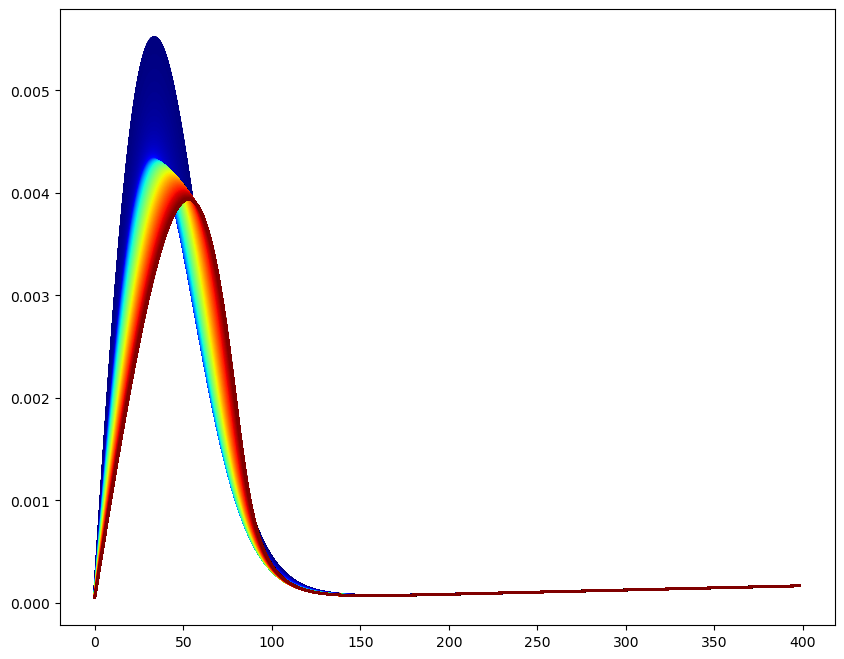

In [61]:
fig, ax = plt.subplots(figsize=(10,8))

for k in range(len(ttm_jt.Te_list)):
    color = plt.cm.jet(k/len(ttm_jt.Te_list))
    ax.plot(ttm_jt.grid.cell_volumes* ttm_jt.Ek_e_list[k][:-1], color=color)
    print(np.sum(ttm_jt.grid.cell_volumes* ttm_jt.Ek_e_list[k][:-1]))

# Comparison to Data

In [27]:
Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)

In [28]:
from scipy.optimize import curve_fit

def T_fit_form(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

def T_DIHfit_form(t, Te_0, d, τei):
    Ti_0 = Ti_initial
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

Te0_fit, Ti0_fit, d_fit, τei_fit = curve_fit(T_fit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] )[0]
Te0_DIHfit, d_DIHfit, τei_DIHfit = curve_fit(T_DIHfit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] )[0]
Te0_DIHfit, d_DIHfit, τei_DIHfit

(14.737503683125672, 0.3067048715628744, 252833.35515402406)

In [29]:
def plot_bulk_temperature(ttm, exp, plot_times = None, ax = None, title='', max_r=None):

    bulk_Tes = np.array(ttm.Te_list)[:,0]#np.array([exp.get_bulk_T(Te, ttm.n_e, max_r=max_r) for Te in ttm.Te_list])
    bulk_Tis = np.array(ttm.Ti_list)[:,0]#np.array([exp.get_bulk_T(Ti, ttm.n_e, max_r=max_r) for Ti in ttm.Ti_list]) # Use Zstar weighted density? i.e. use ne not ni
    
    T_av = 0.5*(bulk_Tes + bulk_Tis)
    ti_1, ti_2 = -100, -80

    T_av_1 = T_av[ti_1]
    T_av_2 = T_av[ti_2]

    dT_dt  = (T_av_2 - T_av_1)/(ttm.t_saved_list[ti_2] - ttm.t_saved_list[ti_1])

    T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_saved_list-ttm.t_saved_list[ti_1]))


    ax.plot(np.array(ttm.t_saved_list)*1e9, bulk_Tes*1e-3,label=r"$T_e$ (bulk)")
    ax.plot(np.array(ttm.t_saved_list)*1e9, bulk_Tis*1e-3,label=r"$T_i$ (bulk)")
    ax.plot(np.array(ttm.t_saved_list)*1e9, T_eq_line*1e-3,'--k',label='Linear Diffusion line')
#     ax.plot(np.array(ttm.t_list)*1e9, T_av*1e-3,'-k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0]*1e-3))
    
#     bulk_T_exp_fit = (Te_initial + Ti_initial)/2 - 0.5*120*1e9*ttm.t_list + (Te_initial - Ti_initial)/2 * np.exp(-ttm.t_list/(1470e-12))
#     print(bulk_T_exp_fit)
    ax.plot(np.array(ttm.t_saved_list)*1e9, T_fit_form(np.array(ttm.t_saved_list)*1e9, Te0_fit, Ti0_fit, d_fit, τei_fit),'r--' ,label="Experiment Fit")
#     ax.plot(ttm.t_list*1e9, T_DIHfit_form(ttm.t_list*1e9, Te0_fit, d_fit, τei_fit),'r-.' ,label="Experiment DIH fixed Fit")
    ax.plot(Xe_data['t[ns]'], Xe_data['T[kK]'], 'r-', label='Experiment Data')
    # Thermalization Text
    thermalization_text = r'$\tau_{th}$' + ' = {0:.1f} [ps] (exp 1470 ps)'.format(ttm.experiment.τei_Equilibration*1e12)
    thermalization_head_x_pos = 0.5* ttm.experiment.τei_Equilibration*1e9
    thermalization_head_y_pos = bulk_Tes[np.argmin(np.abs(ttm.t_saved_list-thermalization_head_x_pos*1e-9))]*1e-3
    
    thermalization_arrow_head_coords = (thermalization_head_x_pos, thermalization_head_y_pos )
    ax.annotate(thermalization_text, xy=thermalization_arrow_head_coords, xycoords='data',
                xytext=(150, 60), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))

    # Diffusion Text
    diffusion_text = 'Diffusion Estimate:\n dT/dt={0:.2f} [K/ns] (exp -120 K/ns)'.format(dT_dt*1e-9)
    diffusion_head_x_pos = 0.5*ttm.tmax*1e9
    diffusion_head_y_pos = 0.1 + bulk_Tes[np.argmin(np.abs(np.array(ttm.t_saved_list)-diffusion_head_x_pos*1e-9))]*1e-3
    
    diffusion_arrow_head_coords = (diffusion_head_x_pos, diffusion_head_y_pos )
    ax.annotate(diffusion_text, xy=diffusion_arrow_head_coords, xycoords='data',
                xytext=(60, 30), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    fit_string =  (r"My fit: $τ_{{ei}}$ = {0:.1f} [ps]".format(τei_fit*1e3) + '\n'+
                   r" $dT_e/dt$ = -{0:.1f} K/ns".format(d_fit*1e3) + '\n' +
                   r" $T^{{\rm init}}_e$ = {0:.2f} [kK]".format(Te0_fit) + '\n' +
                   r" $T^{{\rm init}}_i$ = {0:.2f} [kK]".format(Ti0_fit)

                  )
    ax.text(0.5, 0.95, fit_string, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)



    # Plot settings
    ax.set_xlabel(r"Time [ns]", fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlim(-0.1,ttm.tmax*1e9)
#     ax.set_ylim(10,20)

    ax.set_title(title,fontsize=20)
    ax.legend(fontsize=14)
    ax.grid(alpha=0.3)


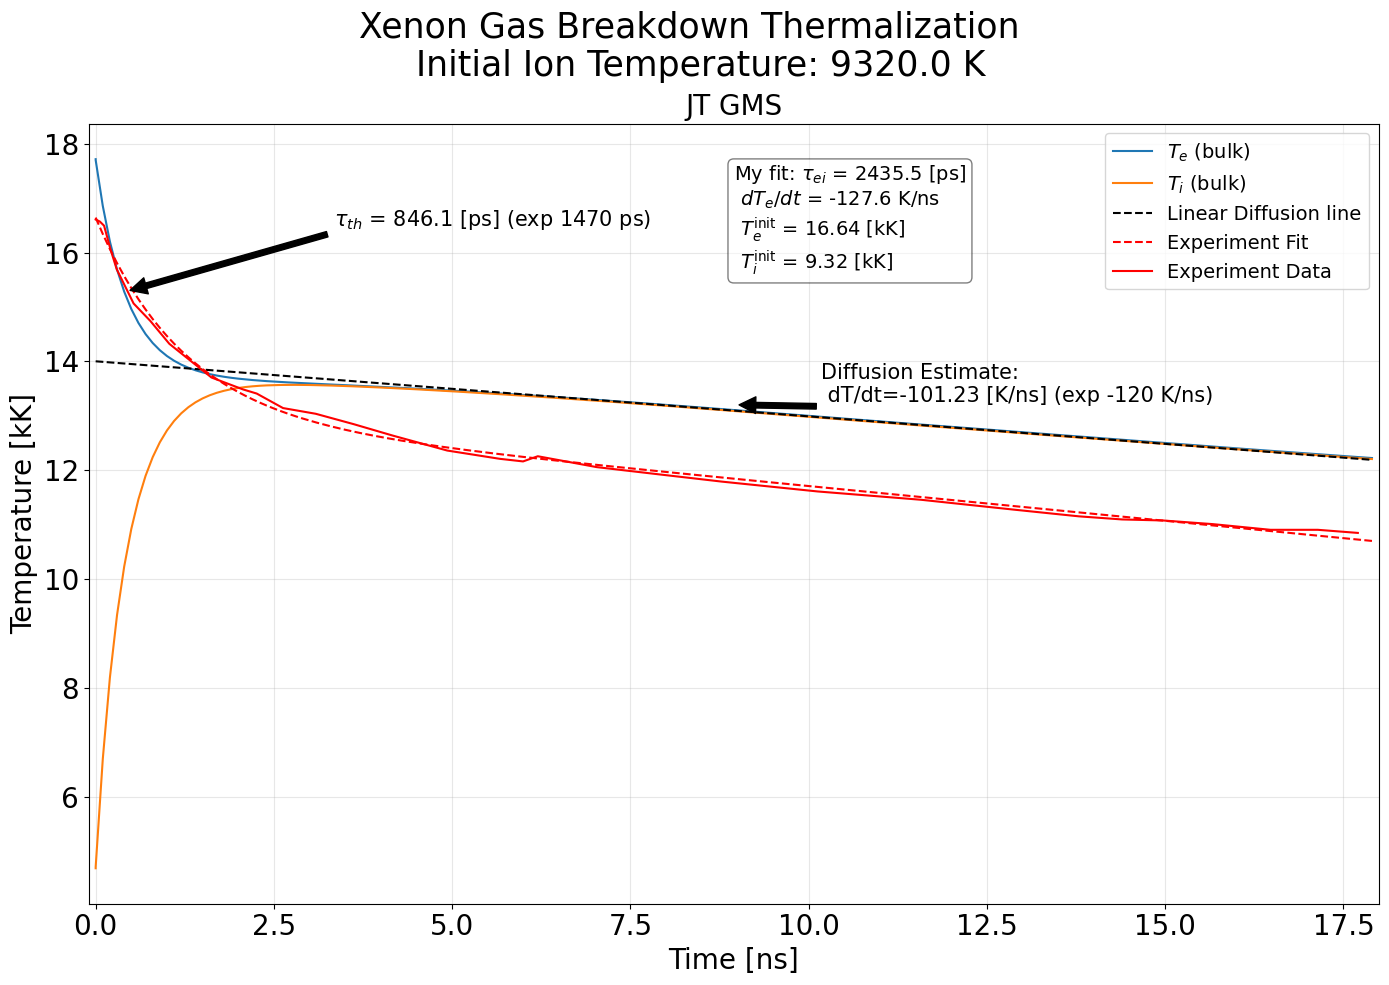

In [30]:
fig, ax = plt.subplots(1,1, figsize=(14,10),facecolor='w')
ax = np.array([ax])
fig.suptitle('Xenon Gas Breakdown Thermalization \n Initial Ion Temperature: {0:.1f} K'.format(Ti_initial),fontsize=25)
# fig.suptitle('Xenon Gas Breakdown Thermalization \n MD DIH $T_i$'.format(Ti_initial),fontsize=25)

plot_bulk_temperature(ttm_jt, Xenon_jt, ax = ax[0], title='JT GMS', max_r = 1e-6)
# plot_bulk_temperature(ttm_smt, Xenon_smt,  ax = ax[1], title='SMT')
fig.tight_layout()

# Adiabatic Expansion

"Collisionless expansion of a Gaussian plasma
into a vacuum" Mora


$$\frac{d \ln T_e}{dt} = 2 \frac{d \ln n_e}{dt}$$

In a cylindrical plasma with $n\propto 1/R^2$
$$\frac{d \ln T_e}{dt} = - 4 \frac{d \ln R}{dt}$$


In [1]:
0.9186746987951807, 48.899082568807344
10, 
dWidth_dt_exp = (53.027522935779814 - 48.899082568807344)/(10-0.9186746987951807) #μm/ns
dR_dt_exp = 0.5*dWidth_dt_exp

In [ ]:
dT_dt_exp = -127.6 # K/ns
R0 = 50e-6 # m
Rdot =  -4*R0* dT_dt_exp/13e4
print("Xe expanding at {0:.3f} μm per ns".format(Rdot*1e6))
print("Between 1, 10 ns, experimental dR/dt = {0:.3f} μm/ns".format(dR_dt_exp))

In [ ]:
print("".format(SMT.ion_thermal_velocity(1e4, A*m_p)*1e6/1e9))